### Lexical Features:
Average Word Length
Average Sentence Length By Word
Average Sentence Length By Character
Special Character Count
Average Syllable per Word
Functional Words Count
Punctuation Count

### Vocabulary Richness Features:
词汇丰富度 ttr



PCA和数据可视化：
如前所述，我们计算了近20个特征。之后，在所有块的矢量上运行K-Means算法，并识别质心。现在在这个阶段，质心的数量对应于识别出的不同书写风格的数量，这就是我们的系统要做的事情但是为了在视觉上看到那些聚类，我们必须使用主成分将我们的20维向量转换为2D向量从20D向量中提取精华并将其转换为2D向量的分析。然后我们绘制这些矢量并对那些通过K-Means在质心下组合在一起的那些块进行着色。通过这种方式，可以看到具有不同风格的块进一步加强了我们的结果。

# Import

In [47]:
import nltk
from nltk.corpus import cmudict
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as sw
import requests
import collections
import time
import requests
import json
import spacy
import gc
import math
import pandas as pd
import numpy as np
import scipy as sc
import pickle
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
%matplotlib inline

In [48]:
nltk.download('cmudict')
nltk.download('stopwords')
nltk.download("sentiwordnet")

[nltk_data] Downloading package cmudict to D:\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to D:\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [49]:
cmuDictionary = None
global cmuDictionary
cmuDictionary = cmudict.dict()
nlp = spacy.load("en_core_web_lg")

In [50]:
item_dict = {1:"ttr", 2:"word_num", 3:"avgSentLenth_word", 4:"avgSentLenth_char", 5:"exclamation_ratio", 6:"question_ratio", 7:"quote_ratio", 8:"once_word_ratio",
             9:"avg_word_syllable", 10:"stop_word_ratio", 11:"functional_word_ratio", 12:"flesch_cincade_grade_level", 
             13:"sentiment_mean", 14:"sentiment_var", 15:"sentiment_ending",
             16:"pos[NN]", 17:"self.pos[JJ]", 18:"pos[FW]", 19:"pos[RB]", 20:"pos[PRP]", 21:"pos[VB]", 22:"pos[UH]", 23:"pos[W]"}
increase_dict = {-1:"decline", 1:"improve"}

In [51]:
functional_word = """a between in nor some upon
    about both including nothing somebody us
    above but inside of someone used
    after by into off something via
    all can is on such we
    although cos it once than what
    am do its one that whatever
    among down latter onto the when
    an each less opposite their where
    and either like or them whether
    another enough little our these which
    any every lots outside they while
    anybody everybody many over this who
    anyone everyone me own those whoever
    anything everything more past though whom
    are few most per through whose
    around following much plenty till will
    as for must plus to with
    at from my regarding toward within
    be have near same towards without
    because he need several under worth
    before her neither she unless would
    behind him no should unlike yes
    below i nobody since until you
    beside if none so up your
    """
functional_word = functional_word.split()

# Utils

In [52]:
def lengthOfText(text: str):
    """
    FUNC:    Get the number of the words of the text
    """
    tokens = nltk.word_tokenize(text)
    return len(tokens)

In [53]:
def syllable_count(word: str):
    """
    FUNC:    get the syllable count of the word
    """
    global cmuDictionary
    d = cmuDictionary
    try:
        syl = [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]][0]
    except:
        syl = syllable_count_Manual(word)
    return syl

def syllable_count_Manual(word: str):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

In [54]:
# ------------------------------------------------------------------
def GunningFoxIndex(text, NoOfSentences):
    words = RemoveSpecialCHs(text)
    NoOFWords = float(len(words))
    complexWords = 0
    for word in words:
        if (syllable_count(word) > 2):
            complexWords += 1

    G = 0.4 * ((NoOFWords / NoOfSentences) + 100 * (complexWords / NoOFWords))
    return G

### Book Object

In [69]:
class Book:
    """
    A class to save information of a book
    ...
    Attributes
    ----------
    title: str         --- The title of the book
    author: str        --- The author name of the book
    id_corpus: str     --- The id of the book in corpus-db.org
    id_goodread: str   --- The id of the book in goodreader.com
    text: str          --- The whole text of the book
    rating: float      --- The rating score of the book in goodreader.com
    feature: object    --- The object for the feature of the book
    ...
    Methods
    -------
    set_id_rating      --- Set the id and the rating of the book
    get_feature        --- Output the feature of the book 
    """
    title = ""
    author = ""
    id_corpus = ""                        # id of corpus-db
    id_goodread = ""                      # id of goodreader.com
    text = ""
    rating = 0.0
    feature = None
        
    def __init__(self, title: str, author: str, id_: str):
        """
        FUNC:    Book object initial
        INPUT:   title: the book title
                 author: full name of author
                 id_: id of corpus-db
        """
        self.title = title
        self.author = author
        self.id_corpus = id_
        
    def set_text(self, text: str):
        """
        FUNC:    set the text of the book after download
        INPUT:   text of the novel (string)
        OUTPUT:  lenth of the text (integer)
        """
        self.text = text
        return len(text)
    
    def set_rating(self, rating: str):
        """
        FUNC:    set the rating of the book From goodreaders.com
        INPUT:   rating(string)
        OUTPUT:  rating(float)
        """
        self.rating = float(rating)
        return self.rating
    
    def set_id_rating(self):
        """
        FUNC:    set the id(of goodreads) and rating of given title
        OUTPUT:  True: get the rating successfully
                 False: have wrong in the process of getting the rating 
        """
        url = "https://www.goodreads.com/search/index.xml?q=" + self.title + "&key=" + "u87cBVRCcPR9vIeZTW1M6A"
        response = requests.get(url)
        if response.ok:
            root = ET.fromstring(response.content)
            try:
                id_ = root.find('search').find('results').find('work').find('id')
                print(id_.text)
                rating = root.find('search').find('results').find('work').find('average_rating')
                print(rating.text)
                self.id_goodread = str(id_.text)
                self.rating = float(str(rating.text))
                return True
            except:                               # deal with all fault
                return False
        else:
            print("get rating failed: response failed!")
            return False

    def get_feature(self):
        """
        FUNC:    SET or GET the feature of the book
                 if feature == none then set and init the Feature object
        OUTPUT:  numpy.array of the feature 
                 False: have wrong
        """
        try:
            if not self.feature:   # haven't set yer
                print("====== cal book feature ======")
                self.feature = Feature(self.text)
            return self.feature.get_feature()
        except:                   # deal with all fault
            return False

### Feature Object

In [70]:
class Feature:
    """
    A class to calculate and save the feature of a book 
    ...
    Attributes
    ----------
    text: str          --- The whole text of the book
    doc                --- nlp(text)
    all_word_tokens    --- the word collection of the text
    all_clean_word_tokens    --- the word collection of the text
    all_sent_tokens    --- the sentence collection of the text
    output: boolean    --- output the debug details
    ----------
    ttr:               --- Type Token Ratio
    word_num:          --- Count of the word
    avgSentLenth_word: --- Average sentence length (by words)
    avgSentLenth_word: --- Average sentence length (by chars)
    exclamation_ratio: --- The Ratio of the exclamation sentence 
    question_ratio:    --- The Ratio of the question sentence
    pos:               --- A dict of all type of pos, the value is ratio of each pos word in text
    quote_ratio:       --- The Ratio of the quoted sentence
    once_word_ratio    --- The ratio of the word which only appeared once
    avg_word_syllable  --- Average of the syllable count per word
    stop_word_ratio    --- The ratio of the stop words of whole words
    functional_word_ratio --- The ratio of the functional words of whole words
    flesch_cincade_grade_level --- Count the flesch cincade grade level
    flesch_reading_ease --- count the flesch_reading_ease
    sentiment_mean     --- average of the sentiment score of whole text
    sentiment_ending   --- average of the sentiment score of the last 1000 words of the text
    sentiment_var      --- the var of the sentiment score
    """
    text = None
    doc = None
    all_word_tokens = None
    all_clean_word_tokens = None
    all_sent_tokens = None
    output = False
    
    ttr = 0.0
    word_num = 0
    avgSentLenth_word = 0
    avgSentLenth_char = 0
    exclamation_ratio = 0.0   
    question_ratio = 0.0
    pos = {"JJ":0,"FW":0,"RB":0,"VB":0}
    quote_ratio = 0.0
    once_word_ratio = 0.0
    avg_word_syllable = 0.0  # adv read ability 
    stop_word_ratio = 0.0
    functional_word_ratio = 0.0
    flesch_reading_ease = 0.0
    flesch_cincade_grade_level = 0.0
    sentiment_mean = 0.0
    sentiment_ending = 0.0
    sentiment_var = 0.0
    K = None
    shannon_entropy = 0.0
    dale_chall_readability_formula = 0.0
    
    def __init__(self, text: str, output=False):
        self.text = text
        self.doc = nlp(text)
        self.output = output
        self.all_word_tokens = nltk.word_tokenize(text.lower())
        self.all_sent_tokens = nltk.sent_tokenize(text)
        self.all_clean_word_tokens = [word for word in self.all_word_tokens if word.isalpha()]
        #### cal
        self.cal_TypeTokenRatio()
        self.cal_word_num()
        self.cal_AvgSentLenth_word()
        self.cal_AvgSentLenth_char()
        self.cal_exclamation_question_mark_ratio()
        self.cal_POS()
        self.cal_quote_ratio()
        self.cal_once_appear_word_ratio()
        self.cal_avg_word_syllable()
        self.cal_stop_word_ratio()
        self.cal_functional_word_ratio()
        self.cal_flesch_reading_ease()
        self.cal_sentiment()
        self.cal_YulesCharacteristicK()
        self.cal_shannon_entropy()
        self.cal_dale_chall_readability_formula()
        if output:
            print("===== feature cal over =====")
    
    def cal_TypeTokenRatio(self):
        """
        FUNC:    calculate the typetokenration of the whole text
        """
        numTypes = len(set(self.all_word_tokens))
        numTokens = len(self.all_word_tokens)
        ttr = numTypes/numTokens
        self.ttr = ttr
        if self.output:
            print("TypeTokenRatio : " + str(ttr))
    
    def cal_word_num(self):
        self.word_num = len(self.all_word_tokens)
        if self.output:
            print("word_num : " + str(self.word_num))
    
    def cal_AvgSentLenth_word(self):
        """
        FUNC:    calculate the average sentence lenth of the text (by words)
        """
        self.avgSentLenth_word = pd.Series([lengthOfText(sent) for sent in self.all_sent_tokens]).mean()
        if self.output:
            print("avgSentLenth_word : " + str(self.avgSentLenth_word))
    
    def cal_AvgSentLenth_char(self):
        """
        FUNC:    calculate the average sentence lenth of the text (by char)
        """
        self.avgSentLenth_char = pd.Series([len(sent) for sent in self.all_sent_tokens]).mean()
        if self.output:
            print("avgSentLenth_char : " + str(self.avgSentLenth_char))

    def cal_exclamation_question_mark_ratio(self):
        """
        FUNC:    calculate the sentence of exclamation/question mark ratio
        """
        exclamations_num = 0
        question_num = 0
        all_sent_num = 0
        for sent in self.all_sent_tokens:
            all_sent_num += 1
            if sent.strip().endswith('!'):
                exclamations_num += 1
            elif sent.strip().endswith('?'):
                question_num += 1
        self.exclamation_ratio = exclamations_num / all_sent_num
        self.question_ratio = question_num / all_sent_num
        if self.output:
            print("exclamation_ratio: " + str(self.exclamation_ratio))
            print("question_ratio : " + str(self.question_ratio))
    
    def cal_POS(self):
        """
        FUNC:    calculate the ratio of each POS
        """
        all_pos = nltk.pos_tag(self.all_clean_word_tokens)
        for pair in all_pos:
            for pos_tag_ in self.pos.keys():
                if pos_tag_ in pair[1]:
                    self.pos[pos_tag_] += 1
        for pos_tag_ in self.pos.keys():
            self.pos[pos_tag_] /= len(all_pos)
      
    def cal_quote_ratio(self):
        """
        FUNC:    calculate the sentence of quotation mark ratio
        """
        count = 0
        for token in self.all_sent_tokens:
            if '\'' in token or '"' in token or '“' in token or '”'in token:
                count += 1
        self.quote_ratio = count / len(self.all_sent_tokens)
        if self.output:
            print("quote_ratio : " + str(self.quote_ratio))
    
    def cal_once_appear_word_ratio(self):
        """
        FUNC:    calculate the raio of the word appears only once in the text
        """
        num_all_word = len(set(self.all_clean_word_tokens))
        num_once_word = 0
        word_counter = collections.Counter(self.all_clean_word_tokens)
        for word in word_counter.keys():
            if word_counter[word] == 1:
                num_once_word +=1
        self.once_word_ratio = num_once_word / num_all_word
        if self.output:
            print("cal_once_appear_word_ratio : " + str(self.once_word_ratio))
    
    def cal_avg_word_syllable(self):
        """
        FUNC:    calculate the average syllable_num per word
        """
        self.avg_word_syllable = pd.Series([syllable_count(word) for word in self.all_clean_word_tokens]).mean()
        if self.output:
            print("cal_avg_word_syllable : " + str(self.avg_word_syllable))

    def cal_stop_word_ratio(self):
        """
        FUNC:    calculate the stop word ratio of the whole word
        """
        stop_word_count = 0
        all_word_count = 0
        for sent in self.doc.sents:
            for word in sent:
                all_word_count += 1
                if word.is_stop:
                    stop_word_count += 1
        self.stop_word_ratio = stop_word_count / all_word_count
        if self.output:
            print("cal_stop_word_ratio : " + str(self.stop_word_ratio))
    
    def cal_functional_word_ratio(self):
        """
        FUNC:    calculate the functional word ratio of the whole word
        """
        functional_word_count = 0
        for word in self.all_clean_word_tokens:
            if word in functional_word:
                functional_word_count += 1
        self.functional_word_ratio = functional_word_count / len(self.all_clean_word_tokens)
        if self.output:
            print("cal_functional_word_ratio : "+ str(self.functional_word_ratio))

    def cal_flesch_reading_ease(self):
        """
        FUNC:    calculate the flesch_reading_ease of the text
        """
        all_word_num = float(len(self.all_clean_word_tokens))
        all_sent_num = float(len(self.all_sent_tokens))
        all_syllable_num = 0
        for word in self.all_clean_word_tokens:
            all_syllable_num += syllable_count(word)
        rate = 206.835 - 1.015 * (all_word_num / float(all_sent_num)) - 84.6 * (all_syllable_num / all_word_num)
        level = 0.39 * (all_word_num / all_sent_num) + 11.8 * (all_syllable_num / all_word_num) - 15.59
        self.flesch_reading_ease = rate
        self.flesch_cincade_grade_level = level
        if self.output:
            print("cal_flesch_reading_ease : " + str(self.flesch_reading_ease))
            print("cal_flesch_reading_ease : " + str(self.flesch_cincade_grade_level))
            
    def cal_sentiment(self):
        """
        FUNC:    calculate the sentiment_parameter of the text
        """
        lemmaList = []
        sentScores = []
        for sent in self.doc.sents:
            sentLemmaList = []
            for w in sent:
                if (not w.is_stop) and (not w.is_punct) and (w.pos_ is not "PROPN"):
                    sentLemmaList.append((w.lemma_, w.pos_))
            lemmaList.append(sentLemmaList)
        for sent in lemmaList:
            scores = []
            for word, pos in sent:
                synPos = pos.lower()[0]
                if synPos not in ["a","n","y","v"]:
                    continue
                sysnets = list(sw.senti_synsets(word, synPos))
                if type(sysnets) == list and len(sysnets) > 0:
                    sysnet = sysnets[0]
                    score = sysnet.pos_score() - sysnet.neg_score()
                    scores.append(score)
            if len(scores) > 0:
                avgScores = sum(scores) / len(scores)
                sentScores.append(avgScores)
        series = pd.Series(sentScores)
        self.sentiment_mean = series.mean()
        self.sentiment_var = series.var()
        self.sentiment_ending = series.iloc[-1000:].mean()
        if self.output:
            print("sentiment_mean : " + str(self.sentiment_mean))
            print("sentiment_var : " + str(self.sentiment_var))
            print("sentiment_ending : " + str(self.sentiment_ending))
    
    def cal_YulesCharacteristicK(self):
        N = len(self.all_clean_word_tokens)
        freqs = collections.Counter()
        freqs.update(self.all_clean_word_tokens)
        vi = collections.Counter()
        vi.update(freqs.values())
        M = sum([(value * value) * vi[value] for key, value in freqs.items()])
        K = 10000 * (M - N) / math.pow(N, 2)
        self.K = K
    
    def cal_shannon_entropy(self):
        lenght = len(self.all_clean_word_tokens)
        freqs = collections.Counter()
        freqs.update(self.all_clean_word_tokens)
        arr = np.array(list(freqs.values()))
        distribution = 1. * arr
        distribution /= max(1, lenght)
        H = sc.stats.entropy(distribution, base=2)
        self.shannon_entropy = H
    
    def cal_dale_chall_readability_formula(self):
        difficult = 0
        adjusted = 0
        NoOfWords = len(self.all_clean_word_tokens)
        NoOfSectences = len(self.all_sent_tokens)
        with open('dale-chall_unix.pkl', 'rb') as f:
            fimiliarWords = pickle.load(f)
        for word in self.all_clean_word_tokens:
            if word not in fimiliarWords:
                difficult += 1
        percent = (difficult / NoOfWords) * 100
        if (percent > 5):
            adjusted = 3.6365
        D = 0.1579 * (percent) + 0.0496 * (NoOfWords / NoOfSectences) + adjusted
        self.dale_chall_readability_formula = D
    
    def get_feature(self):
        output_array = np.array([self.ttr, self.word_num, self.avgSentLenth_word, self.avgSentLenth_char,
                                 self.exclamation_ratio, self.question_ratio, self.quote_ratio, self.once_word_ratio,
                                 self.avg_word_syllable, self.stop_word_ratio, self.functional_word_ratio, self.flesch_reading_ease,
                                 self.flesch_cincade_grade_level, self.sentiment_mean, self.sentiment_var, self.sentiment_ending,
                                 self.pos["JJ"], self.pos["FW"], self.pos["RB"], self.pos["VB"], self.K, self.shannon_entropy,
                                 self.dale_chall_readability_formula],
                                dtype=np.float32)     
        return output_array

In [71]:
# -------------------------------------------------------------------------
# K  10,000 * (M - N) / N**2
# , where M  Sigma i**2 * Vi.
def YulesCharacteristicK(text):
    words = RemoveSpecialCHs(text)
    N = len(words)
    freqs = coll.Counter()
    freqs.update(words)
    vi = coll.Counter()
    vi.update(freqs.values())
    M = sum([(value * value) * vi[value] for key, value in freqs.items()])
    K = 10000 * (M - N) / math.pow(N, 2)
    return K

# -1*sigma(pi*lnpi)
# Shannon and sympsons index are basically diversity indices for any community
def ShannonEntropy(text):
    words = RemoveSpecialCHs(text)
    lenght = len(words)
    freqs = coll.Counter()
    freqs.update(words)
    arr = np.array(list(freqs.values()))
    distribution = 1. * arr
    distribution /= max(1, lenght)
    import scipy as sc
    H = sc.stats.entropy(distribution, base=2)
    # H = sum([(i/lenght)*math.log(i/lenght,math.e) for i in freqs.values()])
    return H

# Dale Chall Readability Formula
# -----------------------------------------------------------------
def dale_chall_readability_formula(text, NoOfSectences):
    words = RemoveSpecialCHs(text)
    difficult = 0
    adjusted = 0
    NoOfWords = len(words)
    with open('dale-chall.pkl', 'rb') as f:
        fimiliarWords = pickle.load(f)
    for word in words:
        if word not in fimiliarWords:
            difficult += 1
    percent = (difficult / NoOfWords) * 100
    if (percent > 5):
        adjusted = 3.6365
    D = 0.1579 * (percent) + 0.0496 * (NoOfWords / NoOfSectences) + adjusted
    return D

In [72]:
tmp = Feature("""Petter. Amy.  As PCA smudges the higher dimensional vector into a 2D vector, so there is a high possibility of some loss of significance during the conversion process. Due to this there is a possibility that after plotting the clusters don’t seem distinguishable as expected due to the loss of information while doing PCA. This is not as such a limitation to our system, since our system correctly identifies the number of writing styles through the value of K which is enough to proof the correctness of our approach but if and only if there is a need to visually see those clusters then it is only possible by converting the high dimensional vectors using PCA to a 2D one. In a scenario where the document is written by a single author! One may assume that in this case there should be only one cluster implying one writing style. However, this is not the case every time. As we know each paragraph written even by the same author has a bit different writing style than its other counterparts like e.g there are some minor differences in lexical features (number of punctuation marks and others). Also there might be a poetry in paragraphs, mathematical equations etc. So our method will create clusters according to the writing style within that document. But the major difference in such a setting is the distance between those clusters? The more different the writing styles are the more far away the clusters are from each other. In the case of a document with the same writing style, even if some clusters are made, the distance between those clusters should be small as compared to the case if the document had really different writing styles. Hence this is the crucial essence which makes our algorithm excel because it not only identifies one part of the story i.e number of writing styles but also shows how different those writings styles are from each otherwhich is implied by the distance between the clusters.""")

In [73]:
tmp.get_feature().shape

(23,)

In [74]:
def cal_tfidf(texts: dict):
    tfidf = TfidfVectorizer(tokenizer=nltk.word_tokenize, max_features=400, stop_words="english")
    labels = texts.keys()
    values = [texts[label] for label in labels]
    tfMatrix = tfidf.fit_transform(values)
    wordLabels = tfidf.get_feature_names()
    df = pd.DataFrame(tfMatrix.todense(), index=labels, columns=wordLabels)
    pca = PCA(n_components=3)
    pcaOut = pca.fit_transform(tfMatrix.todense())
    pcaDF = pd.DataFrame(pcaOut, index=labels, columns=['C1','C2','C3'])
    ### numpy array: df.values
    ### todo: convert the datafame to the numpy array

In [75]:
def download_text(id_: str):
    """
    FUNC:    download the text form corpus-db.org
             using id to download it 
             return text(string)
    """
    text = ""
    response = requests.get('http://corpus-db.org/api/id/'+id_+'/fulltext')
    if response.ok: 
        print("======= get it =======")
        text = response.text
        if len(json.loads(text)) > 0 :
            text = json.loads(text)[0]['text']
        else :
            print("**** response fail ****")
            return False
    else:
        print("**** response fail ****")
        return False
    return text

## Data Download and Calculate

In [76]:
detective_list = json.loads(requests.get("http://corpus-db.org/api/subject/Detective and mystery stories").text)
science_list = json.loads(requests.get("http://corpus-db.org/api/subject/Science fiction").text)
love_list = json.loads(requests.get("http://corpus-db.org/api/subject/Love stories").text)
poetry_list = json.loads(requests.get("http://corpus-db.org/api/subject/Poetry").text)

In [103]:
englist_list = json.loads(requests.get("http://corpus-db.org/api/subject/English fiction -- 19th century").text)
america_list = json.loads(requests.get("http://corpus-db.org/api/subject/American%20fiction%20--%2019th%20century").text)

In [104]:
def download_cal_list(book_list, name):
        count = 0
        df = pd.DataFrame()
        for i in book_list:
            print("==============================================")
            count += 1 
            try:
                print(count)
                title = i["title"]
                if ':' in title:
                    title = title.split(':')[0]
                elif ',' in title:
                    title = title.split(',')[0]
                elif '—' in title:
                    title = title.split('—')[0]
                elif '.' in title:
                    title = title.split('.')[0]

                id_ = i["id"]
                author = i["creator"]
                if "agent_name" in author:
                    author = author.split('\'')[5]
                else:
                    author = None
                newbook = Book(title=title, id_=id_, author=author)
                print(title)
                text = download_text(id_)
                if not text:
                    continue
                length = newbook.set_text(text)        
                if not newbook.set_id_rating():
                    continue
                rating = newbook.rating
                if rating == 0.0:                              # clear the book get no rating
                    continue
                feature_array = newbook.get_feature()
                if feature_array is False:
                    continue
                series = pd.Series(feature_array, name=title)
                series["rating"] = rating
                df = df.append(series)
                del newbook
                gc.collect()
                if count % 50 == 1:
                    df.to_csv("save_"+ name +str(count)+".csv")
            except:
                df.to_csv("save_"+ name +str(count)+".csv")
                continue
        df.to_csv("save_" + name + "final" + ".csv")

In [105]:
download_cal_list(englist_list, "englisth")
download_cal_list(america_list,"america")

1
The Gathering of Brother Hilarius
======= get it =======
**** response fail ****
2
The Perils of Certain English Prisoners
======= get it =======
6246178
3.26
====== cal book feature ======
3
A Message from the Sea
======= get it =======
2501679
3.27
====== cal book feature ======
4
The Private Papers of Henry Ryecroft
======= get it =======
1789543
3.91
====== cal book feature ======
5
The History of Samuel Titmarsh
======= get it =======
6626488
3.33
====== cal book feature ======
6
A Simpleton
======= get it =======
54316315
3.95
====== cal book feature ======
7
A House to Let
======= get it =======
1955711
3.60
====== cal book feature ======
8
Stories By English Authors
======= get it =======
4995469
3.16
====== cal book feature ======
9
The Lady of Lyons; Or
======= get it =======
3004167
4.00
====== cal book feature ======
10
Put Yourself in His Place
======= get it =======
6696269
4.57
====== cal book feature ======
11
Heartsease; Or
======= get it =======
2297591
3.83
====== 

61
Evan Harrington 
======= get it =======
6893335
3.08
====== cal book feature ======
62
Evan Harrington 
======= get it =======
6893335
3.08
====== cal book feature ======
63
Beauchamp's Career 
======= get it =======
2145422
3.83
====== cal book feature ======
64
Beauchamp's Career 
======= get it =======
2145422
3.83
====== cal book feature ======
65
Beauchamp's Career 
======= get it =======
2145422
3.83
====== cal book feature ======
66
Beauchamp's Career 
======= get it =======
2145422
3.83
====== cal book feature ======
67
Beauchamp's Career 
======= get it =======
2145422
3.83
====== cal book feature ======
68
Beauchamp's Career 
======= get it =======
2145422
3.83
====== cal book feature ======
69
Beauchamp's Career 
======= get it =======
2145422
3.83
====== cal book feature ======
70
Beauchamp's Career 
======= get it =======
2145422
3.83
====== cal book feature ======
71
The Tragic Comedians
======= get it =======
69381152
0.0
72
The Tragic Comedians
======= get it =======

====== cal book feature ======
121
The Caxtons
======= get it =======
255481
3.62
====== cal book feature ======
122
The Caxtons
======= get it =======
255481
3.62
====== cal book feature ======
123
The Caxtons
======= get it =======
255481
3.62
====== cal book feature ======
124
The Caxtons
======= get it =======
255481
3.62
====== cal book feature ======
125
The Caxtons
======= get it =======
255481
3.62
====== cal book feature ======
126
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
127
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
128
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
129
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
130
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
131
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
132
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
133
Pe

181
Lucretia 
======= get it =======
21555968
3.84
====== cal book feature ======
182
Lucretia 
======= get it =======
21555968
3.84
====== cal book feature ======
183
A Strange Story 
======= get it =======
347873
4.03
====== cal book feature ======
184
A Strange Story 
======= get it =======
347873
4.03
====== cal book feature ======
185
A Strange Story 
======= get it =======
347873
4.03
====== cal book feature ======
186
A Strange Story 
======= get it =======
347873
4.03
====== cal book feature ======
187
A Strange Story 
======= get it =======
347873
4.03
====== cal book feature ======
188
A Strange Story 
======= get it =======
347873
4.03
====== cal book feature ======
189
A Strange Story 
======= get it =======
347873
4.03
====== cal book feature ======
190
A Strange Story 
======= get it =======
347873
4.03
====== cal book feature ======
191
A Strange Story 
======= get it =======
347873
4.03
====== cal book feature ======
192
The Parisians 
======= get it =======
63075946
4.

Some Persons Unknown
======= get it =======
42498770
0.0
245
The Notting Hill Mystery
======= get it =======
**** response fail ****
1
The Autocrat of the Breakfast-Table
======= get it =======
769797
3.41
====== cal book feature ======
2
The Works of Edgar Allan Poe 
======= get it =======
45971917
4.50
====== cal book feature ======
3
The Works of Edgar Allan Poe 
======= get it =======
45971917
4.50
====== cal book feature ======
4
The Works of Edgar Allan Poe 
======= get it =======
45971917
4.50
====== cal book feature ======
5
The Works of Edgar Allan Poe 
======= get it =======
45971917
4.50
====== cal book feature ======
6
The Works of Edgar Allan Poe 
======= get it =======
45971917
4.50
====== cal book feature ======
7
Thankful Blossom
======= get it =======
6287330
3.67
====== cal book feature ======
8
By Shore and Sedge
======= get it =======
13045024
3.40
====== cal book feature ======
9
Drift from Two Shores
======= get it =======
11048256
4.00
====== cal book feature ===

Heart-Histories and Life-Pictures
======= get it =======
18309473
2.00
====== cal book feature ======
60
The Midnight Passenger 
======= get it =======
10687446
3.55
====== cal book feature ======
61
Crucial Instances
======= get it =======
553978
3.64
====== cal book feature ======
62
Five Thousand Dollars Reward
======= get it =======
3309163
3.88
====== cal book feature ======
63
Virgie's Inheritance
======= get it =======
9549038
3.40
====== cal book feature ======
64
Elbow-Room
======= get it =======
183367
3.70
====== cal book feature ======
65
Tri Noveloj
======= get it =======
**** response fail ****
66
Tri Noveloj
======= get it =======
**** response fail ****
67
The Finer Grain
======= get it =======
41956437
4.17
====== cal book feature ======
68
The Works of Edgar Allan Poe, The Raven Edition
======= get it =======
12933379
4.36
====== cal book feature ======
69
The Indifference of Juliet
======= get it =======
6927531
3.92
====== cal book feature ======
70
A Brother To Dra

In [78]:
download_cal_list(science_list, "science")

1
The Time Machine
======= get it =======
3234863
3.88
====== cal book feature ======
2
The War of the Worlds
======= get it =======
3194841
3.81
====== cal book feature ======
3
The Strange Case of Dr
======= get it =======
3164921
3.80
====== cal book feature ======
4
The Strange Case of Dr
======= get it =======
3164921
3.80
====== cal book feature ======
5
A Princess of Mars
======= get it =======
1129624
3.80
====== cal book feature ======
6
The Gods of Mars
======= get it =======
2816507
3.87
====== cal book feature ======
7
Warlord of Mars
======= get it =======
2816562
3.86
====== cal book feature ======
8
Thuvia
======= get it =======
1387380
3.75
====== cal book feature ======
9
From the Earth to the Moon; and
======= get it =======
14165539
3.78
====== cal book feature ======
10
Frankenstein; Or
======= get it =======
4836639
3.78
====== cal book feature ======
11
The Monster Men
======= get it =======
7160343
4.25
====== cal book feature ======
12
At the Earth's Core
======

60
Autour de la Lune
======= get it =======
70707277
4.00
====== cal book feature ======
61
Voyage au Centre de la Terre
======= get it =======
7140961
3.60
====== cal book feature ======
62
The Blind Spot
======= get it =======
16027324
3.54
====== cal book feature ======
63
Les Cinq Cents Millions De La Bégum
======= get it =======
72159413
0.0
====== cal book feature ======
64
Five Thousand Miles Underground; Or
======= get it =======
3037039
3.07
====== cal book feature ======
65
Vingt Mille Lieues Sous Les Mers 
======= get it =======
69783455
3.72
====== cal book feature ======
66
Vingt Mille Lieues Sous Les Mers 
======= get it =======
69783455
3.72
====== cal book feature ======
67
Vingt mille Lieues Sous Les Mers 
======= get it =======
69783455
3.72
====== cal book feature ======
68
Robur-le-Conquerant
======= get it =======
70707271
0.0
====== cal book feature ======
69
Gold of the Gods
======= get it =======
336511
3.31
====== cal book feature ======
70
Cæsar's Column
=====

3.89
====== cal book feature ======
119
The Sleeper Awakes
======= get it =======
25422057
3.80
====== cal book feature ======
120
The Flying Legion
======= get it =======
5328678
3.44
====== cal book feature ======
121
Sans dessus dessous
======= get it =======
**** response fail ****
122
The Stolen Bacillus and Other Incidents
======= get it =======
1112610
3.64
====== cal book feature ======
123
The Air Trust
======= get it =======
3736427
2.73
====== cal book feature ======
124
The Moon-Voyage
======= get it =======
26884062
3.63
====== cal book feature ======
125
R
======= get it =======
6277
4.09
====== cal book feature ======
126
The Certainty of a Future Life in Mars
======= get it =======
27509573
4.00
====== cal book feature ======
127
Zarlah the Martian
======= get it =======
2975906
2.75
====== cal book feature ======
128
In the Clutch of the War-God
======= get it =======
13125197
2.60
====== cal book feature ======
129
Scorched Earth
======= get it =======
520775
3.97
===

179
Flight From Tomorrow
======= get it =======
662240
3.65
====== cal book feature ======
180
Star Surgeon
======= get it =======
1692546
3.85
====== cal book feature ======
181
Sabotage in Space
======= get it =======
1929914
3.72
====== cal book feature ======
182
The Edge of the Knife
======= get it =======
987510
3.60
====== cal book feature ======
183
The Fourth "R"
======= get it =======
4640799
4.47
====== cal book feature ======
184
Crossroads of Destiny
======= get it =======
6668623
3.59
====== cal book feature ======
185
Hunter Patrol
======= get it =======
322814
3.44
====== cal book feature ======
186
In Search of the Unknown
======= get it =======
3047352
3.49
====== cal book feature ======
187
Space Tug
======= get it =======
3828671
3.30
====== cal book feature ======
188
The Space Pioneers
======= get it =======
6629942
3.60
====== cal book feature ======
189
Treachery in Outer Space
======= get it =======
1929913
3.60
====== cal book feature ======
190
Last Enemy
===

====== cal book feature ======
239
Highways in Hiding
======= get it =======
2512106
3.67
====== cal book feature ======
240
The White Invaders
======= get it =======
6398429
3.00
====== cal book feature ======
241
Out Around Rigel
======= get it =======
16251479
3.23
====== cal book feature ======
242
Oomphel in the Sky
======= get it =======
2968542
3.66
====== cal book feature ======
243
Ministry of Disturbance
======= get it =======
13478691
3.78
====== cal book feature ======
244
The Black Star Passes
======= get it =======
2030151
3.27
====== cal book feature ======
245
The Man With The Broken Ear
======= get it =======
3208802
3.39
====== cal book feature ======
246
A Slave is a Slave
======= get it =======
40767237
4.21
====== cal book feature ======
247
The Cosmic Computer
======= get it =======
1658187
3.73
====== cal book feature ======
248
Space Viking
======= get it =======
3097582
3.76
====== cal book feature ======
249
Rebels of the Red Planet
======= get it =======
3397

298
Brain Twister
======= get it =======
958490
3.44
====== cal book feature ======
299
The Impossibles
======= get it =======
1239736
4.08
====== cal book feature ======
300
Exile
======= get it =======
1138855
3.97
====== cal book feature ======
301
Danger! and Other Stories
======= get it =======
349598
3.34
====== cal book feature ======
302
The Players
======= get it =======
14863741
4.28
====== cal book feature ======
303
Slingshot
======= get it =======
15119686
4.25
====== cal book feature ======
304
The Ultimate Experiment
======= get it =======
1579499
4.06
====== cal book feature ======
305
Sand Doom
======= get it =======
14387515
3.41
====== cal book feature ======
306
The Bell Tone
======= get it =======
6514618
3.17
====== cal book feature ======
307
The Stutterer
======= get it =======
46904015
3.99
====== cal book feature ======
308
Sense from Thought Divide
======= get it =======
6421137
3.83
====== cal book feature ======
309
The Hunters
======= get it =======
659616

359
Stairway to the Stars
======= get it =======
21390950
3.91
====== cal book feature ======
360
Solomon's Orbit
======= get it =======
15069948
3.38
====== cal book feature ======
361
No Great Magic
======= get it =======
6464146
3.54
====== cal book feature ======
362
The Creature from Cleveland Depths
======= get it =======
7270914
3.66
====== cal book feature ======
363
The Glory of Ippling
======= get it =======
25536105
2.50
====== cal book feature ======
364
The Common Man
======= get it =======
10196002
4.15
====== cal book feature ======
365
Subversive
======= get it =======
7313789
3.38
====== cal book feature ======
366
With No Strings Attached
======= get it =======
13585192
3.57
====== cal book feature ======
367
Missing Link
======= get it =======
26582910
4.19
====== cal book feature ======
368
The Servant Problem
======= get it =======
19021591
3.10
====== cal book feature ======
369
Unwise Child
======= get it =======
958482
2.97
====== cal book feature ======
370
Tig

420
The Aliens
======= get it =======
35062
4.09
====== cal book feature ======
421
We Didn't Do Anything Wrong
======= get it =======
16728085
3.31
====== cal book feature ======
422
Make Mine Homogenized
======= get it =======
6042473
4.00
====== cal book feature ======
423
As Long As You Wish
======= get it =======
13286195
3.00
====== cal book feature ======
424
Pushbutton War
======= get it =======
24999871
2.86
====== cal book feature ======
425
The Measure of a Man
======= get it =======
1659143
3.71
====== cal book feature ======
426
Doktoro Jekyll kaj Sinjoro Hyde
======= get it =======
68888680
0.0
====== cal book feature ======
427
The Ambulance Made Two Trips
======= get it =======
6276984
3.35
====== cal book feature ======
428
Disturbing Sun
======= get it =======
43577713
0.0
====== cal book feature ======
429
The Sky Trap
======= get it =======
6464145
3.17
====== cal book feature ======
430
The Guardians
======= get it =======
810630
4.15
====== cal book feature ======

====== cal book feature ======
481
The Monster
======= get it =======
13492114
4.37
====== cal book feature ======
482
Aventures extraordinaires d'un savant russe
======= get it =======
17865253
0.0
====== cal book feature ======
483
A Matter of Magnitude
======= get it =======
6521084
3.62
====== cal book feature ======
484
Longevity
======= get it =======
67674893
3.67
====== cal book feature ======
485
Control Group
======= get it =======
14245013
3.12
====== cal book feature ======
486
Man Made
======= get it =======
19112578
3.71
====== cal book feature ======
487
Second Landing
======= get it =======
644171
4.17
====== cal book feature ======
488
Aventures extraordinaires d'un savant russe
======= get it =======
17865253
0.0
====== cal book feature ======
489
The Deadly Daughters
======= get it =======
43447034
3.48
====== cal book feature ======
490
Survival Tactics
======= get it =======
6609092
3.51
====== cal book feature ======
491
The Gift Bearer
======= get it =======
1872

541
A Choice of Miracles
======= get it =======
15816729
2.70
====== cal book feature ======
542
Citadel
======= get it =======
621034
4.16
====== cal book feature ======
543
Next Door
======= get it =======
48284103
3.77
====== cal book feature ======
544
Pandemic
======= get it =======
56028599
4.04
====== cal book feature ======
545
The Star Hyacinths
======= get it =======
6514632
4.09
====== cal book feature ======
546
A Prize for Edie
======= get it =======
6651152
3.60
====== cal book feature ======
547
Earthmen Bearing Gifts
======= get it =======
6710129
3.46
====== cal book feature ======
548
The Good Neighbors
======= get it =======
44628209
3.34
====== cal book feature ======
549
The Crack of Doom
======= get it =======
2487747
3.91
====== cal book feature ======
550
Monkey On His Back
======= get it =======
18940007
3.00
====== cal book feature ======
551
The Mystery of the Green Ray
======= get it =======
6623301
2.83
====== cal book feature ======
552
I'm a Stranger Here

601
The Doomsman
======= get it =======
2067106
3.33
====== cal book feature ======
602
Revenge
======= get it =======
2651193
3.87
====== cal book feature ======
603
Vital Ingredient
======= get it =======
15572964
3.30
====== cal book feature ======
604
The Love of Frank Nineteen
======= get it =======
18737194
3.50
====== cal book feature ======
605
Tulan
======= get it =======
21838910
3.67
====== cal book feature ======
606
Reluctant Genius
======= get it =======
17192691
3.03
====== cal book feature ======
607
Resurrection
======= get it =======
1491227
4.12
====== cal book feature ======
608
Walls of Acid
======= get it =======
6541744
3.33
====== cal book feature ======
609
Shepherd of the Planets
======= get it =======
6558468
2.67
====== cal book feature ======
610
The Man Who Saw the Future
======= get it =======
6498983
3.21
====== cal book feature ======
611
The Next Logical Step
======= get it =======
6455079
3.59
====== cal book feature ======
612
Moment of Truth
=======

661
Shipwreck in the Sky
======= get it =======
13412538
3.00
====== cal book feature ======
662
With the Night Mail
======= get it =======
709442
3.08
====== cal book feature ======
663
No Pets Allowed
======= get it =======
17786892
3.00
====== cal book feature ======
664
The Mathematicians
======= get it =======
1486751
3.92
====== cal book feature ======
665
Keep Out
======= get it =======
41068531
3.77
====== cal book feature ======
666
Equation of Doom
======= get it =======
13581715
3.78
====== cal book feature ======
667
Cogito
======= get it =======
1013375
4.31
====== cal book feature ======
668
Acid Bath
======= get it =======
7740843
3.11
====== cal book feature ======
669
Operation Lorelie
======= get it =======
17787004
2.83
====== cal book feature ======
670
Houlihan's Equation
======= get it =======
17787027
4.00
====== cal book feature ======
671
The Hoofer
======= get it =======
24647273
3.95
====== cal book feature ======
672
The Pygmy Planet
======= get it =======
6

720
Pariah Planet
======= get it =======
48835664
3.94
====== cal book feature ======
721
Invasion
======= get it =======
42216232
4.12
====== cal book feature ======
722
Loot of the Void
======= get it =======
46169636
2.00
====== cal book feature ======
723
Cost of Living
======= get it =======
3138069
4.18
====== cal book feature ======
724
Lords of the Stratosphere
======= get it =======
11135816
3.50
====== cal book feature ======
725
The Velvet Glove
======= get it =======
372591
4.07
====== cal book feature ======
726
Under Arctic Ice
======= get it =======
6867438
3.40
====== cal book feature ======
727
Forever
======= get it =======
423
4.15
====== cal book feature ======
728
We're Friends
======= get it =======
2113960
4.11
====== cal book feature ======
729
Old Rambling House
======= get it =======
16508819
3.30
====== cal book feature ======
730
The Hated
======= get it =======
45762345
4.19
====== cal book feature ======
731
What's He Doing in There?
======= get it =======

780
Flamedown
======= get it =======
20107746
2.71
====== cal book feature ======
781
Dogfight
======= get it =======
10491062
3.53
====== cal book feature ======
782
Spacemen Never Die!
======= get it =======
16272831
3.11
====== cal book feature ======
783
Two Timer
======= get it =======
867478
3.59
====== cal book feature ======
784
There is a Reaper 
======= get it =======
62025801
4.35
====== cal book feature ======
785
Celebrity
======= get it =======
16243683
4.30
====== cal book feature ======
786
Goodbye
======= get it =======
2906898
4.01
====== cal book feature ======
787
Two Thousand Miles Below
======= get it =======
15322546
2.72
====== cal book feature ======
788
Slaves of Mercury
======= get it =======
18604665
2.33
====== cal book feature ======
789
Quatro Novelas
======= get it =======
41717299
4.00
====== cal book feature ======
790
One Martian Afternoon
======= get it =======
41052448
3.88
====== cal book feature ======
791
Weak on Square Roots
======= get it =====

840
Status Quo
======= get it =======
55379993
4.50
====== cal book feature ======
841
The Last Supper
======= get it =======
55973541
3.75
====== cal book feature ======
842
The Smiler
======= get it =======
6582125
4.23
====== cal book feature ======
843
The Stowaway
======= get it =======
452722
3.48
====== cal book feature ======
844
Service with a Smile
======= get it =======
435420
4.16
====== cal book feature ======
845
Field Trip
======= get it =======
43311654
3.64
====== cal book feature ======
846
Pipe of Peace
======= get it =======
18101145
3.12
====== cal book feature ======
847
Prelude to Space
======= get it =======
2116994
3.63
====== cal book feature ======
848
Say "Hello" for Me
======= get it =======
18586179
3.11
====== cal book feature ======
849
Spies Die Hard!
======= get it =======
37378669
2.88
====== cal book feature ======
850
The One and the Many
======= get it =======
3217787
4.06
====== cal book feature ======
851
The Other Likeness
======= get it =======

====== cal book feature ======
901
Nor Iron Bars a Cage
======= get it =======
25266790
4.12
====== cal book feature ======
902
"To Invade New York
======= get it =======
999519
2.58
====== cal book feature ======
903
What Need of Man?
======= get it =======
44500904
5.00
====== cal book feature ======
904
Thin Edge
======= get it =======
61697234
4.22
====== cal book feature ======
905
Step IV
======= get it =======
42443477
2.00
====== cal book feature ======
906
Heart
======= get it =======
2877220
3.42
====== cal book feature ======
907
Fee of the Frontier
======= get it =======
63588599
0.0
====== cal book feature ======
908
Expediter
======= get it =======
6459662
3.92
====== cal book feature ======
909
The Demi-Urge
======= get it =======
55859050
3.11
====== cal book feature ======
910
Jack of No Trades
======= get it =======
7013488
4.31
====== cal book feature ======
911
Before Egypt
======= get it =======
13581531
3.06
====== cal book feature ======
912
The People of the Cra

====== cal book feature ======
961
Out of the Earth
======= get it =======
228833
4.14
====== cal book feature ======
962
To Remember Charlie By
======= get it =======
645228
3.81
====== cal book feature ======
963
An Empty Bottle
======= get it =======
63258952
3.76
====== cal book feature ======
964
Robots of the World! Arise!
======= get it =======
20107711
3.85
====== cal book feature ======
965
The Very Secret Agent
======= get it =======
27318675
2.00
====== cal book feature ======
966
The Planet Savers
======= get it =======
1073262
3.76
====== cal book feature ======
967
The Vilbar Party
======= get it =======
14857888
3.30
====== cal book feature ======
968
Helpfully Yours
======= get it =======
37343533
3.25
====== cal book feature ======
969
My Fair Planet
======= get it =======
37341372
3.62
====== cal book feature ======
970
The Instant of Now
======= get it =======
14886606
5.00
====== cal book feature ======
971
Conquest Over Time
======= get it =======
12931946
3.55
===

====== cal book feature ======
1021
Forget Me Nearly
======= get it =======
13581769
3.60
====== cal book feature ======
1022
The World That Couldn't Be
======= get it =======
14563338
3.74
====== cal book feature ======
1023
Seed of the Arctic Ice
======= get it =======
40315012
3.00
====== cal book feature ======
1024
Second Variety
======= get it =======
42795960
3.98
====== cal book feature ======
1025
The Unprotected Species
======= get it =======
13055546
3.00
====== cal book feature ======
1026
Diplomatic Immunity
======= get it =======
44260855
3.42
====== cal book feature ======
1027
One Man's Poison
======= get it =======
4499741
3.85
====== cal book feature ======
1028
Stamped Caution
======= get it =======
20044714
3.35
====== cal book feature ======
1029
The Hand
======= get it =======
9621771
4.03
====== cal book feature ======
1030
Atom Drive
======= get it =======
15697293
3.88
====== cal book feature ======
1031
World of the Drone
======= get it =======
13581843
4.00
=

====== cal book feature ======
1081
The Animated Pinup
======= get it =======
13402721
3.33
====== cal book feature ======
1082
Keep Your Shape
======= get it =======
40156604
3.74
====== cal book feature ======
1083
Time Fuze
======= get it =======
13451842
3.47
====== cal book feature ======
1084
Voyage To Eternity
======= get it =======
41911701
3.67
====== cal book feature ======
1085
The Mind Digger
======= get it =======
13454145
3.00
====== cal book feature ======
1086
Sinister Paradise
======= get it =======
14872654
2.00
====== cal book feature ======
1087
The Holes Around Mars
======= get it =======
15251872
3.52
====== cal book feature ======
1088
The Prophetic Camera
======= get it =======
56783825
4.00
====== cal book feature ======
1089
Black Man's Burden
======= get it =======
15372197
3.49
====== cal book feature ======
1090
Oogie Finds Love
======= get it =======
15149132
3.50
====== cal book feature ======
1091
Brood of the Dark Moon
======= get it =======
14609326
3.

1141
Adolescents Only
======= get it =======
16888700
3.00
====== cal book feature ======
1142
The Chameleon Man
======= get it =======
15474629
2.25
====== cal book feature ======
1143
Project Hush
======= get it =======
27460127
3.33
====== cal book feature ======
1144
The Last Gentleman
======= get it =======
2403417
3.88
====== cal book feature ======
1145
Spillthrough
======= get it =======
15311790
3.30
====== cal book feature ======
1146
The Standardized Man
======= get it =======
35684820
4.67
====== cal book feature ======
1147
Ye of Little Faith
======= get it =======
13355216
3.00
====== cal book feature ======
1148
Black Amazon of Mars
======= get it =======
18634172
3.63
====== cal book feature ======
1149
The Anglers of Arz
======= get it =======
13502255
2.79
====== cal book feature ======
1150
The Holes and John Smith
======= get it =======
27141772
4.00
====== cal book feature ======
1151
The Time Mirror
======= get it =======
45666878
4.03
====== cal book feature ====

1201
A Woman's Place
======= get it =======
77584
4.16
====== cal book feature ======
1202
When the Mountain Shook
======= get it =======
15794268
3.21
====== cal book feature ======
1203
Check and Checkmate
======= get it =======
17563985
3.58
====== cal book feature ======
1204
The Tree of Life
======= get it =======
13774596
3.20
====== cal book feature ======
1205
In the Cards
======= get it =======
18230950
3.95
====== cal book feature ======
1206
Perchance to Dream
======= get it =======
44222791
3.91
====== cal book feature ======
1207
The Genius
======= get it =======
42857
3.68
====== cal book feature ======
1208
Bedside Manner
======= get it =======
7004934
3.67
====== cal book feature ======
1209
Beyond The Thunder
======= get it =======
15667193
5.00
====== cal book feature ======
1210
Castle of Terror
======= get it =======
6729163
3.93
====== cal book feature ======
1211
Thy Rocks and Rills
======= get it =======
47067548
4.50
====== cal book feature ======
1212
Circle of

1261
The Scapegoat
======= get it =======
2278127
3.96
====== cal book feature ======
1262
The Men Who Wrought
======= get it =======
6888355
3.00
====== cal book feature ======
1263
Progress Report
======= get it =======
34376250
3.33
====== cal book feature ======
1264
Het voedsel der Goden en hoe het op Aarde kwam
======= get it =======
1265
Het toekomend jaar drie duizend
======= get it =======
22007083
4.00
====== cal book feature ======
1266
The Image and the Likeness
======= get it =======
695734
4.19
====== cal book feature ======
1267
The City in the Clouds
======= get it =======
360443
3.87
====== cal book feature ======
1268
Comet's Burial
======= get it =======
54733131
0.0
====== cal book feature ======
1269
Kort verhaal van eene aanmerkelijke luchtreis en nieuwe planeetontdekking
======= get it =======
16849590
3.09
====== cal book feature ======
1270
The Way of Decision
======= get it =======
17092259
2.00
====== cal book feature ======
1271
Sentiment
======= get it ====

3.29
====== cal book feature ======
1321
And Then the Town Took Off
======= get it =======
9311891
3.03
====== cal book feature ======
1322
The Unwilling Professor
======= get it =======
42992852
2.25
====== cal book feature ======
1323
The World of H
======= get it =======
2207778
3.92
====== cal book feature ======
1324
Frankenstein; Or
======= get it =======
4836639
3.78
====== cal book feature ======
1325
The Gilded Man
======= get it =======
1262167
3.71
====== cal book feature ======
1326
Unveiling a Parallel
======= get it =======
419710
3.50
====== cal book feature ======
1327
Creatures of the Abyss
======= get it =======
431452
4.29
====== cal book feature ======
1328
Gladiator
======= get it =======
53329817
4.00
====== cal book feature ======
1329
Nightmare Planet
======= get it =======
41825050
3.44
====== cal book feature ======
1330
The Plattner Story
======= get it =======
13380248
3.41
====== cal book feature ======
1331
Ripeness is All
======= get it =======
3599846
3.

In [80]:
download_cal_list(love_list,"love")

1
Far from the Madding Crowd
======= get it =======
914540
3.94
====== cal book feature ======
2
Ivanhoe
======= get it =======
1039021
3.75
====== cal book feature ======
3
Persuasion
======= get it =======
2534720
4.13
====== cal book feature ======
4
Far from the Madding Crowd
======= get it =======
914540
3.94
====== cal book feature ======
5
Violists
======= get it =======
1677829
4.11
====== cal book feature ======
6
Northanger Abbey
======= get it =======
4039699
3.81
====== cal book feature ======
7
The Return of the Native
======= get it =======
3140534
3.85
====== cal book feature ======
8
Mansfield Park
======= get it =======
2722329
3.85
====== cal book feature ======
9
The Voyage Out
======= get it =======
1412170
3.76
====== cal book feature ======
10
Middlemarch
======= get it =======
1461747
3.95
====== cal book feature ======
11
Jude the Obscure
======= get it =======
41342119
3.82
====== cal book feature ======
12
Daddy-Long-Legs
======= get it =======
1710545
4.12
==

62
Camille (La Dame aux Camilias)
======= get it =======
71988372
0.0
====== cal book feature ======
63
Miss or Mrs
======= get it =======
6736755
3.49
====== cal book feature ======
64
The Two Destinies
======= get it =======
42747242
4.42
====== cal book feature ======
65
The Egoist
======= get it =======
2511800
3.69
====== cal book feature ======
66
The Rescue
======= get it =======
1268663
4.10
====== cal book feature ======
67
Other Things Being Equal
======= get it =======
3220454
3.38
====== cal book feature ======
68
Zuleika Dobson; Or
======= get it =======
942377
3.53
====== cal book feature ======
69
Scaramouche
======= get it =======
1370942
4.07
====== cal book feature ======
70
To the Last Man
======= get it =======
151061
4.08
====== cal book feature ======
71
Paul and Virginia
======= get it =======
3349450
3.74
====== cal book feature ======
72
Mary Barton
======= get it =======
2887963
3.72
====== cal book feature ======
73
The Marble Faun; Or
======= get it =======


49638190
4.53
====== cal book feature ======
123
Darkness and Daylight
======= get it =======
1522525
3.43
====== cal book feature ======
124
The Lilac Sunbonnet
======= get it =======
9273809
3.33
====== cal book feature ======
125
Our Mr. Wrenn
======= get it =======
3773895
3.40
====== cal book feature ======
126
The Belton Estate
======= get it =======
2826186
3.82
====== cal book feature ======
127
The Unspeakable Perk
======= get it =======
1243971
3.67
====== cal book feature ======
128
The Lion and the Mouse; a Story of an American Life
======= get it =======
6726263
4.24
====== cal book feature ======
129
The Trail of the Lonesome Pine
======= get it =======
2953130
3.81
====== cal book feature ======
130
Graustark
======= get it =======
531857
3.81
====== cal book feature ======
131
Innocent 
======= get it =======
14597050
3.96
====== cal book feature ======
132
Sant' Ilario
======= get it =======
972094
3.67
====== cal book feature ======
133
The Point of View
======= get i

183
Three Weeks
======= get it =======
7258
4.02
====== cal book feature ======
184
Auf dem Staatshof
======= get it =======
4504540
3.00
====== cal book feature ======
185
The Forest Lovers
======= get it =======
2465793
3.54
====== cal book feature ======
186
Far Above Rubies
======= get it =======
1411160
4.09
====== cal book feature ======
187
Villette
======= get it =======
40852693
3.76
====== cal book feature ======
188
His Hour
======= get it =======
3049720
3.39
====== cal book feature ======
189
A Fair Barbarian
======= get it =======
2428924
3.48
====== cal book feature ======
190
The Trespasser
======= get it =======
57764778
4.09
====== cal book feature ======
191
The Old Gray Homestead
======= get it =======
2244328
3.76
====== cal book feature ======
192
The Torrents of Spring
======= get it =======
1767375
3.16
====== cal book feature ======
193
Lister's Great Adventure
======= get it =======
1835605
3.81
====== cal book feature ======
194
The Money Moon
======= get it 

Mischievous Maid Faynie
======= get it =======
15314502
2.80
====== cal book feature ======
244
The Lamp in the Desert
======= get it =======
6564547
3.51
====== cal book feature ======
245
Charles Rex
======= get it =======
4196483
3.81
====== cal book feature ======
246
Nedra
======= get it =======
4509999
3.58
====== cal book feature ======
247
Through stained glass
======= get it =======
19967481
2.00
====== cal book feature ======
248
The End of the World
======= get it =======
2531870
4.15
====== cal book feature ======
249
Max
======= get it =======
3787812
4.07
====== cal book feature ======
250
Westways
======= get it =======
6876180
4.00
====== cal book feature ======
251
The Lion and The Mouse
======= get it =======
6726263
4.24
====== cal book feature ======
252
Wanted
======= get it =======
58025501
3.88
====== cal book feature ======
253
The Helmet of Navarre
======= get it =======
3596850
3.36
====== cal book feature ======
254
Half A Chance
======= get it =======
256561

The Tales Of The Heptameron
======= get it =======
20731755
3.38
====== cal book feature ======
303
The Tales Of The Heptameron
======= get it =======
20731755
3.38
====== cal book feature ======
304
The Tales Of The Heptameron
======= get it =======
20731755
3.38
====== cal book feature ======
305
Red Hair
======= get it =======
46865058
3.46
====== cal book feature ======
306
Evelina's Garden
======= get it =======
192869
3.65
====== cal book feature ======
307
Flower of the Dusk
======= get it =======
13455478
3.48
====== cal book feature ======
308
Sunny Slopes
======= get it =======
51496863
0.0
====== cal book feature ======
309
August First
======= get it =======
128831
3.84
====== cal book feature ======
310
La princesse de Clèves
======= get it =======
18335729
3.52
====== cal book feature ======
311
The Four Feathers
======= get it =======
1576855
3.91
====== cal book feature ======
312
Flood Tide
======= get it =======
293507
3.97
====== cal book feature ======
313
The Fruit

362
A Philanthropist
======= get it =======
906396
3.98
====== cal book feature ======
363
Julia The Apostate
======= get it =======
6612865
0.0
====== cal book feature ======
364
The Courting Of Lady Jane
======= get it =======
15141954
4.00
====== cal book feature ======
365
Mrs
======= get it =======
841320
3.79
====== cal book feature ======
366
Die Kurtisane Jamaica
======= get it =======
20052200
0.0
====== cal book feature ======
367
Chance
======= get it =======
21424080
3.86
====== cal book feature ======
368
The Little Gray Lady
======= get it =======
40455240
2.80
====== cal book feature ======
369
The Lost Girl
======= get it =======
61573651
3.89
====== cal book feature ======
370
At Fault
======= get it =======
16827462
4.23
====== cal book feature ======
371
Old Valentines
======= get it =======
23626559
2.91
====== cal book feature ======
372
夢中緣
======= get it =======
**** response fail ****
373
Miss Mackenzie
======= get it =======
434407
3.94
====== cal book feature 

422
The Web of the Golden Spider
======= get it =======
10983715
3.00
====== cal book feature ======
423
Thurston of Orchard Valley
======= get it =======
6870459
3.67
====== cal book feature ======
424
The Innocent Adventuress
======= get it =======
16727674
2.67
====== cal book feature ======
425
An Encore
======= get it =======
13554398
3.68
====== cal book feature ======
426
The Wings of the Dove
======= get it =======
121908
3.81
====== cal book feature ======
427
The Fifth String
======= get it =======
12712377
1.00
====== cal book feature ======
428
Jolly Sally Pendleton; Or
======= get it =======
39942620
4.00
====== cal book feature ======
429
El Abate Constantin
======= get it =======
14921075
3.20
====== cal book feature ======
430
The Wings of the Dove
======= get it =======
121908
3.81
====== cal book feature ======
431
Marion Fay
======= get it =======
2939485
3.75
====== cal book feature ======
432
Daisy Brooks; Or
======= get it =======
10100633
4.00
====== cal book fea

======= get it =======
1039021
3.75
====== cal book feature ======
482
Ivanhoe (3/4)
======= get it =======
1039021
3.75
====== cal book feature ======
483
The Enchanted Barn
======= get it =======
561130
4.30
====== cal book feature ======
484
Cursed by a Fortune
======= get it =======
17320773
0.0
====== cal book feature ======
485
Ivanhoe (4/4)
======= get it =======
1039021
3.75
====== cal book feature ======
486
The Gateless Barrier
======= get it =======
19798856
3.10
====== cal book feature ======
487
I, Thou, and the Other One
======= get it =======
17666566
3.33
====== cal book feature ======
488
Petticoat Rule
======= get it =======
71919283
0.0
====== cal book feature ======
489
The Boss of Wind River
======= get it =======
23588850
3.83
====== cal book feature ======
490
A Lame Dog's Diary
======= get it =======
27298482
3.83
====== cal book feature ======
491
She Buildeth Her House
======= get it =======
15133456
4.00
====== cal book feature ======
492
The Pursuit
======= 

541
Quick Action
======= get it =======
19904098
5.00
====== cal book feature ======
542
The Coast of Adventure
======= get it =======
43456501
4.00
====== cal book feature ======
543
Raison et sensibilité
======= get it =======
69476937
0.0
====== cal book feature ======
544
Mavis of Green Hill
======= get it =======
15557155
3.75
====== cal book feature ======
545
The Angel of the Gila
======= get it =======
17020520
3.72
====== cal book feature ======
546
A Damaged Reputation
======= get it =======
64869671
4.03
====== cal book feature ======
547
The Transgression of Andrew Vane
======= get it =======
17043005
5.00
====== cal book feature ======
548
Out of the Air
======= get it =======
56364342
3.42
====== cal book feature ======
549
The Enemies of Women (Los enemigos de la mujer)
======= get it =======
**** response fail ****
550
Lord John in New York
======= get it =======
**** response fail ****
551
In Jeopardy
======= get it =======
**** response fail ****
552
Christina
=======

602
Amazing Grace
======= get it =======
1831295
4.34
====== cal book feature ======
603
The Boss of Taroomba
======= get it =======
24703843
0.0
====== cal book feature ======
604
Phroso
======= get it =======
1228830
4.14
====== cal book feature ======
605
Wild Heather
======= get it =======
1734266
3.82
====== cal book feature ======
606
Polly the Pagan
======= get it =======
65670110
0.0
====== cal book feature ======
607
The Barrier
======= get it =======
2989134
4.08
====== cal book feature ======
608
A Bachelor Husband
======= get it =======
2863603
3.62
====== cal book feature ======
609
The Pirate
======= get it =======
46636002
3.99
====== cal book feature ======
610
Vadertje Langbeen
======= get it =======
1710545
4.12
====== cal book feature ======
611
Mason of Bar X Ranch
======= get it =======
25947286
4.00
====== cal book feature ======
612
The Lonely Stronghold
======= get it =======
20237598
3.33
====== cal book feature ======
613
Pride and Prejudice
======= get it ===

In [82]:
download_cal_list(poetry_list, "poetry")

1
The Song of Hiawatha
======= get it =======
2783902
3.90
====== cal book feature ======
2
Paradise Lost
======= get it =======
1031493
3.81
====== cal book feature ======
3
Paradise Lost
======= get it =======
1031493
3.81
====== cal book feature ======
4
Paradise Regained
======= get it =======
17792
3.65
====== cal book feature ======
5
The Rime of the Ancient Mariner
======= get it =======
678243
3.94
====== cal book feature ======
6
The Spell of the Yukon and Other Verses
======= get it =======
109005
4.30
====== cal book feature ======
7
The Man from Snowy River
======= get it =======
1841293
4.00
====== cal book feature ======
8
In the Days When the World Was Wide
======= get it =======
14605865
3.00
====== cal book feature ======
9
Aeneidos
======= get it =======
288738
3.83
====== cal book feature ======
10
The Aeneid
======= get it =======
288738
3.83
====== cal book feature ======
11
The Bucolics and Eclogues
======= get it =======
13142034
3.00
====== cal book feature ====

62
La Divina Commedia di Dante
======= get it =======
12528042
4.14
====== cal book feature ======
63
La Divina Commedia di Dante
======= get it =======
12528042
4.14
====== cal book feature ======
64
Charmides
======= get it =======
**** response fail ****
65
Poems
======= get it =======
30431
4.38
====== cal book feature ======
66
Venus and Adonis
======= get it =======
1879648
3.65
====== cal book feature ======
67
Poems
======= get it =======
**** response fail ****
68
Grass of Parnassus
======= get it =======
**** response fail ****
69
The Raven
======= get it =======
18970934
4.06
====== cal book feature ======
70
A Lover's Complaint
======= get it =======
592685
4.25
====== cal book feature ======
71
Selected Poems of Oscar Wilde
======= get it =======
**** response fail ****
72
Poems and Songs of Robert Burns
======= get it =======
56664840
4.38
====== cal book feature ======
73
Saltbush Bill
======= get it =======
40517990
4.00
====== cal book feature ======
74
The Waste Land


123
Rouge mémoire
======= get it =======
25044023
0.0
====== cal book feature ======
124
Jusqu'à l'extrême regard
======= get it =======
125
Entre la chair et l'âme
======= get it =======
3069880
0.0
====== cal book feature ======
126
Strates Amoureuses
======= get it =======
127
Les Visages Du Temps
======= get it =======
27886259
4.50
====== cal book feature ======
128
Mots Rouge Espoir
======= get it =======
129
Ascension Du Désir
======= get it =======
**** response fail ****
130
The Daemon of the World
======= get it =======
14509751
3.96
====== cal book feature ======
131
Town and Country; Or
======= get it =======
190541
4.11
====== cal book feature ======
132
The Witch of Atlas
======= get it =======
14472370
3.51
====== cal book feature ======
133
Peter Bell the Third
======= get it =======
13697768
3.44
====== cal book feature ======
134
Les Chansons De Bilitis
======= get it =======
61483000
2.67
====== cal book feature ======
135
Dans Le Fondu Des Mots
======= get it ======

====== cal book feature ======
185
Myne eerste vlerken
======= get it =======
17845955
0.0
====== cal book feature ======
186
The Emigrant Mechanic and Other Tales in Verse
======= get it =======
13293584
0.0
====== cal book feature ======
187
The Poetical Works of Henry Kirk White 
======= get it =======
40467790
3.00
====== cal book feature ======
188
Memories of Canada and Scotland 
======= get it =======
38624766
0.0
====== cal book feature ======
189
Laura Secord, the heroine of 1812
======= get it =======
5187575
3.20
====== cal book feature ======
190
Poets of the South
======= get it =======
28699391
2.00
====== cal book feature ======
191
Carta da Companhia de Jesus para o seráfico São Francisco
======= get it =======
**** response fail ****
192
An Essay on Criticism
======= get it =======
242522
3.77
====== cal book feature ======
193
Poems of Optimism
======= get it =======
**** response fail ****
194
The Little Daisy Girl and Other Poems
======= get it =======
14446540
4.00

====== cal book feature ======
243
Anti-Slavery Poems 2.
======= get it =======
17049328
4.50
====== cal book feature ======
244
Anti-Slavery Poems 3.
======= get it =======
17049329
4.00
====== cal book feature ======
245
Poems in Wartime
======= get it =======
49736361
0.0
====== cal book feature ======
246
Songs of Labor and Reform
======= get it =======
49736369
0.0
====== cal book feature ======
247
Anti-Slavery Poems and Songs of Labor and Reform, Complete
======= get it =======
49650450
0.0
====== cal book feature ======
248
A Little Book of Western Verse
======= get it =======
26518110
3.29
====== cal book feature ======
249
The Botanic Garden
======= get it =======
14618836
4.47
====== cal book feature ======
250
Poesie e novelle in versi
======= get it =======
40736516
0.0
====== cal book feature ======
251
Horace
======= get it =======
823702
3.56
====== cal book feature ======
252
A Wreath of Virginia Bay Leaves
======= get it =======
26863645
4.00
====== cal book feature =

2.00
====== cal book feature ======
302
Are Women People? A Book of Rhymes for Suffrage Times
======= get it =======
400018
4.35
====== cal book feature ======
303
The Lay of Marie and Vignettes in Verse
======= get it =======
48170238
0.0
====== cal book feature ======
304
Poetic Sketches
======= get it =======
31010
4.23
====== cal book feature ======
305
The Book of American Negro Poetry
======= get it =======
1761165
4.21
====== cal book feature ======
306
Les Chants de Maldoror
======= get it =======
58034415
4.20
====== cal book feature ======
307
More Bywords
======= get it =======
39866597
0.0
====== cal book feature ======
308
La Légende des Siècles
======= get it =======
3238805
4.08
====== cal book feature ======
309
Tuuli ja tähkä ynnä muita runoja
======= get it =======
49910082
4.00
====== cal book feature ======
310
Œuvres complètes de François Villon
======= get it =======
13641706
4.50
====== cal book feature ======
311
Flowers and Flower-Gardens
======= get it =======

360
Mountain Idylls
======= get it =======
814419
3.67
====== cal book feature ======
361
The Wreck of the Hesperus
======= get it =======
2136793
4.20
====== cal book feature ======
362
Rhymes of the Rookies
======= get it =======
19967484
0.0
====== cal book feature ======
363
Pipes O'Pan at Zekesbury
======= get it =======
16321383
3.20
====== cal book feature ======
364
The Last West and Paolo's Virginia
======= get it =======
46191459
3.50
====== cal book feature ======
365
The Horse Shoe
======= get it =======
27319068
2.71
====== cal book feature ======
366
The Ladies Delight
======= get it =======
12948491
2.93
====== cal book feature ======
367
Eighteen Hundred and Eleven
======= get it =======
261272
3.18
====== cal book feature ======
368
Grashalmen
======= get it =======
28117
4.12
====== cal book feature ======
369
Landscape and Song
======= get it =======
55693219
4.46
====== cal book feature ======
370
Books and Habits
======= get it =======
12988021
4.20
====== cal book

Afterwhiles
======= get it =======
3194246
4.23
====== cal book feature ======
419
Elene; Judith; Athelstan, or the Fight at Brunanburh; Byrhtnoth, or the Fight at Maldon; and the Dream of the Rood
======= get it =======
21765427
3.72
====== cal book feature ======
420
Ristiaallokossa
======= get it =======
45478131
4.00
====== cal book feature ======
421
"I was there" with the Yanks on the western front
======= get it =======
16237704
3.54
====== cal book feature ======
422
May-Day
======= get it =======
10759235
3.68
====== cal book feature ======
423
25 vuotta
======= get it =======
15509030
3.00
====== cal book feature ======
424
Carolina Chansons
======= get it =======
13598423
3.80
====== cal book feature ======
425
The Anti-Slavery Alphabet
======= get it =======
13390483
3.74
====== cal book feature ======
426
Debris
======= get it =======
2005793
3.96
====== cal book feature ======
427
Harry
======= get it =======
4640799
4.47
====== cal book feature ======
428
La Divina Comèd

====== cal book feature ======
477
Letters Concerning Poetical Translations
======= get it =======
52447469
1.00
====== cal book feature ======
478
The Arctic Queen
======= get it =======
10078539
3.00
====== cal book feature ======
479
My Beautiful Lady
======= get it =======
1794308
1.00
====== cal book feature ======
480
Amusing Trial in which a Yankee Lawyer Renders a Just Verdict
======= get it =======
6512129
4.12
====== cal book feature ======
481
Livro de Máguas
======= get it =======
60936749
4.50
====== cal book feature ======
482
A Jongleur Strayed
======= get it =======
65967989
0.0
====== cal book feature ======
483
Christmas Tales and Christmas Verse
======= get it =======
185572
3.28
====== cal book feature ======
484
De muis, of De gestoorde nachtrust
======= get it =======
15373782
3.00
====== cal book feature ======
485
Poesie scelte
======= get it =======
14604191
4.17
====== cal book feature ======
486
Il libro delle figurazioni ideali
======= get it =======
4034050

534
Ang mga Anak Dalita
======= get it =======
15128813
5.00
====== cal book feature ======
535
Christmas
======= get it =======
3097440
4.04
====== cal book feature ======
536
The Rose of Dawn
======= get it =======
1433876
3.64
====== cal book feature ======
537
In the Yule-Log Glow, Book II
======= get it =======
27153300
0.0
====== cal book feature ======
538
Indian Legends and Other Poems
======= get it =======
1948493
4.00
====== cal book feature ======
539
Primavera
======= get it =======
1513
3.92
====== cal book feature ======
540
The Dog's Book of Verse
======= get it =======
46771685
3.00
====== cal book feature ======
541
Bohemian Days
======= get it =======
13317778
2.00
====== cal book feature ======
542
The Poems of Giacomo Leopardi
======= get it =======
61830222
0.0
====== cal book feature ======
543
War Rhymes by Wayfarer
======= get it =======
41785161
0.0
====== cal book feature ======
544
The Modern Scottish Minstrel, Volume 3.
======= get it =======
14410517
0.0
=

593
Hombres (Hommes)
======= get it =======
41687958
3.45
====== cal book feature ======
594
Garatujas
======= get it =======
28163868
3.00
====== cal book feature ======
595
In The Yule-Log Glow—Book 3
======= get it =======
27442122
3.33
====== cal book feature ======
596
The Voyageur and Other Poems
======= get it =======
20255605
3.50
====== cal book feature ======
597
The Assemble of Goddes
======= get it =======
6828302
0.0
====== cal book feature ======
598
Humoresques
======= get it =======
453676
3.60
====== cal book feature ======
599
The Death of Saul and other Eisteddfod Prize Poems and Miscellaneous Verses
======= get it =======
44479643
0.0
====== cal book feature ======
600
How Lisa Loved the King
======= get it =======
464471
3.46
====== cal book feature ======
601
Raios de extincta luz
======= get it =======
23745031
4.38
====== cal book feature ======
602
Säveliä
======= get it =======
49909943
0.0
====== cal book feature ======
603
Nadeschda
======= get it =======
17

====== cal book feature ======
651
The Example of Vertu
======= get it =======
41619420
1.00
====== cal book feature ======
652
The Hesperides & Noble Numbers
======= get it =======
46061168
4.07
====== cal book feature ======
653
Poems
======= get it =======
30431
4.38
====== cal book feature ======
654
The Aeneid of Virgil
======= get it =======
288738
3.83
====== cal book feature ======
655
Cintra
======= get it =======
60460
4.10
====== cal book feature ======
656
A morte do athleta
======= get it =======
65939754
0.0
====== cal book feature ======
657
Fringilla
======= get it =======
72300834
0.0
====== cal book feature ======
658
An Heroic Epistle to the Right Honourable the Lord Craven (3rd Ed
======= get it =======
40568689
4.00
====== cal book feature ======
659
The Modern Scottish Minstrel, Volumes 1-6.
======= get it =======
26402998
4.00
====== cal book feature ======
660
The Twelve Labours of Hercules
======= get it =======
50552683
3.22
====== cal book feature ======
661


710
Every Man His Own Poet; Or
======= get it =======
5462178
0.0
====== cal book feature ======
711
Jephthas bok
======= get it =======
17847154
0.0
====== cal book feature ======
712
A Little Book for A Little Cook
======= get it =======
16607482
4.00
====== cal book feature ======
713
Two Poems Against Pope
======= get it =======
20505381
0.0
====== cal book feature ======
714
Poems
======= get it =======
30431
4.38
====== cal book feature ======
715
A viagem da Índia
======= get it =======
47411903
0.0
====== cal book feature ======
716
The Rubáiyát of a Persian Kitten
======= get it =======
260933
3.76
====== cal book feature ======
717
Antinous
======= get it =======
6806717
3.84
====== cal book feature ======
718
The Odyssey of Homer
======= get it =======
3356006
3.75
====== cal book feature ======
719
Endymion
======= get it =======
1882574
4.17
====== cal book feature ======
720
O doido e a morte
======= get it =======
6807529
3.99
====== cal book feature ======
721
La Montar

**** response fail ****
769
Punicorum Libri Septemdecim
======= get it =======
55584883
0.0
====== cal book feature ======
770
The Minstrel; or the Progress of Genius
======= get it =======
45637429
3.68
====== cal book feature ======
771
Os Lusíadas
======= get it =======
**** response fail ****
772
O Marquez de Pombal á luz da Philosophia
======= get it =======
41710489
0.0
====== cal book feature ======
773
The Angel of Thought and Other Poems
======= get it =======
47948127
0.0
====== cal book feature ======
774
Nothing to Say
======= get it =======
1679416
3.71
====== cal book feature ======
775
Les poésies de Sapho de Lesbos
======= get it =======
1456006
4.16
====== cal book feature ======
776
Pan and Æolus
======= get it =======
41354132
0.0
====== cal book feature ======
777
Africa Orrenda
======= get it =======
26956949
0.0
====== cal book feature ======
778
Three Women
======= get it =======
65558120
3.94
====== cal book feature ======
779
Poems
======= get it =======
30431


Ballads of Robin Hood and other Outlaws
======= get it =======
13070415
3.73
====== cal book feature ======
829
Child Maidelvold
======= get it =======
39845243
4.00
====== cal book feature ======
830
Ellen of Villenskov
======= get it =======
39845218
0.0
====== cal book feature ======
831
Finnish Arts; Or
======= get it =======
39845222
4.00
====== cal book feature ======
832
The White Doe
======= get it =======
26224997
3.50
====== cal book feature ======
833
Signelil
======= get it =======
52543268
0.0
====== cal book feature ======
834
The Dalby Bear
======= get it =======
39845242
4.00
====== cal book feature ======
835
The Giant of Bern and Orm Ungerswayne
======= get it =======
42728274
0.0
====== cal book feature ======
836
The Mermaid's Prophecy
======= get it =======
47667401
0.0
====== cal book feature ======
837
The Verner Raven
======= get it =======
39845232
0.0
====== cal book feature ======
838
The Song of Deirdra
======= get it =======
39845239
5.00
====== cal book fe

====== cal book feature ======
887
Collected Poems
======= get it =======
1003095
4.20
====== cal book feature ======
888
Ομήρου Οδύσσεια Τόμος Α
======= get it =======
**** response fail ****
889
Ομήρου Οδύσσεια Τόμος Β
======= get it =======
**** response fail ****
890
Ομήρου Οδύσσεια Τόμος Γ
======= get it =======
**** response fail ****
891
Ομήρου Οδύσσεια Τόμος Δ
======= get it =======
**** response fail ****
892
In The Seven Woods
======= get it =======
1200805
4.18
====== cal book feature ======
893
The Works of Robert Louis Stevenson - Swanston Edition
======= get it =======
64142488
0.0
====== cal book feature ======
894
A Father of Women
======= get it =======
100074
4.31
====== cal book feature ======
895
Eidolon; or
======= get it =======
44737528
4.19
====== cal book feature ======
896
The Lord of Misrule
======= get it =======
3600162
4.17
====== cal book feature ======
897
The Song of Hiawatha
======= get it =======
2783902
3.90
====== cal book feature ======
898
Espada 

945
An Address, Delivered Before the Was-ah Ho-de-no-son-ne or New Confederacy of the Iroquois
======= get it =======
15807332
3.00
====== cal book feature ======
946
The Arm Chair
======= get it =======
7957174
4.00
====== cal book feature ======
947
The Independent Statesmen, and Liberal Landlord
======= get it =======
44114073
0.0
====== cal book feature ======
948
A Poem to the Memory of our late lamented Queen Caroline of England
======= get it =======
14238955
0.0
====== cal book feature ======
949
One Day & Another
======= get it =======
6463667
3.78
====== cal book feature ======
950
Satan Absolved
======= get it =======
27327357
4.00
====== cal book feature ======
951
The Poetical Works of Elizabeth Barrett Browning
======= get it =======
46075702
4.14
====== cal book feature ======
952
Later Poems
======= get it =======
956523
3.97
====== cal book feature ======
953
The Man of Taste
======= get it =======
46508
3.88
====== cal book feature ======
954
An Elogy to the Memory of

====== cal book feature ======
1003
The Anglican Friar, and the Fish which he Took by Hook and by Crook
======= get it =======
13866460
3.00
====== cal book feature ======
1004
Governor Winthrop's Return to Boston
======= get it =======
41520202
0.0
====== cal book feature ======
1005
Two Fishers
======= get it =======
4790821
4.21
====== cal book feature ======
1006
Victorian Ode for Jubilee Day
======= get it =======
27309593
5.00
====== cal book feature ======
1007
Ilolaulu Jesuksesta
======= get it =======
1008
The Dawn Patrol
======= get it =======
2895075
3.97
====== cal book feature ======
1009
Korven kaikuja
======= get it =======
1010
Fiscal Ballads
======= get it =======
40265861
2.00
====== cal book feature ======
1011
Poems of James McIntyre
======= get it =======
44479500
5.00
====== cal book feature ======
1012
Kertovaisia runoelmia
======= get it =======
1013
Our Boys
======= get it =======
57630014
4.21
====== cal book feature ======
1014
The Spawn of Ixion; Or
======= 

1064
Goblins and Pagodas
======= get it =======
**** response fail ****
1065
Irradiations; Sand and Spray
======= get it =======
**** response fail ****
1066
The Mountainy Singer
======= get it =======
**** response fail ****
1067
Elsbeth von Küssaberg, das Gotteli von St. Agnesen
======= get it =======
**** response fail ****
1068
Life Without and Life Within; or
======= get it =======
**** response fail ****
1069
The Book of the Little Past
======= get it =======
**** response fail ****
1070
Mathieu Ropars
======= get it =======
**** response fail ****
1071
In the Saddle
======= get it =======
**** response fail ****
1072
Poetry of the Supernatural
======= get it =======
27151781
3.60
====== cal book feature ======
1073
Poems on Travel
======= get it =======
497452
4.05
====== cal book feature ======
1074
Ardours and Endurances; Also
======= get it =======
65595292
0.0
====== cal book feature ======
1075
The Tribute
======= get it =======
**** response fail ****
1076
To Your Dog and 

1124
Griselda
======= get it =======
18721954
3.95
====== cal book feature ======
1125
The World's Best Poetry, Volume 09
======= get it =======
26890174
3.44
====== cal book feature ======
1126
The Epic of Saul
======= get it =======
45047281
4.00
====== cal book feature ======
1127
Isblink
======= get it =======
7817
3.93
====== cal book feature ======
1128
Poems
======= get it =======
30431
4.38
====== cal book feature ======
1129
Ristin tie
======= get it =======
3109870
4.21
====== cal book feature ======
1130
The Vision and Creed of Piers Ploughman
======= get it =======
70144413
3.00
====== cal book feature ======
1131
The Vision and Creed of Piers Ploughman
======= get it =======
70144413
3.00
====== cal book feature ======
1132
Les Divins Oracles de Zoroastre
======= get it =======
42200910
0.0
====== cal book feature ======
1133
Songs of Sea and Sail
======= get it =======
28138543
0.0
====== cal book feature ======
1134
Die Lieder Gottfrieds von Neifen
======= get it =======

======= get it =======
63308513
0.0
====== cal book feature ======
1183
Dryden's Works Vol
======= get it =======
288738
3.83
====== cal book feature ======
1184
Lyyrillisiä runoelmia 2
======= get it =======
1185
The Epic of Paul
======= get it =======
3356006
3.75
====== cal book feature ======
1186
Cathay
======= get it =======
2866135
3.99
====== cal book feature ======
1187
Rubáiyát of a Motor Car
======= get it =======
**** response fail ****
1188
Poems 1918-21
======= get it =======
**** response fail ****


In [94]:
download_cal_list(detective_list, "detective")

501
Lost Sir Massingberd
======= get it =======
64352877
2.00
====== cal book feature ======
502
The Bradys After a Chinese Princess; Or
======= get it =======
21888987
3.00
====== cal book feature ======
503
The Crime Doctor
======= get it =======
3042541
2.56
====== cal book feature ======
504
The Secret Toll
======= get it =======
42783062
5.00
====== cal book feature ======
505
The Gray Phantom's Return
======= get it =======
44176893
4.00
====== cal book feature ======
506
"Persons Unknown"
======= get it =======
52026526
3.79
====== cal book feature ======
507
Chronicles of Martin Hewitt
======= get it =======
393262
3.58
====== cal book feature ======
508


The Gray Phantom
======= get it =======
4389082
4.00
====== cal book feature ======
509
Fenn Masterson's Discovery; or
======= get it =======
41612094
4.33
====== cal book feature ======
510
On Secret Service
======= get it =======
**** response fail ****
511
The Millionaire Baby
======= get it =======
**** response fail ****
512
Hooded Detective
======= get it =======
**** response fail ****
513
Lord John in New York
======= get it =======
**** response fail ****
514
The Blue Lights
======= get it =======
**** response fail ****
515
The Affair at the Semiramis Hotel
======= get it =======
**** response fail ****
516
The Four Corners of the World
======= get it =======
**** response fail ****
517
Out of a Labyrinth
======= get it =======
**** response fail ****
518
The Chase of the Golden Plate
======= get it =======
**** response fail ****
519
Mr
======= get it =======
**** response fail ****
520
The Million Dollar Mystery
======= get it =======
**** response fail ****
521
The Mardi G

569
Samuel Boyd of Catchpole Square
======= get it =======
59063573
0.0
570
Hvad Skovsøen gemte
======= get it =======
60406371
3.47
====== cal book feature ======
571
The Third Volume
======= get it =======
3060926
4.25
====== cal book feature ======
572
The Riddle and the Ring; or
======= get it =======
1899625
4.00
====== cal book feature ======
573
Wizard Will
======= get it =======
113603
4.00
====== cal book feature ======
574
A Chain of Evidence
======= get it =======
1299121
3.65
====== cal book feature ======
575
The Mystery at Dark Cedars
======= get it =======
4114911
3.56
====== cal book feature ======
576
The Mystery of the Fires
======= get it =======
847433
3.99
====== cal book feature ======
577
The Mystery of the Secret Band
======= get it =======
4114939
4.09
====== cal book feature ======
578
A Thousand Francs Reward; and
======= get it =======
46740871
2.50
====== cal book feature ======
579
The Twin Ventriloquists; or, Nimble Ike and Jack the Juggler
======= get it

## Data prepare for Train

In [83]:
# load the text from file
df_love = pd.read_csv("save_love.csv")
df_science = pd.read_csv("save_science.csv")

In [ ]:
# To array


In [221]:
df_x_train = df.iloc[:550,1:24]
x_train = df_x_train.values

In [222]:
df_x_test = df.iloc[550:,1:24]
x_test = df_x_test.values

In [223]:
df_y_train = df.iloc[:550,24]
y_train = df_y_train.values

In [224]:
df_y_test = df.iloc[550:,24]
y_test = df_y_test.values

In [225]:
# df = pd.DataFrame()
# for book_name in books_train.keys():
#     feature_array = books_train[book_name].get_feature()
#     rating = books_train[book_name].rating
#     series = pd.Series(feature_array, name=book_name)
#     series["rating"] = rating
#     df = df.append(series)

In [226]:
# x_train = None
# rating_list = []
# for book_name in books_train.keys():
#     feature_array = books_train[book_name].get_feature()
#     rating = books_train[book_name].rating
#     if x_train is not None:
#         x_train = np.append(x_train, feature_array.reshape(1,22), axis=0) 
#     else:
#         x_train = feature_array.reshape(1,22)
#     print(x_train.shape)
#     rating_list.append(rating)
# y_train = np.array(rating_list, dtype=np.float32)

In [227]:
print(x_train.shape)
print(x_test.shape)
y_train = y_train.reshape(-1,1)
print(y_train.shape)
y_test = y_test.reshape(-1,1)
print(y_test.shape)

(550, 23)
(16, 23)
(550, 1)
(16, 1)


In [453]:
y_train

In [229]:
rating_mean = y_train.mean(axis=0)

In [456]:
rating_mean[0]

3.6194545454545453

In [457]:
import math
def rating_norm(x):
    x_norm = (x - rating_mean)
    sigmoid = 1 / (1 + math.exp(-x_norm))
    return sigmoid
def rating_back(y):
    x_norm = -1 * math.log(1/y - 1)
    x = x_norm + rating_mean
    return x

In [458]:
# noramlize
x_train_norm = x_train / x_train.max(axis=0)
x_test_norm = x_test / x_train.max(axis=0)

In [459]:
print(x_train_norm.shape)
print(x_test_norm.shape)

(550, 23)
(16, 23)


In [460]:
y_train_norm = [rating_norm(x) for x in y_train]

In [461]:
y_train_norm = np.array(y_train_norm).reshape(-1,1)

In [462]:
y_test_norm = [rating_norm(x) for x in y_test]
y_test_norm = np.array(y_test_norm).reshape(-1,1)

In [84]:
plt.figure(figsize=(8,4))
pd.DataFrame(y_train_norm,columns=["a"]).plot()

NameError: name 'y_train_norm' is not defined

<Figure size 576x288 with 0 Axes>

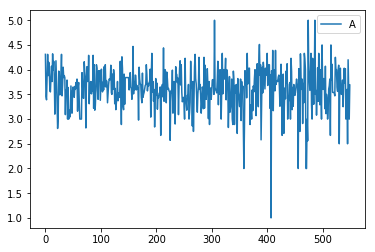

In [464]:
pd.DataFrame(y_train,columns=["A"]).plot()

## Train

In [465]:
import keras
import tensorflow as tf
from keras.layers import *
from keras.optimizers import Adam

model = keras.Sequential()
# model.add(Dropout(0.2, input_shape=(23, 1)))
# model.add(LSTM(units=28))
# model.add(LSTM(units=28, input_shape=(23, 1)))
model.add(Dense(16, activation='relu',kernel_initializer="uniform", input_shape=(23, 1)))
model.add(Dense(32, activation='relu', kernel_initializer="uniform"))
model.add(Dense(64, activation='relu', kernel_initializer="uniform"))
model.add(Dense(32, activation='relu', kernel_initializer="uniform"))
model.add(Dense(8, activation='relu', kernel_initializer="uniform"))
model.add(Flatten())
model.add(Dense(1, kernel_initializer="uniform"))
# model.add(Activation("relu"))
adam = Adam(lr=0.001)

In [466]:
# model.compile(optimizer="sgd",loss='mean_squared_error',metrics=['mae', 'mse'])
model.compile(optimizer=adam,loss='mean_squared_error',metrics=['mae', 'mse'])

In [467]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 23, 16)            32        
_________________________________________________________________
dense_75 (Dense)             (None, 23, 32)            544       
_________________________________________________________________
dense_76 (Dense)             (None, 23, 64)            2112      
_________________________________________________________________
dense_77 (Dense)             (None, 23, 32)            2080      
_________________________________________________________________
dense_78 (Dense)             (None, 23, 8)             264       
_________________________________________________________________
flatten_15 (Flatten)         (None, 184)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 185       
Total para

In [476]:
x_train_norm = x_train_norm.reshape(-1, 23, 1)
x_test_norm = x_test_norm.reshape(-1,23,1)
model.fit(np.append(x_train_norm,x_test_norm, axis=0), np.append(y_train_norm,y_test_norm, axis=0), batch_size=64, epochs=10000)

Epoch 1/10000
566/566 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0773 - mean_squared_error: 0.01 - 0s 99us/step - loss: 0.0107 - mean_absolute_error: 0.0785 - mean_squared_error: 0.0107
Epoch 2/10000
566/566 [==============================] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0906 - mean_squared_error: 0.01 - 0s 106us/step - loss: 0.0107 - mean_absolute_error: 0.0784 - mean_squared_error: 0.0107
Epoch 3/10000
566/566 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0827 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0106 - mean_absolute_error: 0.0776 - mean_squared_error: 0.0106
Epoch 4/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0663 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0108 - mean_absolute_error: 0.0786 - mean_squared_error: 0.0108
Epoch 5/10000
566/566 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute

Epoch 37/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0647 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0106 - mean_absolute_error: 0.0779 - mean_squared_error: 0.0106
Epoch 38/10000
566/566 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0794 - mean_squared_error: 0.01 - 0s 100us/step - loss: 0.0105 - mean_absolute_error: 0.0776 - mean_squared_error: 0.0105
Epoch 39/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0784 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0106 - mean_absolute_error: 0.0777 - mean_squared_error: 0.0106
Epoch 40/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0750 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0105 - mean_absolute_error: 0.0780 - mean_squared_error: 0.0105
Epoch 41/10000
566/566 [==============================] - ETA: 0s - loss: 0.0142 - mean_abs

Epoch 109/10000
566/566 [==============================] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.0800 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0106 - mean_absolute_error: 0.0778 - mean_squared_error: 0.0106
Epoch 110/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0696 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0106 - mean_absolute_error: 0.0774 - mean_squared_error: 0.0106
Epoch 111/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0657 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0106 - mean_absolute_error: 0.0783 - mean_squared_error: 0.0106
Epoch 112/10000
566/566 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0790 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0105 - mean_absolute_error: 0.0776 - mean_squared_error: 0.0105
Epoch 113/10000
566/566 [==============================] - ETA: 0s - loss: 0.0129 - mean

Epoch 145/10000
566/566 [==============================] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0839 - mean_squared_error: 0.01 - 0s 102us/step - loss: 0.0105 - mean_absolute_error: 0.0776 - mean_squared_error: 0.0105
Epoch 146/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0774 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0105 - mean_absolute_error: 0.0774 - mean_squared_error: 0.0105
Epoch 147/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0815 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0106 - mean_absolute_error: 0.0777 - mean_squared_error: 0.0106
Epoch 148/10000
566/566 [==============================] - ETA: 0s - loss: 0.0154 - mean_absolute_error: 0.0912 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0105 - mean_absolute_error: 0.0776 - mean_squared_error: 0.0105
Epoch 149/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 - mea

Epoch 181/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0646 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0106 - mean_absolute_error: 0.0778 - mean_squared_error: 0.0106
Epoch 182/10000
566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0721 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0106 - mean_absolute_error: 0.0784 - mean_squared_error: 0.0106
Epoch 183/10000
566/566 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0599 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0107 - mean_absolute_error: 0.0783 - mean_squared_error: 0.0107
Epoch 184/10000
566/566 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0799 - mean_squared_error: 0.01 - 0s 85us/step - loss: 0.0105 - mean_absolute_error: 0.0772 - mean_squared_error: 0.0105
Epoch 185/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean

Epoch 217/10000
566/566 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0699 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0106 - mean_absolute_error: 0.0781 - mean_squared_error: 0.0106
Epoch 218/10000
566/566 [==============================] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0853 - mean_squared_error: 0.01 - 0s 93us/step - loss: 0.0105 - mean_absolute_error: 0.0773 - mean_squared_error: 0.0105
Epoch 219/10000
566/566 [==============================] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0797 - mean_squared_error: 0.01 - 0s 81us/step - loss: 0.0105 - mean_absolute_error: 0.0777 - mean_squared_error: 0.0105
Epoch 220/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0705 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0106 - mean_absolute_error: 0.0771 - mean_squared_error: 0.0106
Epoch 221/10000
566/566 [==============================] - ETA: 0s - loss: 0.0115 - mean

Epoch 253/10000
566/566 [==============================] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0897 - mean_squared_error: 0.01 - 0s 99us/step - loss: 0.0108 - mean_absolute_error: 0.0784 - mean_squared_error: 0.0108
Epoch 254/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0745 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0106 - mean_absolute_error: 0.0777 - mean_squared_error: 0.0106
Epoch 255/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0660 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0105 - mean_absolute_error: 0.0775 - mean_squared_error: 0.0105
Epoch 256/10000
566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0753 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0105 - mean_absolute_error: 0.0775 - mean_squared_error: 0.0105
Epoch 257/10000
566/566 [==============================] - ETA: 0s - loss: 0.0115 - mean

Epoch 289/10000
566/566 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0887 - mean_squared_error: 0.01 - 0s 93us/step - loss: 0.0106 - mean_absolute_error: 0.0779 - mean_squared_error: 0.0106
Epoch 290/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0645 - mean_squared_error: 0.00 - 0s 100us/step - loss: 0.0106 - mean_absolute_error: 0.0774 - mean_squared_error: 0.0106
Epoch 291/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0764 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0106 - mean_absolute_error: 0.0782 - mean_squared_error: 0.0106
Epoch 292/10000
566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0767 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0106 - mean_absolute_error: 0.0773 - mean_squared_error: 0.0106
Epoch 293/10000
566/566 [==============================] - ETA: 0s - loss: 0.0135 - mea

Epoch 325/10000
566/566 [==============================] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0964 - mean_squared_error: 0.01 - 0s 93us/step - loss: 0.0108 - mean_absolute_error: 0.0787 - mean_squared_error: 0.0108
Epoch 326/10000
566/566 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0797 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0106 - mean_absolute_error: 0.0783 - mean_squared_error: 0.0106
Epoch 327/10000
566/566 [==============================] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.0875 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0106 - mean_absolute_error: 0.0778 - mean_squared_error: 0.0106
Epoch 328/10000
566/566 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0827 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0107 - mean_absolute_error: 0.0782 - mean_squared_error: 0.0107
Epoch 329/10000
566/566 [==============================] - ETA: 0s - loss: 0.0105 - mean

Epoch 396/10000
566/566 [==============================] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0851 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0106 - mean_absolute_error: 0.0778 - mean_squared_error: 0.0106
Epoch 397/10000
566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0815 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0105 - mean_absolute_error: 0.0774 - mean_squared_error: 0.0105
Epoch 398/10000
566/566 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0778 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0105 - mean_absolute_error: 0.0776 - mean_squared_error: 0.0105
Epoch 399/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0699 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0105 - mean_absolute_error: 0.0776 - mean_squared_error: 0.0105
Epoch 400/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean

Epoch 432/10000
566/566 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0862 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0106 - mean_absolute_error: 0.0780 - mean_squared_error: 0.0106
Epoch 433/10000
566/566 [==============================] - ETA: 0s - loss: 0.0118 - mean_absolute_error: 0.0813 - mean_squared_error: 0.01 - 0s 93us/step - loss: 0.0105 - mean_absolute_error: 0.0778 - mean_squared_error: 0.0105
Epoch 434/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0715 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0106 - mean_absolute_error: 0.0777 - mean_squared_error: 0.0106
Epoch 435/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0785 - mean_squared_error: 0.00 - 0s 100us/step - loss: 0.0106 - mean_absolute_error: 0.0788 - mean_squared_error: 0.0106
Epoch 436/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mea

Epoch 468/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0685 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0105 - mean_absolute_error: 0.0775 - mean_squared_error: 0.0105
Epoch 469/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0734 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0106 - mean_absolute_error: 0.0784 - mean_squared_error: 0.0106
Epoch 470/10000
566/566 [==============================] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.0815 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0105 - mean_absolute_error: 0.0774 - mean_squared_error: 0.0105
Epoch 471/10000
566/566 [==============================] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0842 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0105 - mean_absolute_error: 0.0780 - mean_squared_error: 0.0105
Epoch 472/10000
566/566 [==============================] - ETA: 0s - loss: 0.0104 - mean

Epoch 539/10000
566/566 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0806 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0103 - mean_absolute_error: 0.0771 - mean_squared_error: 0.0103
Epoch 540/10000
566/566 [==============================] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0986 - mean_squared_error: 0.01 - 0s 92us/step - loss: 0.0103 - mean_absolute_error: 0.0775 - mean_squared_error: 0.0103
Epoch 541/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0696 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0104 - mean_absolute_error: 0.0776 - mean_squared_error: 0.0104
Epoch 542/10000
566/566 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0785 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0103 - mean_absolute_error: 0.0772 - mean_squared_error: 0.0103
Epoch 543/10000
566/566 [==============================] - ETA: 0s - loss: 0.0115 - mean

Epoch 575/10000
566/566 [==============================] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0859 - mean_squared_error: 0.01 - 0s 95us/step - loss: 0.0102 - mean_absolute_error: 0.0767 - mean_squared_error: 0.0102
Epoch 576/10000
566/566 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0779 - mean_squared_error: 0.01 - 0s 97us/step - loss: 0.0102 - mean_absolute_error: 0.0769 - mean_squared_error: 0.0102
Epoch 577/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0716 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0102 - mean_absolute_error: 0.0771 - mean_squared_error: 0.0102
Epoch 578/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0722 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0103 - mean_absolute_error: 0.0771 - mean_squared_error: 0.0103
Epoch 579/10000
566/566 [==============================] - ETA: 0s - loss: 0.0106 - mean

Epoch 611/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0769 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0103 - mean_absolute_error: 0.0779 - mean_squared_error: 0.0103
Epoch 612/10000
566/566 [==============================] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0867 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0103 - mean_absolute_error: 0.0770 - mean_squared_error: 0.0103
Epoch 613/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0814 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0101 - mean_absolute_error: 0.0768 - mean_squared_error: 0.0101
Epoch 614/10000
566/566 [==============================] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.0825 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0101 - mean_absolute_error: 0.0769 - mean_squared_error: 0.0101
Epoch 615/10000
566/566 [==============================] - ETA: 0s - loss: 0.0126 - mean

Epoch 647/10000
566/566 [==============================] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0835 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0101 - mean_absolute_error: 0.0764 - mean_squared_error: 0.0101
Epoch 648/10000
566/566 [==============================] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0862 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0100 - mean_absolute_error: 0.0762 - mean_squared_error: 0.0100
Epoch 649/10000
566/566 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0752 - mean_squared_error: 0.01 - 0s 85us/step - loss: 0.0101 - mean_absolute_error: 0.0768 - mean_squared_error: 0.0101
Epoch 650/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0751 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0103 - mean_absolute_error: 0.0774 - mean_squared_error: 0.0103
Epoch 651/10000
566/566 [==============================] - ETA: 0s - loss: 0.0105 - mean

Epoch 683/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0764 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0099 - mean_absolute_error: 0.0761 - mean_squared_error: 0.0099
Epoch 684/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0684 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0100 - mean_absolute_error: 0.0761 - mean_squared_error: 0.0100
Epoch 685/10000
566/566 [==============================] - ETA: 0s - loss: 0.0118 - mean_absolute_error: 0.0784 - mean_squared_error: 0.01 - 0s 83us/step - loss: 0.0099 - mean_absolute_error: 0.0760 - mean_squared_error: 0.0099
Epoch 686/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0724 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0100 - mean_absolute_error: 0.0765 - mean_squared_error: 0.0100
Epoch 687/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 - mean

Epoch 719/10000
566/566 [==============================] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0856 - mean_squared_error: 0.01 - 0s 92us/step - loss: 0.0099 - mean_absolute_error: 0.0758 - mean_squared_error: 0.0099
Epoch 720/10000
566/566 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0803 - mean_squared_error: 0.01 - 0s 85us/step - loss: 0.0099 - mean_absolute_error: 0.0761 - mean_squared_error: 0.0099
Epoch 721/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0782 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0099 - mean_absolute_error: 0.0757 - mean_squared_error: 0.0099
Epoch 722/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0100 - mean_absolute_error: 0.0771 - mean_squared_error: 0.0100
Epoch 723/10000
566/566 [==============================] - ETA: 0s - loss: 0.0113 - mean

Epoch 755/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0746 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0098 - mean_absolute_error: 0.0755 - mean_squared_error: 0.0098
Epoch 756/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0724 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0098 - mean_absolute_error: 0.0760 - mean_squared_error: 0.0098
Epoch 757/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0733 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0099 - mean_absolute_error: 0.0757 - mean_squared_error: 0.0099
Epoch 758/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0639 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0098 - mean_absolute_error: 0.0756 - mean_squared_error: 0.0098
Epoch 759/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean

Epoch 791/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0750 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0099 - mean_absolute_error: 0.0766 - mean_squared_error: 0.0099
Epoch 792/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0601 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0098 - mean_absolute_error: 0.0762 - mean_squared_error: 0.0098
Epoch 793/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0714 - mean_squared_error: 0.01 - 0s 85us/step - loss: 0.0097 - mean_absolute_error: 0.0752 - mean_squared_error: 0.0097
Epoch 794/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0724 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0098 - mean_absolute_error: 0.0761 - mean_squared_error: 0.0098
Epoch 795/10000
566/566 [==============================] - ETA: 0s - loss: 0.0113 - mean

Epoch 862/10000
566/566 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0761 - mean_squared_error: 0.01 - 0s 85us/step - loss: 0.0097 - mean_absolute_error: 0.0752 - mean_squared_error: 0.0097
Epoch 863/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0662 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0096 - mean_absolute_error: 0.0751 - mean_squared_error: 0.0096
Epoch 864/10000
566/566 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0814 - mean_squared_error: 0.01 - 0s 83us/step - loss: 0.0099 - mean_absolute_error: 0.0763 - mean_squared_error: 0.0099
Epoch 865/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0756 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0097 - mean_absolute_error: 0.0755 - mean_squared_error: 0.0097
Epoch 866/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean

Epoch 898/10000
566/566 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0742 - mean_squared_error: 0.01 - 0s 74us/step - loss: 0.0097 - mean_absolute_error: 0.0755 - mean_squared_error: 0.0097
Epoch 899/10000
566/566 [==============================] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0848 - mean_squared_error: 0.01 - 0s 79us/step - loss: 0.0098 - mean_absolute_error: 0.0752 - mean_squared_error: 0.0098
Epoch 900/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0766 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0097 - mean_absolute_error: 0.0753 - mean_squared_error: 0.0097
Epoch 901/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0823 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0097 - mean_absolute_error: 0.0751 - mean_squared_error: 0.0097
Epoch 902/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean

Epoch 969/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0714 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0097 - mean_absolute_error: 0.0747 - mean_squared_error: 0.0097
Epoch 970/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0738 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0097 - mean_absolute_error: 0.0755 - mean_squared_error: 0.0097
Epoch 971/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0719 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0096 - mean_absolute_error: 0.0748 - mean_squared_error: 0.0096
Epoch 972/10000
566/566 [==============================] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0786 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0097 - mean_absolute_error: 0.0754 - mean_squared_error: 0.0097
Epoch 973/10000
566/566 [==============================] - ETA: 0s - loss: 0.0119 - mean

Epoch 1005/10000
566/566 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0819 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0100 - mean_absolute_error: 0.0774 - mean_squared_error: 0.0100
Epoch 1006/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0754 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0098 - mean_absolute_error: 0.0746 - mean_squared_error: 0.0098
Epoch 1007/10000
566/566 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0858 - mean_squared_error: 0.01 - 0s 79us/step - loss: 0.0098 - mean_absolute_error: 0.0761 - mean_squared_error: 0.0098
Epoch 1008/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0756 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0097 - mean_absolute_error: 0.0752 - mean_squared_error: 0.0097
Epoch 1009/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 -

Epoch 1041/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0724 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0099 - mean_absolute_error: 0.0756 - mean_squared_error: 0.0099
Epoch 1042/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0716 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0097 - mean_absolute_error: 0.0754 - mean_squared_error: 0.0097
Epoch 1043/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0818 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0096 - mean_absolute_error: 0.0747 - mean_squared_error: 0.0096
Epoch 1044/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0650 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0097 - mean_absolute_error: 0.0751 - mean_squared_error: 0.0097
Epoch 1045/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 -

Epoch 1077/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0761 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0096 - mean_absolute_error: 0.0751 - mean_squared_error: 0.0096
Epoch 1078/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0672 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0097 - mean_absolute_error: 0.0754 - mean_squared_error: 0.0097
Epoch 1079/10000
566/566 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0855 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0098 - mean_absolute_error: 0.0760 - mean_squared_error: 0.0098
Epoch 1080/10000
566/566 [==============================] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0799 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0097 - mean_absolute_error: 0.0758 - mean_squared_error: 0.0097
Epoch 1081/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 -

Epoch 1113/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0788 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0098 - mean_absolute_error: 0.0755 - mean_squared_error: 0.0098
Epoch 1114/10000
566/566 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0807 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0096 - mean_absolute_error: 0.0749 - mean_squared_error: 0.0096
Epoch 1115/10000
566/566 [==============================] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0896 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0097 - mean_absolute_error: 0.0752 - mean_squared_error: 0.0097
Epoch 1116/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0747 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0097 - mean_absolute_error: 0.0752 - mean_squared_error: 0.0097
Epoch 1117/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 -

Epoch 1149/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0784 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0097 - mean_absolute_error: 0.0751 - mean_squared_error: 0.0097
Epoch 1150/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0734 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0098 - mean_absolute_error: 0.0757 - mean_squared_error: 0.0098
Epoch 1151/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0744 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0097 - mean_absolute_error: 0.0748 - mean_squared_error: 0.0097
Epoch 1152/10000
566/566 [==============================] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0866 - mean_squared_error: 0.01 - 0s 83us/step - loss: 0.0097 - mean_absolute_error: 0.0754 - mean_squared_error: 0.0097
Epoch 1153/10000
566/566 [==============================] - ETA: 0s - loss: 0.0141 -

Epoch 1185/10000
566/566 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0579 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0096 - mean_absolute_error: 0.0750 - mean_squared_error: 0.0096
Epoch 1186/10000
566/566 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0531 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0096 - mean_absolute_error: 0.0754 - mean_squared_error: 0.0096
Epoch 1187/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0647 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0097 - mean_absolute_error: 0.0753 - mean_squared_error: 0.0097
Epoch 1188/10000
566/566 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0774 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0097 - mean_absolute_error: 0.0749 - mean_squared_error: 0.0097
Epoch 1189/10000
566/566 [==============================] - ETA: 0s - loss: 0.0106 -

Epoch 1221/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0761 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0096 - mean_absolute_error: 0.0751 - mean_squared_error: 0.0096
Epoch 1222/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0680 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0725 - mean_squared_error: 0.00 - 0s 132us/step - loss: 0.0096 - mean_absolute_error: 0.0750 - mean_squared_error: 0.0096
Epoch 1223/10000
566/566 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0762 - mean_squared_error: 0.01 - 0s 85us/step - loss: 0.0096 - mean_absolute_error: 0.0750 - mean_squared_error: 0.0096
Epoch 1224/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0759 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0097 - mean_absolute_error: 0.0755 - mean_squared_error: 0.0097
E

Epoch 1292/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0714 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0096 - mean_absolute_error: 0.0748 - mean_squared_error: 0.0096
Epoch 1293/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0719 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0096 - mean_absolute_error: 0.0751 - mean_squared_error: 0.0096
Epoch 1294/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0637 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0096 - mean_absolute_error: 0.0748 - mean_squared_error: 0.0096
Epoch 1295/10000
566/566 [==============================] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.0808 - mean_squared_error: 0.01 - 0s 83us/step - loss: 0.0096 - mean_absolute_error: 0.0751 - mean_squared_error: 0.0096
Epoch 1296/10000
566/566 [==============================] - ETA: 0s - loss: 0.0121 -

Epoch 1328/10000
566/566 [==============================] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0842 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0095 - mean_absolute_error: 0.0746 - mean_squared_error: 0.0095
Epoch 1329/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0766 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0095 - mean_absolute_error: 0.0745 - mean_squared_error: 0.0095
Epoch 1330/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0785 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0095 - mean_absolute_error: 0.0745 - mean_squared_error: 0.0095
Epoch 1331/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0630 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0096 - mean_absolute_error: 0.0751 - mean_squared_error: 0.0096
Epoch 1332/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 -

Epoch 1364/10000
566/566 [==============================] - ETA: 0s - loss: 0.0120 - mean_absolute_error: 0.0803 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0096 - mean_absolute_error: 0.0747 - mean_squared_error: 0.0096
Epoch 1365/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0728 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0097 - mean_absolute_error: 0.0758 - mean_squared_error: 0.0097
Epoch 1366/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0634 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0096 - mean_absolute_error: 0.0746 - mean_squared_error: 0.0096
Epoch 1367/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0718 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0095 - mean_absolute_error: 0.0746 - mean_squared_error: 0.0095
Epoch 1368/10000
566/566 [==============================] - ETA: 0s - loss: 0.0117 -

Epoch 1400/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0599 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0099 - mean_absolute_error: 0.0767 - mean_squared_error: 0.0099
Epoch 1401/10000
566/566 [==============================] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0826 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0096 - mean_absolute_error: 0.0745 - mean_squared_error: 0.0096
Epoch 1402/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0718 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0095 - mean_absolute_error: 0.0747 - mean_squared_error: 0.0095
Epoch 1403/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0699 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0095 - mean_absolute_error: 0.0741 - mean_squared_error: 0.0095
Epoch 1404/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 -

Epoch 1436/10000
566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0792 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0094 - mean_absolute_error: 0.0742 - mean_squared_error: 0.0094
Epoch 1437/10000
566/566 [==============================] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0868 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0094 - mean_absolute_error: 0.0745 - mean_squared_error: 0.0094
Epoch 1438/10000
566/566 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0821 - mean_squared_error: 0.01 - 0s 81us/step - loss: 0.0094 - mean_absolute_error: 0.0741 - mean_squared_error: 0.0094
Epoch 1439/10000
566/566 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0796 - mean_squared_error: 0.01 - 0s 79us/step - loss: 0.0095 - mean_absolute_error: 0.0745 - mean_squared_error: 0.0095
Epoch 1440/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 -

Epoch 1472/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0686 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0093 - mean_absolute_error: 0.0740 - mean_squared_error: 0.0093
Epoch 1473/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0640 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0094 - mean_absolute_error: 0.0741 - mean_squared_error: 0.0094
Epoch 1474/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0701 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0094 - mean_absolute_error: 0.0746 - mean_squared_error: 0.0094
Epoch 1475/10000
566/566 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0833 - mean_squared_error: 0.01 - 0s 92us/step - loss: 0.0095 - mean_absolute_error: 0.0743 - mean_squared_error: 0.0095
Epoch 1476/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 -

Epoch 1543/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0782 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0094 - mean_absolute_error: 0.0743 - mean_squared_error: 0.0094
Epoch 1544/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0755 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0093 - mean_absolute_error: 0.0745 - mean_squared_error: 0.0093
Epoch 1545/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0705 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0093 - mean_absolute_error: 0.0741 - mean_squared_error: 0.0093
Epoch 1546/10000
566/566 [==============================] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0867 - mean_squared_error: 0.01 - 0s 92us/step - loss: 0.0093 - mean_absolute_error: 0.0741 - mean_squared_error: 0.0093
Epoch 1547/10000
566/566 [==============================] - ETA: 0s - loss: 0.0100 -

Epoch 1579/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0698 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0094 - mean_absolute_error: 0.0750 - mean_squared_error: 0.0094
Epoch 1580/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0664 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0095 - mean_absolute_error: 0.0752 - mean_squared_error: 0.0095
Epoch 1581/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0786 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0095 - mean_absolute_error: 0.0745 - mean_squared_error: 0.0095
Epoch 1582/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0647 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0093 - mean_absolute_error: 0.0740 - mean_squared_error: 0.0093
Epoch 1583/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 -

Epoch 1615/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0714 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0092 - mean_absolute_error: 0.0744 - mean_squared_error: 0.0092
Epoch 1616/10000
566/566 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0813 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0095 - mean_absolute_error: 0.0759 - mean_squared_error: 0.0095
Epoch 1617/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0707 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0093 - mean_absolute_error: 0.0737 - mean_squared_error: 0.0093
Epoch 1618/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0742 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0093 - mean_absolute_error: 0.0745 - mean_squared_error: 0.0093
Epoch 1619/10000
566/566 [==============================] - ETA: 0s - loss: 0.0153 -

Epoch 1651/10000
566/566 [==============================] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0860 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0093 - mean_absolute_error: 0.0743 - mean_squared_error: 0.0093
Epoch 1652/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0711 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0093 - mean_absolute_error: 0.0741 - mean_squared_error: 0.0093
Epoch 1653/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0715 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0093 - mean_absolute_error: 0.0745 - mean_squared_error: 0.0093
Epoch 1654/10000
566/566 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0911 - mean_squared_error: 0.01 - 0s 83us/step - loss: 0.0092 - mean_absolute_error: 0.0735 - mean_squared_error: 0.0092
Epoch 1655/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 -

Epoch 1687/10000
566/566 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0769 - mean_squared_error: 0.01 - 0s 92us/step - loss: 0.0092 - mean_absolute_error: 0.0740 - mean_squared_error: 0.0092
Epoch 1688/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0674 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0092 - mean_absolute_error: 0.0735 - mean_squared_error: 0.0092
Epoch 1689/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0692 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0093 - mean_absolute_error: 0.0743 - mean_squared_error: 0.0093
Epoch 1690/10000
566/566 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0790 - mean_squared_error: 0.01 - 0s 85us/step - loss: 0.0095 - mean_absolute_error: 0.0759 - mean_squared_error: 0.0095
Epoch 1691/10000
566/566 [==============================] - ETA: 0s - loss: 0.0103 -

Epoch 1723/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0773 - mean_squared_error: 0.01 - 0s 95us/step - loss: 0.0092 - mean_absolute_error: 0.0742 - mean_squared_error: 0.0092
Epoch 1724/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0715 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0094 - mean_absolute_error: 0.0745 - mean_squared_error: 0.0094
Epoch 1725/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0732 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0095 - mean_absolute_error: 0.0750 - mean_squared_error: 0.0095
Epoch 1726/10000
566/566 [==============================] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0929 - mean_squared_error: 0.01 - 0s 83us/step - loss: 0.0093 - mean_absolute_error: 0.0749 - mean_squared_error: 0.0093
Epoch 1727/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 -

Epoch 1759/10000
566/566 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0825 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0094 - mean_absolute_error: 0.0743 - mean_squared_error: 0.0094
Epoch 1760/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0614 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0092 - mean_absolute_error: 0.0741 - mean_squared_error: 0.0092
Epoch 1761/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0707 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0092 - mean_absolute_error: 0.0737 - mean_squared_error: 0.0092
Epoch 1762/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0696 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0094 - mean_absolute_error: 0.0750 - mean_squared_error: 0.0094
Epoch 1763/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 -

Epoch 1795/10000
566/566 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0751 - mean_squared_error: 0.01 - 0s 92us/step - loss: 0.0092 - mean_absolute_error: 0.0743 - mean_squared_error: 0.0092
Epoch 1796/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0754 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0091 - mean_absolute_error: 0.0732 - mean_squared_error: 0.0091
Epoch 1797/10000
566/566 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0802 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0093 - mean_absolute_error: 0.0741 - mean_squared_error: 0.0093
Epoch 1798/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0747 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0092 - mean_absolute_error: 0.0736 - mean_squared_error: 0.0092
Epoch 1799/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 -

Epoch 1831/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0732 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0092 - mean_absolute_error: 0.0735 - mean_squared_error: 0.0092
Epoch 1832/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0659 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0093 - mean_absolute_error: 0.0741 - mean_squared_error: 0.0093
Epoch 1833/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0671 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0091 - mean_absolute_error: 0.0740 - mean_squared_error: 0.0091
Epoch 1834/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0628 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0090 - mean_absolute_error: 0.0729 - mean_squared_error: 0.0090
Epoch 1835/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 -

Epoch 1867/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0681 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0091 - mean_absolute_error: 0.0734 - mean_squared_error: 0.0091
Epoch 1868/10000
566/566 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0765 - mean_squared_error: 0.01 - 0s 85us/step - loss: 0.0091 - mean_absolute_error: 0.0731 - mean_squared_error: 0.0091
Epoch 1869/10000
566/566 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0744 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0091 - mean_absolute_error: 0.0734 - mean_squared_error: 0.0091
Epoch 1870/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0756 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0091 - mean_absolute_error: 0.0739 - mean_squared_error: 0.0091
Epoch 1871/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 -

Epoch 1903/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0700 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0095 - mean_absolute_error: 0.0759 - mean_squared_error: 0.0095
Epoch 1904/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0709 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0093 - mean_absolute_error: 0.0748 - mean_squared_error: 0.0093
Epoch 1905/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0676 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0091 - mean_absolute_error: 0.0733 - mean_squared_error: 0.0091
Epoch 1906/10000
566/566 [==============================] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.0824 - mean_squared_error: 0.01 - 0s 92us/step - loss: 0.0091 - mean_absolute_error: 0.0736 - mean_squared_error: 0.0091
Epoch 1907/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 -

Epoch 1939/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0783 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0091 - mean_absolute_error: 0.0731 - mean_squared_error: 0.0091
Epoch 1940/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0703 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0090 - mean_absolute_error: 0.0735 - mean_squared_error: 0.0090
Epoch 1941/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0653 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0090 - mean_absolute_error: 0.0732 - mean_squared_error: 0.0090
Epoch 1942/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0751 - mean_squared_error: 0.01 - 0s 83us/step - loss: 0.0091 - mean_absolute_error: 0.0735 - mean_squared_error: 0.0091
Epoch 1943/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 -

Epoch 1975/10000
566/566 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0593 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0091 - mean_absolute_error: 0.0741 - mean_squared_error: 0.0091
Epoch 1976/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0726 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0093 - mean_absolute_error: 0.0739 - mean_squared_error: 0.0093
Epoch 1977/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0716 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0090 - mean_absolute_error: 0.0733 - mean_squared_error: 0.0090
Epoch 1978/10000
566/566 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0793 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0090 - mean_absolute_error: 0.0729 - mean_squared_error: 0.0090
Epoch 1979/10000
566/566 [==============================] - ETA: 0s - loss: 0.0051 

Epoch 2011/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0717 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0092 - mean_absolute_error: 0.0744 - mean_squared_error: 0.0092
Epoch 2012/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0760 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0092 - mean_absolute_error: 0.0738 - mean_squared_error: 0.0092
Epoch 2013/10000
566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0685 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0090 - mean_absolute_error: 0.0732 - mean_squared_error: 0.0090
Epoch 2014/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0710 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0090 - mean_absolute_error: 0.0730 - mean_squared_error: 0.0090
Epoch 2015/10000
566/566 [==============================] - ETA: 0s - loss: 0.0110 -

Epoch 2047/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0703 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0092 - mean_absolute_error: 0.0739 - mean_squared_error: 0.0092
Epoch 2048/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0677 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0092 - mean_absolute_error: 0.0742 - mean_squared_error: 0.0092
Epoch 2049/10000
566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0775 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0090 - mean_absolute_error: 0.0728 - mean_squared_error: 0.0090
Epoch 2050/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0796 - mean_squared_error: 0.01 - 0s 81us/step - loss: 0.0090 - mean_absolute_error: 0.0727 - mean_squared_error: 0.0090
Epoch 2051/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 -

Epoch 2083/10000
566/566 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0693 - mean_squared_error: 0.01 - 0s 83us/step - loss: 0.0091 - mean_absolute_error: 0.0736 - mean_squared_error: 0.0091
Epoch 2084/10000
566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0785 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0089 - mean_absolute_error: 0.0726 - mean_squared_error: 0.0089
Epoch 2085/10000
566/566 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0540 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0089 - mean_absolute_error: 0.0724 - mean_squared_error: 0.0089
Epoch 2086/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0664 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0093 - mean_absolute_error: 0.0745 - mean_squared_error: 0.0093
Epoch 2087/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 -

Epoch 2119/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0579 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0091 - mean_absolute_error: 0.0739 - mean_squared_error: 0.0091
Epoch 2120/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0678 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0090 - mean_absolute_error: 0.0735 - mean_squared_error: 0.0090
Epoch 2121/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0650 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0090 - mean_absolute_error: 0.0731 - mean_squared_error: 0.0090
Epoch 2122/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0756 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0094 - mean_absolute_error: 0.0755 - mean_squared_error: 0.0094
Epoch 2123/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 -

Epoch 2155/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0752 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0091 - mean_absolute_error: 0.0733 - mean_squared_error: 0.0091
Epoch 2156/10000
566/566 [==============================] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.0846 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0089 - mean_absolute_error: 0.0732 - mean_squared_error: 0.0089
Epoch 2157/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0707 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0089 - mean_absolute_error: 0.0727 - mean_squared_error: 0.0089
Epoch 2158/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0657 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0088 - mean_absolute_error: 0.0726 - mean_squared_error: 0.0088
Epoch 2159/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 -

Epoch 2191/10000
566/566 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0806 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0089 - mean_absolute_error: 0.0733 - mean_squared_error: 0.0089
Epoch 2192/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0639 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0090 - mean_absolute_error: 0.0733 - mean_squared_error: 0.0090
Epoch 2193/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0640 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0088 - mean_absolute_error: 0.0721 - mean_squared_error: 0.0088
Epoch 2194/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0686 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0088 - mean_absolute_error: 0.0725 - mean_squared_error: 0.0088
Epoch 2195/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 -

Epoch 2227/10000
566/566 [==============================] - ETA: 0s - loss: 0.0120 - mean_absolute_error: 0.0780 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0088 - mean_absolute_error: 0.0723 - mean_squared_error: 0.0088
Epoch 2228/10000
566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0752 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0088 - mean_absolute_error: 0.0727 - mean_squared_error: 0.0088
Epoch 2229/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0676 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0088 - mean_absolute_error: 0.0726 - mean_squared_error: 0.0088
Epoch 2230/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0695 - mean_squared_error: 0.00 - 0s 79us/step - loss: 0.0089 - mean_absolute_error: 0.0726 - mean_squared_error: 0.0089
Epoch 2231/10000
566/566 [==============================] - ETA: 0s - loss: 0.0101 -

Epoch 2263/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0693 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0089 - mean_absolute_error: 0.0732 - mean_squared_error: 0.0089
Epoch 2264/10000
566/566 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0731 - mean_squared_error: 0.01 - 0s 93us/step - loss: 0.0087 - mean_absolute_error: 0.0715 - mean_squared_error: 0.0087
Epoch 2265/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0667 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0090 - mean_absolute_error: 0.0730 - mean_squared_error: 0.0090
Epoch 2266/10000
566/566 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0770 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0092 - mean_absolute_error: 0.0747 - mean_squared_error: 0.0092
Epoch 2267/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 -

Epoch 2299/10000
566/566 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0740 - mean_squared_error: 0.01 - 0s 85us/step - loss: 0.0090 - mean_absolute_error: 0.0727 - mean_squared_error: 0.0090
Epoch 2300/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0754 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0089 - mean_absolute_error: 0.0728 - mean_squared_error: 0.0089
Epoch 2301/10000
566/566 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0717 - mean_squared_error: 0.01 - 0s 85us/step - loss: 0.0088 - mean_absolute_error: 0.0725 - mean_squared_error: 0.0088
Epoch 2302/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0699 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0088 - mean_absolute_error: 0.0717 - mean_squared_error: 0.0088
Epoch 2303/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 -

Epoch 2335/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0639 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0088 - mean_absolute_error: 0.0720 - mean_squared_error: 0.0088
Epoch 2336/10000
566/566 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0764 - mean_squared_error: 0.01 - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0703 - mean_squared_error: 0.00 - 0s 134us/step - loss: 0.0088 - mean_absolute_error: 0.0720 - mean_squared_error: 0.0088
Epoch 2337/10000
566/566 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0779 - mean_squared_error: 0.01 - 0s 97us/step - loss: 0.0088 - mean_absolute_error: 0.0725 - mean_squared_error: 0.0088
Epoch 2338/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0698 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0086 - mean_absolute_error: 0.0713 - mean_squared_error: 0.0086
E

Epoch 2370/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0739 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0088 - mean_absolute_error: 0.0722 - mean_squared_error: 0.0088
Epoch 2371/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0765 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0087 - mean_absolute_error: 0.0716 - mean_squared_error: 0.0087
Epoch 2372/10000
566/566 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0778 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0087 - mean_absolute_error: 0.0720 - mean_squared_error: 0.0087
Epoch 2373/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0707 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0087 - mean_absolute_error: 0.0716 - mean_squared_error: 0.0087
Epoch 2374/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 

Epoch 2406/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0684 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0087 - mean_absolute_error: 0.0719 - mean_squared_error: 0.0087
Epoch 2407/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0591 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0087 - mean_absolute_error: 0.0718 - mean_squared_error: 0.0087
Epoch 2408/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0645 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0088 - mean_absolute_error: 0.0718 - mean_squared_error: 0.0088
Epoch 2409/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0690 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0088 - mean_absolute_error: 0.0719 - mean_squared_error: 0.0088
Epoch 2410/10000
566/566 [==============================] - ETA: 0s - loss: 0.0051 -

Epoch 2477/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0639 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0087 - mean_absolute_error: 0.0720 - mean_squared_error: 0.0087
Epoch 2478/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0740 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0087 - mean_absolute_error: 0.0717 - mean_squared_error: 0.0087
Epoch 2479/10000
566/566 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0829 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0086 - mean_absolute_error: 0.0715 - mean_squared_error: 0.0086
Epoch 2480/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0604 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0086 - mean_absolute_error: 0.0714 - mean_squared_error: 0.0086
Epoch 2481/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 -

Epoch 2513/10000
566/566 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0820 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0087 - mean_absolute_error: 0.0718 - mean_squared_error: 0.0087
Epoch 2514/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0749 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0091 - mean_absolute_error: 0.0748 - mean_squared_error: 0.0091
Epoch 2515/10000
566/566 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0750 - mean_squared_error: 0.01 - 0s 83us/step - loss: 0.0090 - mean_absolute_error: 0.0731 - mean_squared_error: 0.0090
Epoch 2516/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0770 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0085 - mean_absolute_error: 0.0712 - mean_squared_error: 0.0085
Epoch 2517/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 -

Epoch 2549/10000
566/566 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0867 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0088 - mean_absolute_error: 0.0719 - mean_squared_error: 0.0088
Epoch 2550/10000
566/566 [==============================] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.0873 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0088 - mean_absolute_error: 0.0719 - mean_squared_error: 0.0088
Epoch 2551/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0776 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0087 - mean_absolute_error: 0.0721 - mean_squared_error: 0.0087
Epoch 2552/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0710 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0086 - mean_absolute_error: 0.0712 - mean_squared_error: 0.0086
Epoch 2553/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 -

Epoch 2585/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0743 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0087 - mean_absolute_error: 0.0715 - mean_squared_error: 0.0087
Epoch 2586/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0673 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0088 - mean_absolute_error: 0.0718 - mean_squared_error: 0.0088
Epoch 2587/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0717 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0087 - mean_absolute_error: 0.0719 - mean_squared_error: 0.0087
Epoch 2588/10000
566/566 [==============================] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0807 - mean_squared_error: 0.01 - 0s 83us/step - loss: 0.0086 - mean_absolute_error: 0.0712 - mean_squared_error: 0.0086
Epoch 2589/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 -

Epoch 2621/10000
566/566 [==============================] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0857 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0087 - mean_absolute_error: 0.0716 - mean_squared_error: 0.0087
Epoch 2622/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0661 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0086 - mean_absolute_error: 0.0712 - mean_squared_error: 0.0086
Epoch 2623/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0738 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0086 - mean_absolute_error: 0.0712 - mean_squared_error: 0.0086
Epoch 2624/10000
566/566 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0601 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0738 - mean_squared_error: 0.00 - 0s 136us/step - loss: 0.0086 - mean_absolute_error: 0.0717 - mean_squared_error: 0.0086
E

Epoch 2692/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0745 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0089 - mean_absolute_error: 0.0731 - mean_squared_error: 0.0089
Epoch 2693/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0751 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0090 - mean_absolute_error: 0.0730 - mean_squared_error: 0.0090
Epoch 2694/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0751 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0088 - mean_absolute_error: 0.0725 - mean_squared_error: 0.0088
Epoch 2695/10000
566/566 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0732 - mean_squared_error: 0.01 - 0s 83us/step - loss: 0.0087 - mean_absolute_error: 0.0714 - mean_squared_error: 0.0087
Epoch 2696/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 -

Epoch 2728/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0682 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0085 - mean_absolute_error: 0.0710 - mean_squared_error: 0.0085
Epoch 2729/10000
566/566 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0842 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0086 - mean_absolute_error: 0.0717 - mean_squared_error: 0.0086
Epoch 2730/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0686 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0087 - mean_absolute_error: 0.0717 - mean_squared_error: 0.0087
Epoch 2731/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0809 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0086 - mean_absolute_error: 0.0713 - mean_squared_error: 0.0086
Epoch 2732/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 -

Epoch 2764/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0589 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0085 - mean_absolute_error: 0.0712 - mean_squared_error: 0.0085
Epoch 2765/10000
566/566 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0711 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0085 - mean_absolute_error: 0.0709 - mean_squared_error: 0.0085
Epoch 2766/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0721 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0086 - mean_absolute_error: 0.0707 - mean_squared_error: 0.0086
Epoch 2767/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0734 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0086 - mean_absolute_error: 0.0710 - mean_squared_error: 0.0086
Epoch 2768/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 -

Epoch 2800/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0675 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0085 - mean_absolute_error: 0.0709 - mean_squared_error: 0.0085
Epoch 2801/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0710 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0086 - mean_absolute_error: 0.0706 - mean_squared_error: 0.0086
Epoch 2802/10000
566/566 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0789 - mean_squared_error: 0.01 - 0s 81us/step - loss: 0.0088 - mean_absolute_error: 0.0730 - mean_squared_error: 0.0088
Epoch 2803/10000
566/566 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0782 - mean_squared_error: 0.01 - 0s 79us/step - loss: 0.0089 - mean_absolute_error: 0.0723 - mean_squared_error: 0.0089
Epoch 2804/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 -

Epoch 2836/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0670 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0086 - mean_absolute_error: 0.0709 - mean_squared_error: 0.0086
Epoch 2837/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0702 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0088 - mean_absolute_error: 0.0718 - mean_squared_error: 0.0088
Epoch 2838/10000
566/566 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0785 - mean_squared_error: 0.01 - 0s 83us/step - loss: 0.0088 - mean_absolute_error: 0.0720 - mean_squared_error: 0.0088
Epoch 2839/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0705 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0088 - mean_absolute_error: 0.0715 - mean_squared_error: 0.0088
Epoch 2840/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 -

Epoch 2872/10000
566/566 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0772 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0086 - mean_absolute_error: 0.0714 - mean_squared_error: 0.0086
Epoch 2873/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0662 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0084 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0084
Epoch 2874/10000
566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0758 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0085 - mean_absolute_error: 0.0710 - mean_squared_error: 0.0085
Epoch 2875/10000
566/566 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0807 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0085 - mean_absolute_error: 0.0709 - mean_squared_error: 0.0085
Epoch 2876/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 -

Epoch 2908/10000
566/566 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0840 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0086 - mean_absolute_error: 0.0714 - mean_squared_error: 0.0086
Epoch 2909/10000
566/566 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0816 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0084 - mean_absolute_error: 0.0710 - mean_squared_error: 0.0084
Epoch 2910/10000
566/566 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0578 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0085 - mean_absolute_error: 0.0709 - mean_squared_error: 0.0085
Epoch 2911/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0640 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0085 - mean_absolute_error: 0.0707 - mean_squared_error: 0.0085
Epoch 2912/10000
566/566 [==============================] - ETA: 0s - loss: 0.0052 -

Epoch 2944/10000
566/566 [==============================] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.0786 - mean_squared_error: 0.01 - 0s 93us/step - loss: 0.0084 - mean_absolute_error: 0.0706 - mean_squared_error: 0.0084
Epoch 2945/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0682 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0084 - mean_absolute_error: 0.0706 - mean_squared_error: 0.0084
Epoch 2946/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0732 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0086 - mean_absolute_error: 0.0712 - mean_squared_error: 0.0086
Epoch 2947/10000
566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0768 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0085 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0085
Epoch 2948/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 -

Epoch 2980/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0760 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0085 - mean_absolute_error: 0.0706 - mean_squared_error: 0.0085
Epoch 2981/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0701 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0085 - mean_absolute_error: 0.0709 - mean_squared_error: 0.0085
Epoch 2982/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0664 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0085 - mean_absolute_error: 0.0707 - mean_squared_error: 0.0085
Epoch 2983/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0769 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0085 - mean_absolute_error: 0.0707 - mean_squared_error: 0.0085
Epoch 2984/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 -

Epoch 3016/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0800 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0085 - mean_absolute_error: 0.0705 - mean_squared_error: 0.0085
Epoch 3017/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0726 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0088 - mean_absolute_error: 0.0718 - mean_squared_error: 0.0088
Epoch 3018/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0718 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0086 - mean_absolute_error: 0.0713 - mean_squared_error: 0.0086
Epoch 3019/10000
566/566 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0602 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0086 - mean_absolute_error: 0.0708 - mean_squared_error: 0.0086
Epoch 3020/10000
566/566 [==============================] - ETA: 0s - loss: 0.0121 -

Epoch 3052/10000
566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0711 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0085 - mean_absolute_error: 0.0716 - mean_squared_error: 0.0085
Epoch 3053/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0706 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0087 - mean_absolute_error: 0.0711 - mean_squared_error: 0.0087
Epoch 3054/10000
566/566 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0819 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0087 - mean_absolute_error: 0.0716 - mean_squared_error: 0.0087
Epoch 3055/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0685 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0089 - mean_absolute_error: 0.0718 - mean_squared_error: 0.0089
Epoch 3056/10000
566/566 [==============================] - ETA: 0s - loss: 0.0125 

Epoch 3088/10000
566/566 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0603 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0085 - mean_absolute_error: 0.0709 - mean_squared_error: 0.0085
Epoch 3089/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0631 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0084 - mean_absolute_error: 0.0706 - mean_squared_error: 0.0084
Epoch 3090/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0745 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0084 - mean_absolute_error: 0.0708 - mean_squared_error: 0.0084
Epoch 3091/10000
566/566 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0849 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0085 - mean_absolute_error: 0.0702 - mean_squared_error: 0.0085
Epoch 3092/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 -

Epoch 3124/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0646 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0084 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0084
Epoch 3125/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0710 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0084 - mean_absolute_error: 0.0707 - mean_squared_error: 0.0084
Epoch 3126/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0750 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0084 - mean_absolute_error: 0.0707 - mean_squared_error: 0.0084
Epoch 3127/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0688 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0085 - mean_absolute_error: 0.0715 - mean_squared_error: 0.0085
Epoch 3128/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 -

Epoch 3160/10000
566/566 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0836 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0702 - mean_squared_error: 0.0083
Epoch 3161/10000
566/566 [==============================] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0768 - mean_squared_error: 0.01 - 0s 92us/step - loss: 0.0084 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0084
Epoch 3162/10000
566/566 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0563 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0084 - mean_absolute_error: 0.0705 - mean_squared_error: 0.0084
Epoch 3163/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0770 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0084 - mean_absolute_error: 0.0703 - mean_squared_error: 0.0084
Epoch 3164/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 -

Epoch 3194/10000
566/566 [==============================] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0802 - mean_squared_error: 0.01 - 0s 100us/step - loss: 0.0083 - mean_absolute_error: 0.0703 - mean_squared_error: 0.0083
Epoch 3195/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0733 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0084 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0084
Epoch 3196/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0683 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0083 - mean_absolute_error: 0.0702 - mean_squared_error: 0.0083
Epoch 3197/10000
566/566 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0580 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0685 - mean_squared_error: 0.00 - 0s 125us/step - loss: 0.0083 - mean_absolute_error: 0.0699 - mean_squared_error: 0.008

566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0689 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0084 - mean_absolute_error: 0.0706 - mean_squared_error: 0.0084
Epoch 3264/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0589 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0085 - mean_absolute_error: 0.0706 - mean_squared_error: 0.0085
Epoch 3265/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0695 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0083
Epoch 3266/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0716 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0085 - mean_absolute_error: 0.0710 - mean_squared_error: 0.0085
Epoch 3267/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_er

Epoch 3299/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0667 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0083 - mean_absolute_error: 0.0699 - mean_squared_error: 0.0083
Epoch 3300/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0721 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0083 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0083
Epoch 3301/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0728 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0084 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0084
Epoch 3302/10000
566/566 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0562 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0083 - mean_absolute_error: 0.0703 - mean_squared_error: 0.0083
Epoch 3303/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 -

Epoch 3335/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0745 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0085 - mean_absolute_error: 0.0706 - mean_squared_error: 0.0085
Epoch 3336/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0652 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0702 - mean_squared_error: 0.0083
Epoch 3337/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0717 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0083
Epoch 3338/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0666 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0083 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0083
Epoch 3339/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 -

Epoch 3371/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0748 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0084 - mean_absolute_error: 0.0702 - mean_squared_error: 0.0084
Epoch 3372/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0673 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0083 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0083
Epoch 3373/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0700 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0083
Epoch 3374/10000
566/566 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0818 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0699 - mean_squared_error: 0.0083
Epoch 3375/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 -

Epoch 3407/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0727 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0084 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0084
Epoch 3408/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0669 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0084 - mean_absolute_error: 0.0702 - mean_squared_error: 0.0084
Epoch 3409/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0720 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0084 - mean_absolute_error: 0.0706 - mean_squared_error: 0.0084
Epoch 3410/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0659 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0084 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0084
Epoch 3411/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 -

Epoch 3443/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0717 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0085 - mean_absolute_error: 0.0708 - mean_squared_error: 0.0085
Epoch 3444/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0695 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0701 - mean_squared_error: 0.0083
Epoch 3445/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0670 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0084 - mean_absolute_error: 0.0703 - mean_squared_error: 0.0084
Epoch 3446/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0647 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0083 - mean_absolute_error: 0.0702 - mean_squared_error: 0.0083
Epoch 3447/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 -

Epoch 3479/10000
566/566 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0577 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0083 - mean_absolute_error: 0.0697 - mean_squared_error: 0.0083
Epoch 3480/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0759 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0085 - mean_absolute_error: 0.0707 - mean_squared_error: 0.0085
Epoch 3481/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0725 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0085 - mean_absolute_error: 0.0709 - mean_squared_error: 0.0085
Epoch 3482/10000
566/566 [==============================] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0874 - mean_squared_error: 0.01 - 0s 81us/step - loss: 0.0084 - mean_absolute_error: 0.0703 - mean_squared_error: 0.0084
Epoch 3483/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 

Epoch 3515/10000
566/566 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0768 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0703 - mean_squared_error: 0.0083
Epoch 3516/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0662 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0086 - mean_absolute_error: 0.0707 - mean_squared_error: 0.0086
Epoch 3517/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0724 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0085 - mean_absolute_error: 0.0708 - mean_squared_error: 0.0085
Epoch 3518/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0602 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0084 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0084
Epoch 3519/10000
566/566 [==============================] - ETA: 0s - loss: 0.0064 -

Epoch 3551/10000
566/566 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0652 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0083 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0083
Epoch 3552/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0661 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0084 - mean_absolute_error: 0.0699 - mean_squared_error: 0.0084
Epoch 3553/10000
566/566 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0818 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0084 - mean_absolute_error: 0.0707 - mean_squared_error: 0.0084
Epoch 3554/10000
566/566 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0755 - mean_squared_error: 0.01 - 0s 85us/step - loss: 0.0083 - mean_absolute_error: 0.0702 - mean_squared_error: 0.0083
Epoch 3555/10000
566/566 [==============================] - ETA: 0s - loss: 0.0107 -

Epoch 3587/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0598 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0085 - mean_absolute_error: 0.0707 - mean_squared_error: 0.0085
Epoch 3588/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0674 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0089 - mean_absolute_error: 0.0715 - mean_squared_error: 0.0089
Epoch 3589/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0680 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0085 - mean_absolute_error: 0.0710 - mean_squared_error: 0.0085
Epoch 3590/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0727 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0084 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0084
Epoch 3591/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 -

Epoch 3623/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0722 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0083 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0083
Epoch 3624/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0801 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0084 - mean_absolute_error: 0.0701 - mean_squared_error: 0.0084
Epoch 3625/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0580 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0083 - mean_absolute_error: 0.0699 - mean_squared_error: 0.0083
Epoch 3626/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0638 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0084 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0084
Epoch 3627/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 -

Epoch 3659/10000
566/566 [==============================] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.0859 - mean_squared_error: 0.01 - 0s 85us/step - loss: 0.0084 - mean_absolute_error: 0.0705 - mean_squared_error: 0.0084
Epoch 3660/10000
566/566 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0859 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0083 - mean_absolute_error: 0.0697 - mean_squared_error: 0.0083
Epoch 3661/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0707 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0083 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0083
Epoch 3662/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0716 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0084 - mean_absolute_error: 0.0706 - mean_squared_error: 0.0084
Epoch 3663/10000
566/566 [==============================] - ETA: 0s - loss: 0.0113 -

Epoch 3695/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0664 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0082 - mean_absolute_error: 0.0697 - mean_squared_error: 0.0082
Epoch 3696/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0719 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0083 - mean_absolute_error: 0.0702 - mean_squared_error: 0.0083
Epoch 3697/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0702 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0083 - mean_absolute_error: 0.0703 - mean_squared_error: 0.0083
Epoch 3698/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0713 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0087 - mean_absolute_error: 0.0713 - mean_squared_error: 0.0087
Epoch 3699/10000
566/566 [==============================] - ETA: 0s - loss: 0.0119 

Epoch 3731/10000
566/566 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0797 - mean_squared_error: 0.01 - 0s 93us/step - loss: 0.0083 - mean_absolute_error: 0.0701 - mean_squared_error: 0.0083
Epoch 3732/10000
566/566 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0593 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0085 - mean_absolute_error: 0.0709 - mean_squared_error: 0.0085
Epoch 3733/10000
566/566 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0760 - mean_squared_error: 0.01 - 0s 95us/step - loss: 0.0083 - mean_absolute_error: 0.0699 - mean_squared_error: 0.0083
Epoch 3734/10000
566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0736 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0711 - mean_squared_error: 0.00 - 0s 130us/step - loss: 0.0083 - mean_absolute_error: 0.0701 - mean_squared_error: 0.0083
E

Epoch 3802/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0628 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0083 - mean_absolute_error: 0.0699 - mean_squared_error: 0.0083
Epoch 3803/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0721 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0083 - mean_absolute_error: 0.0702 - mean_squared_error: 0.0083
Epoch 3804/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0686 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0083 - mean_absolute_error: 0.0696 - mean_squared_error: 0.0083
Epoch 3805/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0704 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0084 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0084
Epoch 3806/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 -

Epoch 3838/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0576 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0082 - mean_absolute_error: 0.0697 - mean_squared_error: 0.0082
Epoch 3839/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0755 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0082 - mean_absolute_error: 0.0695 - mean_squared_error: 0.0082
Epoch 3840/10000
566/566 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0807 - mean_squared_error: 0.01 - 0s 99us/step - loss: 0.0083 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0083
Epoch 3841/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0724 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0083 - mean_absolute_error: 0.0701 - mean_squared_error: 0.0083
Epoch 3842/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 -

Epoch 3874/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0738 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0083 - mean_absolute_error: 0.0699 - mean_squared_error: 0.0083
Epoch 3875/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0661 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0083
Epoch 3876/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0730 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0085 - mean_absolute_error: 0.0701 - mean_squared_error: 0.0085
Epoch 3877/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0722 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0085 - mean_absolute_error: 0.0718 - mean_squared_error: 0.0085
Epoch 3878/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 -

Epoch 3910/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0744 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0086 - mean_absolute_error: 0.0709 - mean_squared_error: 0.0086
Epoch 3911/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0705 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0086 - mean_absolute_error: 0.0719 - mean_squared_error: 0.0086
Epoch 3912/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0793 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0696 - mean_squared_error: 0.0083
Epoch 3913/10000
566/566 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0774 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0088 - mean_absolute_error: 0.0717 - mean_squared_error: 0.0088
Epoch 3914/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 -

Epoch 3946/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0633 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0082 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0082
Epoch 3947/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0650 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0082 - mean_absolute_error: 0.0696 - mean_squared_error: 0.0082
Epoch 3948/10000
566/566 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0754 - mean_squared_error: 0.01 - 0s 92us/step - loss: 0.0082 - mean_absolute_error: 0.0697 - mean_squared_error: 0.0082
Epoch 3949/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0759 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0082 - mean_absolute_error: 0.0694 - mean_squared_error: 0.0082
Epoch 3950/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 -

Epoch 3982/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0638 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0083
Epoch 3983/10000
566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0728 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0085 - mean_absolute_error: 0.0705 - mean_squared_error: 0.0085
Epoch 3984/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0758 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0082 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0082
Epoch 3985/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0645 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0084 - mean_absolute_error: 0.0705 - mean_squared_error: 0.0084
Epoch 3986/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 -

Epoch 4018/10000
566/566 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0601 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0084 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0084
Epoch 4019/10000
566/566 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0581 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0696 - mean_squared_error: 0.0083
Epoch 4020/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0688 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0082 - mean_absolute_error: 0.0695 - mean_squared_error: 0.0082
Epoch 4021/10000
566/566 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0826 - mean_squared_error: 0.01 - 0s 93us/step - loss: 0.0083 - mean_absolute_error: 0.0702 - mean_squared_error: 0.0083
Epoch 4022/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 -

Epoch 4054/10000
566/566 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0582 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0083
Epoch 4055/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0715 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0084 - mean_absolute_error: 0.0705 - mean_squared_error: 0.0084
Epoch 4056/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0715 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0084 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0084
Epoch 4057/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0617 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0085 - mean_absolute_error: 0.0708 - mean_squared_error: 0.0085
Epoch 4058/10000
566/566 [==============================] - ETA: 0s - loss: 0.0064 -

Epoch 4090/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0659 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0082 - mean_absolute_error: 0.0694 - mean_squared_error: 0.0082
Epoch 4091/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0675 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0082 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0082
Epoch 4092/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0704 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0083 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0083
Epoch 4093/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0694 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0082 - mean_absolute_error: 0.0696 - mean_squared_error: 0.0082
Epoch 4094/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 -

Epoch 4126/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0755 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0084 - mean_absolute_error: 0.0702 - mean_squared_error: 0.0084
Epoch 4127/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0713 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0082 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0082
Epoch 4128/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0698 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0082 - mean_absolute_error: 0.0696 - mean_squared_error: 0.0082
Epoch 4129/10000
566/566 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0804 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0695 - mean_squared_error: 0.0083
Epoch 4130/10000
566/566 [==============================] - ETA: 0s - loss: 0.0113 -

Epoch 4162/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0736 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0083 - mean_absolute_error: 0.0701 - mean_squared_error: 0.0083
Epoch 4163/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0667 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0082 - mean_absolute_error: 0.0695 - mean_squared_error: 0.0082
Epoch 4164/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0683 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0081 - mean_absolute_error: 0.0695 - mean_squared_error: 0.0081
Epoch 4165/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0727 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0082 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0082
Epoch 4166/10000
566/566 [==============================] - ETA: 0s - loss: 0.0100 -

Epoch 4198/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0691 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0697 - mean_squared_error: 0.0083
Epoch 4199/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0701 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0082 - mean_absolute_error: 0.0694 - mean_squared_error: 0.0082
Epoch 4200/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0706 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0081 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0081
Epoch 4201/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0706 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0082 - mean_absolute_error: 0.0701 - mean_squared_error: 0.0082
Epoch 4202/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 -

Epoch 4234/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0637 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0082 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0082
Epoch 4235/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0653 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0082 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0082
Epoch 4236/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0678 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0701 - mean_squared_error: 0.0083
Epoch 4237/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0684 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0083 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0083
Epoch 4238/10000
566/566 [==============================] - ETA: 0s - loss: 0.0056 -

Epoch 4270/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0668 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0082 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0082
Epoch 4271/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0591 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0081 - mean_absolute_error: 0.0690 - mean_squared_error: 0.0081
Epoch 4272/10000
566/566 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0811 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0082 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0082
Epoch 4273/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0671 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0081 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0081
Epoch 4274/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 -

Epoch 4306/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0699 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0082 - mean_absolute_error: 0.0696 - mean_squared_error: 0.0082
Epoch 4307/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0732 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0082 - mean_absolute_error: 0.0697 - mean_squared_error: 0.0082
Epoch 4308/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0745 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0081 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0081
Epoch 4309/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0791 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0081 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0081
Epoch 4310/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 -

Epoch 4342/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0763 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0081 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0081
Epoch 4343/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0768 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0081 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0081
Epoch 4344/10000
566/566 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0751 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0080 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0080
Epoch 4345/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0681 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0081 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0081
Epoch 4346/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 -

Epoch 4378/10000
566/566 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0609 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0083
Epoch 4379/10000
566/566 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0768 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0084 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0084
Epoch 4380/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0723 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0083 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0083
Epoch 4381/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0727 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0089 - mean_absolute_error: 0.0716 - mean_squared_error: 0.0089
Epoch 4382/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 -

Epoch 4414/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0764 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0081 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0081
Epoch 4415/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0730 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0082 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0082
Epoch 4416/10000
566/566 [==============================] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0803 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0081 - mean_absolute_error: 0.0690 - mean_squared_error: 0.0081
Epoch 4417/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0629 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0080 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0080
Epoch 4418/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 -

Epoch 4450/10000
566/566 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0719 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0081 - mean_absolute_error: 0.0696 - mean_squared_error: 0.0081
Epoch 4451/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0772 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0081 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0081
Epoch 4452/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0634 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0080 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0080
Epoch 4453/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0729 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0081 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0081
Epoch 4454/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 -

Epoch 4486/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0747 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0086 - mean_absolute_error: 0.0701 - mean_squared_error: 0.0086
Epoch 4487/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0720 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0084 - mean_absolute_error: 0.0705 - mean_squared_error: 0.0084
Epoch 4488/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0662 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0081 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0081
Epoch 4489/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0687 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0081 - mean_absolute_error: 0.0694 - mean_squared_error: 0.0081
Epoch 4490/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 -

Epoch 4522/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0697 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0082 - mean_absolute_error: 0.0694 - mean_squared_error: 0.0082
Epoch 4523/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0587 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0085 - mean_absolute_error: 0.0706 - mean_squared_error: 0.0085
Epoch 4524/10000
566/566 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0592 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0081 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0081
Epoch 4525/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0642 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0081 - mean_absolute_error: 0.0690 - mean_squared_error: 0.0081
Epoch 4526/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 -

Epoch 4558/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0628 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0081 - mean_absolute_error: 0.0694 - mean_squared_error: 0.0081
Epoch 4559/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0722 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0080 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0080
Epoch 4560/10000
566/566 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0791 - mean_squared_error: 0.01 - 0s 95us/step - loss: 0.0080 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0080
Epoch 4561/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0636 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0080 - mean_absolute_error: 0.0690 - mean_squared_error: 0.0080
Epoch 4562/10000
566/566 [==============================] - ETA: 0s - loss: 0.0103 -

Epoch 4594/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0642 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0081 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0081
Epoch 4595/10000
566/566 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0560 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0081 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0081
Epoch 4596/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0753 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0080 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0080
Epoch 4597/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0718 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0081 - mean_absolute_error: 0.0694 - mean_squared_error: 0.0081
Epoch 4598/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 -

Epoch 4630/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0632 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0081 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0081
Epoch 4631/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0712 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0081 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0081
Epoch 4632/10000
566/566 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0833 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0080 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0080
Epoch 4633/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0631 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0080 - mean_absolute_error: 0.0685 - mean_squared_error: 0.0080
Epoch 4634/10000
566/566 [==============================] - ETA: 0s - loss: 0.0061 -

Epoch 4666/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0702 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0080 - mean_absolute_error: 0.0685 - mean_squared_error: 0.0080
Epoch 4667/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0685 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0083 - mean_absolute_error: 0.0695 - mean_squared_error: 0.0083
Epoch 4668/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0697 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0081 - mean_absolute_error: 0.0696 - mean_squared_error: 0.0081
Epoch 4669/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0693 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0082 - mean_absolute_error: 0.0699 - mean_squared_error: 0.0082
Epoch 4670/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 -

Epoch 4702/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0626 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0082 - mean_absolute_error: 0.0694 - mean_squared_error: 0.0082
Epoch 4703/10000
566/566 [==============================] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0868 - mean_squared_error: 0.01 - 0s 81us/step - loss: 0.0082 - mean_absolute_error: 0.0695 - mean_squared_error: 0.0082
Epoch 4704/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0663 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0080 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0080
Epoch 4705/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0673 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0079 - mean_absolute_error: 0.0685 - mean_squared_error: 0.0079
Epoch 4706/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 -

Epoch 4738/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0623 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0081 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0081
Epoch 4739/10000
566/566 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0745 - mean_squared_error: 0.01 - 0s 88us/step - loss: 0.0080 - mean_absolute_error: 0.0690 - mean_squared_error: 0.0080
Epoch 4740/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0702 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0080 - mean_absolute_error: 0.0690 - mean_squared_error: 0.0080
Epoch 4741/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0672 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0080 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0080
Epoch 4742/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 -

Epoch 4774/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0727 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0081 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0081
Epoch 4775/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0688 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0080 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0080
Epoch 4776/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0702 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0080 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0080
Epoch 4777/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0723 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0080 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0080
Epoch 4778/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 -

Epoch 4810/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0640 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0081 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0081
Epoch 4811/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0765 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0080 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0080
Epoch 4812/10000
566/566 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0597 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0079 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0079
Epoch 4813/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0621 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0080 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0080
Epoch 4814/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 -

Epoch 4846/10000
566/566 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0779 - mean_squared_error: 0.01 - 0s 85us/step - loss: 0.0079 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0079
Epoch 4847/10000
566/566 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0798 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0080 - mean_absolute_error: 0.0690 - mean_squared_error: 0.0080
Epoch 4848/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0619 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0080 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0080
Epoch 4849/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0635 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0079 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0079
Epoch 4850/10000
566/566 [==============================] - ETA: 0s - loss: 0.0111 -

Epoch 4882/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0671 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0080 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0080
Epoch 4883/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0714 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0081 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0081
Epoch 4884/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0626 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0082 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0082
Epoch 4885/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0752 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0081 - mean_absolute_error: 0.0690 - mean_squared_error: 0.0081
Epoch 4886/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 -

Epoch 4918/10000
566/566 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0569 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0081 - mean_absolute_error: 0.0690 - mean_squared_error: 0.0081
Epoch 4919/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0618 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0080 - mean_absolute_error: 0.0695 - mean_squared_error: 0.0080
Epoch 4920/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0718 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0079 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0079
Epoch 4921/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0621 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0080 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0080
Epoch 4922/10000
566/566 [==============================] - ETA: 0s - loss: 0.0101 -

Epoch 4954/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0653 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0082 - mean_absolute_error: 0.0695 - mean_squared_error: 0.0082
Epoch 4955/10000
566/566 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0814 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0081 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0081
Epoch 4956/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0707 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0080 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0080
Epoch 4957/10000
566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0721 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0080 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0080
Epoch 4958/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 -

Epoch 4990/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0714 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0082 - mean_absolute_error: 0.0697 - mean_squared_error: 0.0082
Epoch 4991/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0749 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0081 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0081
Epoch 4992/10000
566/566 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0781 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0080 - mean_absolute_error: 0.0690 - mean_squared_error: 0.0080
Epoch 4993/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0696 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0079 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0079
Epoch 4994/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 

Epoch 5026/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0666 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0079 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0079
Epoch 5027/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0754 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0081 - mean_absolute_error: 0.0697 - mean_squared_error: 0.0081
Epoch 5028/10000
566/566 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0778 - mean_squared_error: 0.01 - 0s 97us/step - loss: 0.0080 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0080
Epoch 5029/10000
566/566 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0561 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0079 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0079
Epoch 5030/10000
566/566 [==============================] - ETA: 0s - loss: 0.0114 

Epoch 5062/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0759 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0088 - mean_absolute_error: 0.0705 - mean_squared_error: 0.0088
Epoch 5063/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0693 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0080 - mean_absolute_error: 0.0690 - mean_squared_error: 0.0080
Epoch 5064/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0608 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0081 - mean_absolute_error: 0.0695 - mean_squared_error: 0.0081
Epoch 5065/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0699 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0080 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0080
Epoch 5066/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 -

Epoch 5098/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0641 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0079 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0079
Epoch 5099/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0743 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0079 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0079
Epoch 5100/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0710 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0078 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0078
Epoch 5101/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0752 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0079 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0079
Epoch 5102/10000
566/566 [==============================] - ETA: 0s - loss: 0.0064 -

Epoch 5134/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0599 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0080 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0080
Epoch 5135/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0695 - mean_squared_error: 0.00 - 0s 100us/step - loss: 0.0079 - mean_absolute_error: 0.0685 - mean_squared_error: 0.0079
Epoch 5136/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0723 - mean_squared_error: 0.00 - 0s 78us/step - loss: 0.0079 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0079
Epoch 5137/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0704 - mean_squared_error: 0.00 - 0s 79us/step - loss: 0.0079 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0079
Epoch 5138/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 

Epoch 5170/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0693 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0083 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0083
Epoch 5171/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0616 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0082 - mean_absolute_error: 0.0696 - mean_squared_error: 0.0082
Epoch 5172/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0715 - mean_squared_error: 0.00 - 0s 83us/step - loss: 0.0082 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0082
Epoch 5173/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0770 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0083 - mean_absolute_error: 0.0705 - mean_squared_error: 0.0083
Epoch 5174/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 -

Epoch 5206/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0695 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0079 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0079
Epoch 5207/10000
566/566 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0760 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0080 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0080
Epoch 5208/10000
566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0677 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0080 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0080
Epoch 5209/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0645 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0085 - mean_absolute_error: 0.0707 - mean_squared_error: 0.0085
Epoch 5210/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 -

Epoch 5242/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0734 - mean_squared_error: 0.00 - 0s 81us/step - loss: 0.0079 - mean_absolute_error: 0.0682 - mean_squared_error: 0.0079
Epoch 5243/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0708 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0080 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0080
Epoch 5244/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0718 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0079 - mean_absolute_error: 0.0682 - mean_squared_error: 0.0079
Epoch 5245/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0758 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0079 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0079
Epoch 5246/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 -

Epoch 5278/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0701 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0079 - mean_absolute_error: 0.0690 - mean_squared_error: 0.0079
Epoch 5279/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0707 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0079 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0079
Epoch 5280/10000
566/566 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0638 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0079 - mean_absolute_error: 0.0685 - mean_squared_error: 0.0079
Epoch 5281/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0788 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0078 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0078
Epoch 5282/10000
566/566 [==============================] - ETA: 0s - loss: 0.0116 -

Epoch 5314/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0683 - mean_squared_error: 0.00 - 0s 88us/step - loss: 0.0079 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0079
Epoch 5315/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0664 - mean_squared_error: 0.00 - 0s 85us/step - loss: 0.0079 - mean_absolute_error: 0.0682 - mean_squared_error: 0.0079
Epoch 5316/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0691 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0079 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0079
Epoch 5317/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0692 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0079 - mean_absolute_error: 0.0685 - mean_squared_error: 0.0079
Epoch 5318/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 -

566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0772 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0081 - mean_absolute_error: 0.0694 - mean_squared_error: 0.0081
Epoch 5384/10000
566/566 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0553 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0671 - mean_squared_error: 0.00 - 0s 127us/step - loss: 0.0079 - mean_absolute_error: 0.0683 - mean_squared_error: 0.0079
Epoch 5385/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0690 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0080 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0080
Epoch 5386/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0643 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0081 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0081
Epoch 5387/1000

566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0685 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0079 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0079
Epoch 5449/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0650 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0078 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0078
Epoch 5450/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0588 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0684 - mean_squared_error: 0.00 - 0s 127us/step - loss: 0.0081 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0081
Epoch 5451/10000
566/566 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0613 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0079 - mean_absolute_error: 0.0690 - mean_squared_error: 0.0079
Epoch 5452/1000

566/566 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0856 - mean_squared_error: 0.01 - 0s 111us/step - loss: 0.0080 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0080
Epoch 5509/10000
566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0741 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0696 - mean_squared_error: 0.00 - 0s 127us/step - loss: 0.0080 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0080
Epoch 5510/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0799 - mean_squared_error: 0.00 - 0s 116us/step - loss: 0.0080 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0080
Epoch 5511/10000
566/566 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0822 - mean_squared_error: 0.01 - 0s 109us/step - loss: 0.0081 - mean_absolute_error: 0.0696 - mean_squared_error: 0.0081
Epoch 5512/1000

Epoch 5541/10000
566/566 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0592 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0700 - mean_squared_error: 0.00 - 0s 130us/step - loss: 0.0078 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0078
Epoch 5542/10000
566/566 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0575 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0679 - mean_squared_error: 0.00 - 0s 130us/step - loss: 0.0078 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0078
Epoch 5543/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0719 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0692 - mean_squared_error: 0.00 - 0s 130us/step - loss: 0.0080 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0080
Epoch 5544/10000
566/566 [==============================] - ETA:

566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0636 - mean_squared_error: 0.00 - 0s 116us/step - loss: 0.0078 - mean_absolute_error: 0.0679 - mean_squared_error: 0.0078
Epoch 5608/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0697 - mean_squared_error: 0.00 - 0s 100us/step - loss: 0.0078 - mean_absolute_error: 0.0683 - mean_squared_error: 0.0078
Epoch 5609/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0612 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0678 - mean_squared_error: 0.00 - 0s 123us/step - loss: 0.0078 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0078
Epoch 5610/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0774 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0078 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0078
Epoch 5611/1000

Epoch 5676/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0740 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0079 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0079
Epoch 5677/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0673 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0079 - mean_absolute_error: 0.0683 - mean_squared_error: 0.0079
Epoch 5678/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0755 - mean_squared_error: 0.00 - 0s 115us/step - loss: 0.0078 - mean_absolute_error: 0.0681 - mean_squared_error: 0.0078
Epoch 5679/10000
566/566 [==============================] - ETA: 0s - loss: 0.0118 - mean_absolute_error: 0.0831 - mean_squared_error: 0.01 - 0s 104us/step - loss: 0.0080 - mean_absolute_error: 0.0694 - mean_squared_error: 0.0080
Epoch 5680/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 5745/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0711 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0079 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0079
Epoch 5746/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0724 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0078 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0078
Epoch 5747/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0616 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0080 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0080
Epoch 5748/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0763 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0080 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0080
Epoch 5749/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 5814/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0655 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0078 - mean_absolute_error: 0.0681 - mean_squared_error: 0.0078
Epoch 5815/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0742 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0078 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0078
Epoch 5816/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0684 - mean_squared_error: 0.00 - 0s 120us/step - loss: 0.0079 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0079
Epoch 5817/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0665 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0079 - mean_absolute_error: 0.0685 - mean_squared_error: 0.0079
Epoch 5818/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 5850/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0598 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0077 - mean_absolute_error: 0.0677 - mean_squared_error: 0.0077
Epoch 5851/10000
566/566 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0763 - mean_squared_error: 0.01 - 0s 115us/step - loss: 0.0079 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0079
Epoch 5852/10000
566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0734 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0078 - mean_absolute_error: 0.0682 - mean_squared_error: 0.0078
Epoch 5853/10000
566/566 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0535 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0078 - mean_absolute_error: 0.0682 - mean_squared_error: 0.0078
Epoch 5854/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 5883/10000
566/566 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0803 - mean_squared_error: 0.01 - 0s 107us/step - loss: 0.0078 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0078
Epoch 5884/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0650 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0078 - mean_absolute_error: 0.0683 - mean_squared_error: 0.0078
Epoch 5885/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0656 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0079 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0079
Epoch 5886/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0699 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0078 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0078
Epoch 5887/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 5917/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0735 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0079 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0079
Epoch 5918/10000
566/566 [==============================] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.0833 - mean_squared_error: 0.01 - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0677 - mean_squared_error: 0.00 - 0s 137us/step - loss: 0.0077 - mean_absolute_error: 0.0679 - mean_squared_error: 0.0077
Epoch 5919/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0652 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0680 - mean_squared_error: 0.00 - 0s 136us/step - loss: 0.0078 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0078
Epoch 5920/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0682 - mean_squared_error: 0.00 - 0s 1

566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0716 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0078 - mean_absolute_error: 0.0678 - mean_squared_error: 0.0078
Epoch 5984/10000
566/566 [==============================] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.0821 - mean_squared_error: 0.01 - 0s 109us/step - loss: 0.0078 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0078
Epoch 5985/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0705 - mean_squared_error: 0.00 - 0s 118us/step - loss: 0.0079 - mean_absolute_error: 0.0685 - mean_squared_error: 0.0079
Epoch 5986/10000
566/566 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0564 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0079 - mean_absolute_error: 0.0685 - mean_squared_error: 0.0079
Epoch 5987/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolut

Epoch 6016/10000
566/566 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0576 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0668 - mean_squared_error: 0.00 - 0s 122us/step - loss: 0.0077 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0077
Epoch 6017/10000
566/566 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0578 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0078 - mean_absolute_error: 0.0678 - mean_squared_error: 0.0078
Epoch 6018/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0764 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0077 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0077
Epoch 6019/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0627 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0077 - mean_absolute_error: 0.0677 - mean_squared_error: 0.007

Epoch 6083/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0672 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0077 - mean_absolute_error: 0.0678 - mean_squared_error: 0.0077
Epoch 6084/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0614 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0078 - mean_absolute_error: 0.0683 - mean_squared_error: 0.0078
Epoch 6085/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0715 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0078 - mean_absolute_error: 0.0681 - mean_squared_error: 0.0078
Epoch 6086/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0703 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0078 - mean_absolute_error: 0.0685 - mean_squared_error: 0.0078
Epoch 6087/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 6152/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0716 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0077 - mean_absolute_error: 0.0681 - mean_squared_error: 0.0077
Epoch 6153/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0662 - mean_squared_error: 0.00 - 0s 115us/step - loss: 0.0079 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0079
Epoch 6154/10000
566/566 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0614 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0680 - mean_squared_error: 0.00 - 0s 127us/step - loss: 0.0078 - mean_absolute_error: 0.0685 - mean_squared_error: 0.0078
Epoch 6155/10000
566/566 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0717 - mean_squared_error: 0.00 - 0s 100us/step - loss: 0.0082 - mean_absolute_error: 0.0696 - mean_squared_error: 0.008

566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0690 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0078 - mean_absolute_error: 0.0683 - mean_squared_error: 0.0078
Epoch 6222/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0678 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0077 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0077
Epoch 6223/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0670 - mean_squared_error: 0.00 - 0s 116us/step - loss: 0.0077 - mean_absolute_error: 0.0676 - mean_squared_error: 0.0077
Epoch 6224/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0749 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0078 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0078
Epoch 6225/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolut

Epoch 6256/10000
566/566 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0596 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0078 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0078
Epoch 6257/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0692 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0077 - mean_absolute_error: 0.0678 - mean_squared_error: 0.0077
Epoch 6258/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0706 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0078 - mean_absolute_error: 0.0679 - mean_squared_error: 0.0078
Epoch 6259/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0637 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0078 - mean_absolute_error: 0.0677 - mean_squared_error: 0.0078
Epoch 6260/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 6326/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0635 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0076 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0076
Epoch 6327/10000
566/566 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0562 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0672 - mean_squared_error: 0.00 - 0s 122us/step - loss: 0.0077 - mean_absolute_error: 0.0676 - mean_squared_error: 0.0077
Epoch 6328/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0740 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0076 - mean_absolute_error: 0.0677 - mean_squared_error: 0.0076
Epoch 6329/10000
566/566 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0722 - mean_squared_error: 0.01 - 0s 107us/step - loss: 0.0077 - mean_absolute_error: 0.0681 - mean_squared_error: 0.007

Epoch 6394/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0682 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0077 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0077
Epoch 6395/10000
566/566 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0792 - mean_squared_error: 0.01 - 0s 102us/step - loss: 0.0079 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0079
Epoch 6396/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0639 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0685 - mean_squared_error: 0.00 - 0s 129us/step - loss: 0.0077 - mean_absolute_error: 0.0681 - mean_squared_error: 0.0077
Epoch 6397/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0695 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0076 - mean_absolute_error: 0.0669 - mean_squared_error: 0.007

566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0651 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0077 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0077
Epoch 6461/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0680 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0076 - mean_absolute_error: 0.0676 - mean_squared_error: 0.0076
Epoch 6462/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0618 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0677 - mean_squared_error: 0.00 - 0s 127us/step - loss: 0.0077 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0077
Epoch 6463/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0633 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0076 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0076
Epoch 6464/1000

Epoch 6494/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0700 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0079 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0079
Epoch 6495/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0754 - mean_squared_error: 0.00 - 0s 115us/step - loss: 0.0079 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0079
Epoch 6496/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0666 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0077 - mean_absolute_error: 0.0683 - mean_squared_error: 0.0077
Epoch 6497/10000
566/566 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0535 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0679 - mean_squared_error: 0.00 - 0s 127us/step - loss: 0.0076 - mean_absolute_error: 0.0673 - mean_squared_error: 0.007

Epoch 6527/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0709 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0082 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0082
Epoch 6528/10000
566/566 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0644 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0694 - mean_squared_error: 0.00 - 0s 130us/step - loss: 0.0081 - mean_absolute_error: 0.0699 - mean_squared_error: 0.0081
Epoch 6529/10000
566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0759 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0675 - mean_squared_error: 0.00 - 0s 129us/step - loss: 0.0080 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0080
Epoch 6530/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0715 - mean_squared_error: 0.00 - ETA:

Epoch 6594/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0658 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0077 - mean_absolute_error: 0.0678 - mean_squared_error: 0.0077
Epoch 6595/10000
566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0737 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0077 - mean_absolute_error: 0.0678 - mean_squared_error: 0.0077
Epoch 6596/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0700 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0076 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0076
Epoch 6597/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0623 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0076 - mean_absolute_error: 0.0674 - mean_squared_error: 0.0076
Epoch 6598/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0676 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0078 - mean_absolute_error: 0.0681 - mean_squared_error: 0.0078
Epoch 6664/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0718 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0079 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0079
Epoch 6665/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0692 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0076 - mean_absolute_error: 0.0678 - mean_squared_error: 0.0076
Epoch 6666/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0616 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0076 - mean_absolute_error: 0.0677 - mean_squared_error: 0.0076
Epoch 6667/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolut

Epoch 6732/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0741 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0077 - mean_absolute_error: 0.0677 - mean_squared_error: 0.0077
Epoch 6733/10000
566/566 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0608 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0078 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0078
Epoch 6734/10000
566/566 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0784 - mean_squared_error: 0.01 - 0s 107us/step - loss: 0.0078 - mean_absolute_error: 0.0679 - mean_squared_error: 0.0078
Epoch 6735/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0647 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0078 - mean_absolute_error: 0.0682 - mean_squared_error: 0.0078
Epoch 6736/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0646 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0077 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0077
Epoch 6800/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0695 - mean_squared_error: 0.00 - 0s 115us/step - loss: 0.0080 - mean_absolute_error: 0.0691 - mean_squared_error: 0.0080
Epoch 6801/10000
566/566 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0574 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0077 - mean_absolute_error: 0.0677 - mean_squared_error: 0.0077
Epoch 6802/10000
566/566 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0599 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0076 - mean_absolute_error: 0.0672 - mean_squared_error: 0.0076
Epoch 6803/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolut

Epoch 6833/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0686 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 6834/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0574 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0684 - mean_squared_error: 0.00 - 0s 130us/step - loss: 0.0076 - mean_absolute_error: 0.0678 - mean_squared_error: 0.0076
Epoch 6835/10000
566/566 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0729 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0077 - mean_absolute_error: 0.0678 - mean_squared_error: 0.0077
Epoch 6836/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0680 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0075 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0075

566/566 [==============================] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0836 - mean_squared_error: 0.01 - 0s 107us/step - loss: 0.0076 - mean_absolute_error: 0.0672 - mean_squared_error: 0.0076
Epoch 6901/10000
566/566 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0568 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0076 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0076
Epoch 6902/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0733 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0076 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0076
Epoch 6903/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0723 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0076 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0076
Epoch 6904/10000
566/566 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolut

Epoch 6969/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0688 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0077 - mean_absolute_error: 0.0682 - mean_squared_error: 0.0077
Epoch 6970/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0606 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0681 - mean_squared_error: 0.00 - 0s 122us/step - loss: 0.0076 - mean_absolute_error: 0.0677 - mean_squared_error: 0.0076
Epoch 6971/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0649 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0076 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0076
Epoch 6972/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0741 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0674 - mean_squared_error: 0.00 - 0s 12

566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0078 - mean_absolute_error: 0.0685 - mean_squared_error: 0.0078
Epoch 7038/10000
566/566 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0775 - mean_squared_error: 0.01 - 0s 116us/step - loss: 0.0076 - mean_absolute_error: 0.0672 - mean_squared_error: 0.0076
Epoch 7039/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0618 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0075 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0075
Epoch 7040/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0643 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0678 - mean_squared_error: 0.00 - 0s 127us/step - loss: 0.0075 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0075
Epoch 7041/1000

566/566 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0781 - mean_squared_error: 0.01 - 0s 106us/step - loss: 0.0075 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0075
Epoch 7105/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0738 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0075 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0075
Epoch 7106/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0754 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0077 - mean_absolute_error: 0.0677 - mean_squared_error: 0.0077
Epoch 7107/10000
566/566 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0564 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0076 - mean_absolute_error: 0.0672 - mean_squared_error: 0.0076
Epoch 7108/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolut

566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0579 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 7172/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0712 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0674 - mean_squared_error: 0.00 - 0s 123us/step - loss: 0.0075 - mean_absolute_error: 0.0672 - mean_squared_error: 0.0075
Epoch 7173/10000
566/566 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0504 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0077 - mean_absolute_error: 0.0676 - mean_squared_error: 0.0077
Epoch 7174/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0686 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0076 - mean_absolute_error: 0.0672 - mean_squared_error: 0.0076
Epoch 7175/1000

566/566 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0556 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0075 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0075
Epoch 7237/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0592 - mean_squared_error: 0.00 - 0s 115us/step - loss: 0.0075 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0075
Epoch 7238/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0573 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0076 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0076
Epoch 7239/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0648 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 7240/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolut

Epoch 7304/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0715 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0078 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0078
Epoch 7305/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0626 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0078 - mean_absolute_error: 0.0681 - mean_squared_error: 0.0078
Epoch 7306/10000
566/566 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0773 - mean_squared_error: 0.01 - 0s 111us/step - loss: 0.0078 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0078
Epoch 7307/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0692 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0076 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0076
Epoch 7308/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0685 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0076 - mean_absolute_error: 0.0676 - mean_squared_error: 0.0076
Epoch 7373/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0736 - mean_squared_error: 0.00 - 0s 115us/step - loss: 0.0077 - mean_absolute_error: 0.0679 - mean_squared_error: 0.0077
Epoch 7374/10000
566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0753 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0075 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0075
Epoch 7375/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0076 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0076
Epoch 7376/10000
566/566 [==============================] - ETA: 0s - loss: 0.0120 - mean_absolut

Epoch 7407/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0760 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0076 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0076
Epoch 7408/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0706 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0673 - mean_squared_error: 0.00 - 0s 122us/step - loss: 0.0077 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0077
Epoch 7409/10000
566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0735 - mean_squared_error: 0.00 - 0s 115us/step - loss: 0.0076 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0076
Epoch 7410/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0643 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0075 - mean_absolute_error: 0.0666 - mean_squared_error: 0.007

Epoch 7441/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0685 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0076 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0076
Epoch 7442/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0621 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0076 - mean_absolute_error: 0.0674 - mean_squared_error: 0.0076
Epoch 7443/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0678 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0076 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0076
Epoch 7444/10000
566/566 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0551 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0075 - mean_absolute_error: 0.0666 - mean_squared_error: 0.0075
Epoch 7445/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 7477/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0659 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0076 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0076
Epoch 7478/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0643 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0075 - mean_absolute_error: 0.0670 - mean_squared_error: 0.0075
Epoch 7479/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0754 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0075 - mean_absolute_error: 0.0665 - mean_squared_error: 0.0075
Epoch 7480/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0645 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0075 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0075
Epoch 7481/10000
566/566 [==============================] - ETA: 0s - loss: 0.009

Epoch 7512/10000
566/566 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0569 - mean_squared_error: 0.00 - 0s 120us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 7513/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0614 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0668 - mean_squared_error: 0.00 - 0s 122us/step - loss: 0.0076 - mean_absolute_error: 0.0670 - mean_squared_error: 0.0076
Epoch 7514/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0708 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0074 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0074
Epoch 7515/10000
566/566 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0621 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0075 - mean_absolute_error: 0.0668 - mean_squared_error: 0.007

Epoch 7546/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0709 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0076 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0076
Epoch 7547/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0648 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0075 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0075
Epoch 7548/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0693 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0077 - mean_absolute_error: 0.0674 - mean_squared_error: 0.0077
Epoch 7549/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0646 - mean_squared_error: 0.00 - 0s 108us/step - loss: 0.0075 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0075
Epoch 7550/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 7581/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0735 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0076 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0076
Epoch 7582/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0632 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 7583/10000
566/566 [==============================] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.0465 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0076 - mean_absolute_error: 0.0670 - mean_squared_error: 0.0076
Epoch 7584/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0588 - mean_squared_error: 0.00 - 0s 116us/step - loss: 0.0075 - mean_absolute_error: 0.0661 - mean_squared_error: 0.0075
Epoch 7585/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 7646/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0706 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 7647/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0669 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0652 - mean_squared_error: 0.00 - 0s 120us/step - loss: 0.0074 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0074
Epoch 7648/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0634 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0075 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0075
Epoch 7649/10000
566/566 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0586 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0075 - mean_absolute_error: 0.0665 - mean_squared_error: 0.007

566/566 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0766 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0667 - mean_squared_error: 0.00 - 0s 125us/step - loss: 0.0077 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0077
Epoch 7710/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0700 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0076 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0076
Epoch 7711/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0766 - mean_squared_error: 0.00 - 0s 116us/step - loss: 0.0078 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0078
Epoch 7712/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0636 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0076 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0076
Epoch 7713/1000

Epoch 7739/10000
566/566 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0760 - mean_squared_error: 0.01 - 0s 111us/step - loss: 0.0076 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0076
Epoch 7740/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0672 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0671 - mean_squared_error: 0.00 - 0s 129us/step - loss: 0.0075 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0075
Epoch 7741/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0635 - mean_squared_error: 0.00 - 0s 119us/step - loss: 0.0077 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0077
Epoch 7742/10000
566/566 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0587 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0077 - mean_absolute_error: 0.0676 - mean_squared_error: 0.007

Epoch 7772/10000
566/566 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0548 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0075 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0075
Epoch 7773/10000
566/566 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0794 - mean_squared_error: 0.01 - 0s 113us/step - loss: 0.0075 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0075
Epoch 7774/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0604 - mean_squared_error: 0.00 - 0s 115us/step - loss: 0.0076 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0076
Epoch 7775/10000
566/566 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0575 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0074 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0074
Epoch 7776/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 7803/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0724 - mean_squared_error: 0.00 - 0s 115us/step - loss: 0.0080 - mean_absolute_error: 0.0695 - mean_squared_error: 0.0080
Epoch 7804/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0713 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0677 - mean_squared_error: 0.00 - 0s 130us/step - loss: 0.0079 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0079
Epoch 7805/10000
566/566 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0823 - mean_squared_error: 0.01 - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0679 - mean_squared_error: 0.00 - 0s 134us/step - loss: 0.0078 - mean_absolute_error: 0.0678 - mean_squared_error: 0.0078
Epoch 7806/10000
566/566 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0770 - mean_squared_error: 0.01 - ETA:

Epoch 7833/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0766 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0075 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0075
Epoch 7834/10000
566/566 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0578 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0680 - mean_squared_error: 0.00 - 0s 127us/step - loss: 0.0078 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0078
Epoch 7835/10000
566/566 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0592 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0682 - mean_squared_error: 0.00 - 0s 144us/step - loss: 0.0076 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0076
Epoch 7836/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0674 - mean_squared_error: 0.00 - ETA:

Epoch 7863/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0649 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0668 - mean_squared_error: 0.00 - 0s 139us/step - loss: 0.0075 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0075
Epoch 7864/10000
566/566 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0476 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0075 - mean_absolute_error: 0.0665 - mean_squared_error: 0.0075
Epoch 7865/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0642 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0077 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0077
Epoch 7866/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0615 - mean_squared_error: 0.00 - 0s 118us/step - loss: 0.0075 - mean_absolute_error: 0.0667 - mean_squared_error: 0.007

Epoch 7894/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0581 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0075 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0075
Epoch 7895/10000
566/566 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0783 - mean_squared_error: 0.01 - 0s 99us/step - loss: 0.0076 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0076
Epoch 7896/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0669 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0077 - mean_absolute_error: 0.0672 - mean_squared_error: 0.0077
Epoch 7897/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0622 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0077 - mean_absolute_error: 0.0676 - mean_squared_error: 0.0077
Epoch 7898/10000
566/566 [==============================] - ETA: 0s - loss: 0.0061

566/566 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0660 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0075 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0075
Epoch 7957/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0672 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0074 - mean_absolute_error: 0.0659 - mean_squared_error: 0.0074
Epoch 7958/10000
566/566 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0800 - mean_squared_error: 0.01 - 0s 93us/step - loss: 0.0074 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0074
Epoch 7959/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0648 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0076 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0076
Epoch 7960/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_er

Epoch 7992/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0649 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0074 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0074
Epoch 7993/10000
566/566 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0873 - mean_squared_error: 0.01 - 0s 90us/step - loss: 0.0076 - mean_absolute_error: 0.0666 - mean_squared_error: 0.0076
Epoch 7994/10000
566/566 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0529 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0076 - mean_absolute_error: 0.0665 - mean_squared_error: 0.0076
Epoch 7995/10000
566/566 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0543 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0076 - mean_absolute_error: 0.0677 - mean_squared_error: 0.0076
Epoch 7996/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 

566/566 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0599 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0075 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0075
Epoch 8063/10000
566/566 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0599 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0074 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0074
Epoch 8064/10000
566/566 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0547 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0074 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0074
Epoch 8065/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0625 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0074 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0074
Epoch 8066/10000
566/566 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute

566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0674 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0075 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0075
Epoch 8128/10000
566/566 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0828 - mean_squared_error: 0.01 - 0s 106us/step - loss: 0.0075 - mean_absolute_error: 0.0672 - mean_squared_error: 0.0075
Epoch 8129/10000
566/566 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0490 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0075 - mean_absolute_error: 0.0670 - mean_squared_error: 0.0075
Epoch 8130/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0700 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0075 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0075
Epoch 8131/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute

Epoch 8193/10000
566/566 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0554 - mean_squared_error: 0.00 - 0s 100us/step - loss: 0.0074 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0074
Epoch 8194/10000
566/566 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0713 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0074 - mean_absolute_error: 0.0666 - mean_squared_error: 0.0074
Epoch 8195/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0618 - mean_squared_error: 0.00 - 0s 100us/step - loss: 0.0074 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0074
Epoch 8196/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0075 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0075
Epoch 8197/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 8228/10000
566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0706 - mean_squared_error: 0.00 - 0s 115us/step - loss: 0.0075 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0075
Epoch 8229/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0700 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0075 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0075
Epoch 8230/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0739 - mean_squared_error: 0.00 - 0s 100us/step - loss: 0.0075 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0075
Epoch 8231/10000
566/566 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0819 - mean_squared_error: 0.01 - 0s 97us/step - loss: 0.0075 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0075
Epoch 8232/10000
566/566 [==============================] - ETA: 0s - loss: 0.008

Epoch 8264/10000
566/566 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0696 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0075 - mean_absolute_error: 0.0672 - mean_squared_error: 0.0075
Epoch 8265/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0668 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0076 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0076
Epoch 8266/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0600 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0076 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0076
Epoch 8267/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0716 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0074 - mean_absolute_error: 0.0665 - mean_squared_error: 0.0074
Epoch 8268/10000
566/566 [==============================] - ETA: 0s - loss: 0.0112 

Epoch 8300/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0674 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0074 - mean_absolute_error: 0.0661 - mean_squared_error: 0.0074
Epoch 8301/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0705 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0075 - mean_absolute_error: 0.0658 - mean_squared_error: 0.0075
Epoch 8302/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0618 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0075 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0075
Epoch 8303/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0718 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0077 - mean_absolute_error: 0.0679 - mean_squared_error: 0.0077
Epoch 8304/10000
566/566 [==============================] - ETA: 0s - loss: 0.0059 -

Epoch 8336/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0614 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0074 - mean_absolute_error: 0.0661 - mean_squared_error: 0.0074
Epoch 8337/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0588 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0074 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0074
Epoch 8338/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0626 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0075 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0075
Epoch 8339/10000
566/566 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0579 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0074 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0074
Epoch 8340/10000
566/566 [==============================] - ETA: 0s - loss: 0.0064 -

Epoch 8372/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0667 - mean_squared_error: 0.00 - 0s 86us/step - loss: 0.0073 - mean_absolute_error: 0.0658 - mean_squared_error: 0.0073
Epoch 8373/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0670 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0075 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0075
Epoch 8374/10000
566/566 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0588 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0076 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0076
Epoch 8375/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0710 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0074 - mean_absolute_error: 0.0659 - mean_squared_error: 0.0074
Epoch 8376/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093 -

566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0653 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0075 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0075
Epoch 8443/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0615 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0075 - mean_absolute_error: 0.0661 - mean_squared_error: 0.0075
Epoch 8444/10000
566/566 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0579 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0075 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0075
Epoch 8445/10000
566/566 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0778 - mean_squared_error: 0.01 - 0s 92us/step - loss: 0.0076 - mean_absolute_error: 0.0682 - mean_squared_error: 0.0076
Epoch 8446/10000
566/566 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_e

Epoch 8478/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0636 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0074 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0074
Epoch 8479/10000
566/566 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0768 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0077 - mean_absolute_error: 0.0676 - mean_squared_error: 0.0077
Epoch 8480/10000
566/566 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0769 - mean_squared_error: 0.01 - 0s 92us/step - loss: 0.0079 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0079
Epoch 8481/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0688 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0664 - mean_squared_error: 0.00 - 0s 148us/step - loss: 0.0076 - mean_absolute_error: 0.0672 - mean_squared_error: 0.0076
E

566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0650 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0075 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0075
Epoch 8543/10000
566/566 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0602 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 8544/10000
566/566 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0756 - mean_squared_error: 0.01 - 0s 93us/step - loss: 0.0075 - mean_absolute_error: 0.0670 - mean_squared_error: 0.0075
Epoch 8545/10000
566/566 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0553 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0075 - mean_absolute_error: 0.0661 - mean_squared_error: 0.0075
Epoch 8546/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_er

566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0667 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0077 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0077
Epoch 8613/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0699 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0075 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0075
Epoch 8614/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0705 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0075 - mean_absolute_error: 0.0666 - mean_squared_error: 0.0075
Epoch 8615/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0696 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0075 - mean_absolute_error: 0.0666 - mean_squared_error: 0.0075
Epoch 8616/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_er

Epoch 8647/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0652 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0656 - mean_squared_error: 0.00 - 0s 139us/step - loss: 0.0074 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0074
Epoch 8648/10000
566/566 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0575 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0669 - mean_squared_error: 0.00 - 0s 146us/step - loss: 0.0074 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0074
Epoch 8649/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0704 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0643 - mean_squared_error: 0.00 - 0s 166us/step - loss: 0.0075 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0075
Epoch 8650/10000
566/566 [==============================] - ETA:

Epoch 8678/10000
566/566 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0577 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0076 - mean_absolute_error: 0.0679 - mean_squared_error: 0.0076
Epoch 8679/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0666 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0075 - mean_absolute_error: 0.0666 - mean_squared_error: 0.0075
Epoch 8680/10000
566/566 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0634 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0078 - mean_absolute_error: 0.0685 - mean_squared_error: 0.0078
Epoch 8681/10000
566/566 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0822 - mean_squared_error: 0.01 - 0s 93us/step - loss: 0.0079 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0079
Epoch 8682/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 

566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0627 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0711 - mean_squared_error: 0.00 - 0s 141us/step - loss: 0.0075 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0075
Epoch 8745/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0685 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0074 - mean_absolute_error: 0.0661 - mean_squared_error: 0.0074
Epoch 8746/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0635 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 8747/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0662 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0078 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0078
Epoch 8748/1000

Epoch 8774/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0683 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0650 - mean_squared_error: 0.00 - 0s 129us/step - loss: 0.0074 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0074
Epoch 8775/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0710 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0664 - mean_squared_error: 0.00 - 0s 144us/step - loss: 0.0075 - mean_absolute_error: 0.0661 - mean_squared_error: 0.0075
Epoch 8776/10000
566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0661 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0658 - mean_squared_error: 0.00 - 0s 132us/step - loss: 0.0074 - mean_absolute_error: 0.0659 - mean_squared_error: 0.0074
Epoch 8777/10000
566/566 [==============================] - ETA:

Epoch 8803/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0634 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0079 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0079
Epoch 8804/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0645 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0077 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0077
Epoch 8805/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0602 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0670 - mean_squared_error: 0.00 - 0s 134us/step - loss: 0.0077 - mean_absolute_error: 0.0679 - mean_squared_error: 0.0077
Epoch 8806/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0635 - mean_squared_error: 0.00 - 0s 100us/step - loss: 0.0077 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0077


Epoch 8838/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0771 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0075 - mean_absolute_error: 0.0666 - mean_squared_error: 0.0075
Epoch 8839/10000
566/566 [==============================] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0792 - mean_squared_error: 0.01 - 0s 102us/step - loss: 0.0075 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0075
Epoch 8840/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0639 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0075 - mean_absolute_error: 0.0670 - mean_squared_error: 0.0075
Epoch 8841/10000
566/566 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0775 - mean_squared_error: 0.01 - 0s 101us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 8842/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067

Epoch 8873/10000
566/566 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0615 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0074 - mean_absolute_error: 0.0657 - mean_squared_error: 0.0074
Epoch 8874/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0553 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0075 - mean_absolute_error: 0.0670 - mean_squared_error: 0.0075
Epoch 8875/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0629 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0657 - mean_squared_error: 0.00 - 0s 127us/step - loss: 0.0075 - mean_absolute_error: 0.0665 - mean_squared_error: 0.0075
Epoch 8876/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0647 - mean_squared_error: 0.00 - 0s 116us/step - loss: 0.0074 - mean_absolute_error: 0.0665 - mean_squared_error: 0.007

Epoch 8938/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0656 - mean_squared_error: 0.00 - 0s 116us/step - loss: 0.0075 - mean_absolute_error: 0.0670 - mean_squared_error: 0.0075
Epoch 8939/10000
566/566 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0557 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0074 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0074
Epoch 8940/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0717 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0075 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0075
Epoch 8941/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0651 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0075 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0075
Epoch 8942/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 9006/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0659 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0077 - mean_absolute_error: 0.0681 - mean_squared_error: 0.0077
Epoch 9007/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0657 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0074 - mean_absolute_error: 0.0661 - mean_squared_error: 0.0074
Epoch 9008/10000
566/566 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0625 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0076 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0076
Epoch 9009/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0685 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0676 - mean_squared_error: 0.00 - 0s 136us/step - loss: 0.0076 - mean_absolute_error: 0.0677 - mean_squared_error: 0.007

Epoch 9037/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0685 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0074 - mean_absolute_error: 0.0661 - mean_squared_error: 0.0074
Epoch 9038/10000
566/566 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0074 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0074
Epoch 9039/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0718 - mean_squared_error: 0.00 - 0s 100us/step - loss: 0.0074 - mean_absolute_error: 0.0658 - mean_squared_error: 0.0074
Epoch 9040/10000
566/566 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0693 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0076 - mean_absolute_error: 0.0676 - mean_squared_error: 0.0076
Epoch 9041/10000
566/566 [==============================] - ETA: 0s - loss: 0.005

Epoch 9108/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0651 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0074 - mean_absolute_error: 0.0657 - mean_squared_error: 0.0074
Epoch 9109/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0679 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0074 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0074
Epoch 9110/10000
566/566 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0507 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0073 - mean_absolute_error: 0.0657 - mean_squared_error: 0.0073
Epoch 9111/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0671 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0074 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0074
Epoch 9112/10000
566/566 [==============================] - ETA: 0s - loss: 0.0056 -

Epoch 9144/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0653 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0076 - mean_absolute_error: 0.0679 - mean_squared_error: 0.0076
Epoch 9145/10000
566/566 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0581 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0075 - mean_absolute_error: 0.0665 - mean_squared_error: 0.0075
Epoch 9146/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0663 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0074 - mean_absolute_error: 0.0672 - mean_squared_error: 0.0074
Epoch 9147/10000
566/566 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0591 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0076 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0076
Epoch 9148/10000
566/566 [==============================] - ETA: 0s - loss: 0.0047 -

Epoch 9180/10000
566/566 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0618 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0074 - mean_absolute_error: 0.0659 - mean_squared_error: 0.0074
Epoch 9181/10000
566/566 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0596 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0074 - mean_absolute_error: 0.0665 - mean_squared_error: 0.0074
Epoch 9182/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0658 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0074 - mean_absolute_error: 0.0665 - mean_squared_error: 0.0074
Epoch 9183/10000
566/566 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0566 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0074 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0074
Epoch 9184/10000
566/566 [==============================] - ETA: 0s - loss: 0.0054 -

566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0652 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0664 - mean_squared_error: 0.00 - 0s 132us/step - loss: 0.0075 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0075
Epoch 9249/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0656 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0657 - mean_squared_error: 0.00 - 0s 129us/step - loss: 0.0076 - mean_absolute_error: 0.0672 - mean_squared_error: 0.0076
Epoch 9250/10000
566/566 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0486 - mean_squared_error: 0.00 - 0s 116us/step - loss: 0.0074 - mean_absolute_error: 0.0661 - mean_squared_error: 0.0074
Epoch 9251/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0659 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.007

Epoch 9316/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0702 - mean_squared_error: 0.00 - 0s 90us/step - loss: 0.0076 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0076
Epoch 9317/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0701 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0078 - mean_absolute_error: 0.0683 - mean_squared_error: 0.0078
Epoch 9318/10000
566/566 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0609 - mean_squared_error: 0.00 - 0s 102us/step - loss: 0.0075 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0075
Epoch 9319/10000
566/566 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0640 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0074 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0074
Epoch 9320/10000
566/566 [==============================] - ETA: 0s - loss: 0.0093

Epoch 9352/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0617 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0677 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0670 - mean_squared_error: 0.00 - 0s 240us/step - loss: 0.0074 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0074
Epoch 9353/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0694 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0675 - mean_squared_error: 0.00 - 0s 162us/step - loss: 0.0074 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0074
Epoch 9354/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0635 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0675 - mean_squared_error: 0.00 - 0s 132us/step - loss: 0.0075 - mean_absolute_error: 0.0663 - mean_squa

Epoch 9419/10000
566/566 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0556 - mean_squared_error: 0.00 - 0s 123us/step - loss: 0.0076 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0076
Epoch 9420/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0698 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0076 - mean_absolute_error: 0.0667 - mean_squared_error: 0.0076
Epoch 9421/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0726 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0076 - mean_absolute_error: 0.0682 - mean_squared_error: 0.0076
Epoch 9422/10000
566/566 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0753 - mean_squared_error: 0.00 - 0s 109us/step - loss: 0.0074 - mean_absolute_error: 0.0665 - mean_squared_error: 0.0074
Epoch 9423/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 9455/10000
566/566 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0702 - mean_squared_error: 0.00 - 0s 106us/step - loss: 0.0074 - mean_absolute_error: 0.0665 - mean_squared_error: 0.0074
Epoch 9456/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0807 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0074 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0074
Epoch 9457/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0695 - mean_squared_error: 0.00 - 0s 100us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 9458/10000
566/566 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0582 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0074 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0074
Epoch 9459/10000
566/566 [==============================] - ETA: 0s - loss: 0.009

Epoch 9490/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0589 - mean_squared_error: 0.00 - 0s 107us/step - loss: 0.0077 - mean_absolute_error: 0.0674 - mean_squared_error: 0.0077
Epoch 9491/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0665 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0075 - mean_absolute_error: 0.0666 - mean_squared_error: 0.0075
Epoch 9492/10000
566/566 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0693 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0660 - mean_squared_error: 0.00 - 0s 152us/step - loss: 0.0077 - mean_absolute_error: 0.0680 - mean_squared_error: 0.0077
Epoch 9493/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0625 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0080 - mean_absolute_error: 0.0694 - mean_squared_error: 0.008

Epoch 9525/10000
566/566 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0620 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0074 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0074
Epoch 9526/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0622 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0074 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0074
Epoch 9527/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0630 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0075 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0075
Epoch 9528/10000
566/566 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0587 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0623 - mean_squared_error: 0.00 - 0s 213us/step - loss: 0.0074 - mean_absolute_error: 0.0661 - mean_squared_error: 0.0074
E

Epoch 9558/10000
566/566 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0604 - mean_squared_error: 0.00 - 0s 120us/step - loss: 0.0074 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0074
Epoch 9559/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0654 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0673 - mean_squared_error: 0.00 - 0s 139us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 9560/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0705 - mean_squared_error: 0.00 - 0s 113us/step - loss: 0.0076 - mean_absolute_error: 0.0674 - mean_squared_error: 0.0076
Epoch 9561/10000
566/566 [==============================] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0752 - mean_squared_error: 0.01 - 0s 107us/step - loss: 0.0076 - mean_absolute_error: 0.0669 - mean_squared_error: 0.007

Epoch 9592/10000
566/566 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0621 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0076 - mean_absolute_error: 0.0670 - mean_squared_error: 0.0076
Epoch 9593/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0621 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0077 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0077
Epoch 9594/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0619 - mean_squared_error: 0.00 - 0s 111us/step - loss: 0.0075 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0075
Epoch 9595/10000
566/566 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0615 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 9596/10000
566/566 [==============================] - ETA: 0s - loss: 0.00

Epoch 9628/10000
566/566 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0690 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0074 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0074
Epoch 9629/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0631 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0074 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0074
Epoch 9630/10000
566/566 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0639 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0074 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0074
Epoch 9631/10000
566/566 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0654 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0074 - mean_absolute_error: 0.0661 - mean_squared_error: 0.0074
Epoch 9632/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 -

Epoch 9664/10000
566/566 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0657 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0074 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0074
Epoch 9665/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0625 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0075 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0075
Epoch 9666/10000
566/566 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0549 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0075 - mean_absolute_error: 0.0666 - mean_squared_error: 0.0075
Epoch 9667/10000
566/566 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0545 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0075 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0075
Epoch 9668/10000
566/566 [==============================] - ETA: 0s - loss: 0.0099 -

Epoch 9700/10000
566/566 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0713 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0075 - mean_absolute_error: 0.0665 - mean_squared_error: 0.0075
Epoch 9701/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0591 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0074 - mean_absolute_error: 0.0665 - mean_squared_error: 0.0074
Epoch 9702/10000
566/566 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0582 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0074 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0074
Epoch 9703/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0679 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0074 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0074
Epoch 9704/10000
566/566 [==============================] - ETA: 0s - loss: 0.0084 -

Epoch 9736/10000
566/566 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0641 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0074 - mean_absolute_error: 0.0661 - mean_squared_error: 0.0074
Epoch 9737/10000
566/566 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0592 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0073 - mean_absolute_error: 0.0659 - mean_squared_error: 0.0073
Epoch 9738/10000
566/566 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0660 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0074 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0074
Epoch 9739/10000
566/566 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0516 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0076 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0076
Epoch 9740/10000
566/566 [==============================] - ETA: 0s - loss: 0.0090 -

Epoch 9772/10000
566/566 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0728 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0075 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0075
Epoch 9773/10000
566/566 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0711 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0074 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0074
Epoch 9774/10000
566/566 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0568 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0075 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0075
Epoch 9775/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0644 - mean_squared_error: 0.00 - 0s 104us/step - loss: 0.0077 - mean_absolute_error: 0.0679 - mean_squared_error: 0.0077
Epoch 9776/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 

Epoch 9842/10000
566/566 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0673 - mean_squared_error: 0.00 - 0s 100us/step - loss: 0.0075 - mean_absolute_error: 0.0671 - mean_squared_error: 0.0075
Epoch 9843/10000
566/566 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0659 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0074 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0074
Epoch 9844/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0751 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0074 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0074
Epoch 9845/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0659 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0073 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0073
Epoch 9846/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 

Epoch 9878/10000
566/566 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0672 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0074 - mean_absolute_error: 0.0665 - mean_squared_error: 0.0074
Epoch 9879/10000
566/566 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0658 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0075 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0075
Epoch 9880/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0602 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0074 - mean_absolute_error: 0.0660 - mean_squared_error: 0.0074
Epoch 9881/10000
566/566 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0784 - mean_squared_error: 0.01 - 0s 93us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 9882/10000
566/566 [==============================] - ETA: 0s - loss: 0.0061 -

Epoch 9914/10000
566/566 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0687 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0074 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0074
Epoch 9915/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0641 - mean_squared_error: 0.00 - 0s 93us/step - loss: 0.0074 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0074
Epoch 9916/10000
566/566 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0768 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0075 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0075
Epoch 9917/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0580 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0076 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0076
Epoch 9918/10000
566/566 [==============================] - ETA: 0s - loss: 0.0092 -

Epoch 9950/10000
566/566 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0606 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0076 - mean_absolute_error: 0.0681 - mean_squared_error: 0.0076
Epoch 9951/10000
566/566 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0674 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0075 - mean_absolute_error: 0.0666 - mean_squared_error: 0.0075
Epoch 9952/10000
566/566 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0632 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0075 - mean_absolute_error: 0.0669 - mean_squared_error: 0.0075
Epoch 9953/10000
566/566 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0634 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0073 - mean_absolute_error: 0.0658 - mean_squared_error: 0.0073
Epoch 9954/10000
566/566 [==============================] - ETA: 0s - loss: 0.0063 -

Epoch 9986/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0700 - mean_squared_error: 0.00 - 0s 95us/step - loss: 0.0074 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0074
Epoch 9987/10000
566/566 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0597 - mean_squared_error: 0.00 - 0s 99us/step - loss: 0.0073 - mean_absolute_error: 0.0656 - mean_squared_error: 0.0073
Epoch 9988/10000
566/566 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0621 - mean_squared_error: 0.00 - 0s 92us/step - loss: 0.0073 - mean_absolute_error: 0.0656 - mean_squared_error: 0.0073
Epoch 9989/10000
566/566 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0667 - mean_squared_error: 0.00 - 0s 97us/step - loss: 0.0073 - mean_absolute_error: 0.0662 - mean_squared_error: 0.0073
Epoch 9990/10000
566/566 [==============================] - ETA: 0s - loss: 0.0051 -

In [469]:
model.evaluate(x_train_norm, y_train_norm, batch_size=1, verbose=1)

550/550 [==============================] - ETA: 2: - ETA: 8s - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 3ms/step


[0.01004840785492971, 0.07709155890074643, 0.01004840785492971]

In [477]:
x_test_norm = x_test_norm.reshape(-1, 23, 1)
model.evaluate(x_test_norm, y_test_norm, batch_size=1, verbose=1)

16/16 [==============================] - ETA:  - 0s 21ms/step


[0.013067619010826093, 0.07896939292550087, 0.013067619010826093]

In [478]:
predict_out = model.predict(x_train_norm)

In [479]:
predict_out = [rating_back(x) for x in predict_out]
# predict_out = [x for x in predict_out]

In [480]:
compare_rating = pd.DataFrame([predict_out, [x for x in y_train]], index=["predict","true"])

In [481]:
compare_rating = compare_rating.astype(float).T

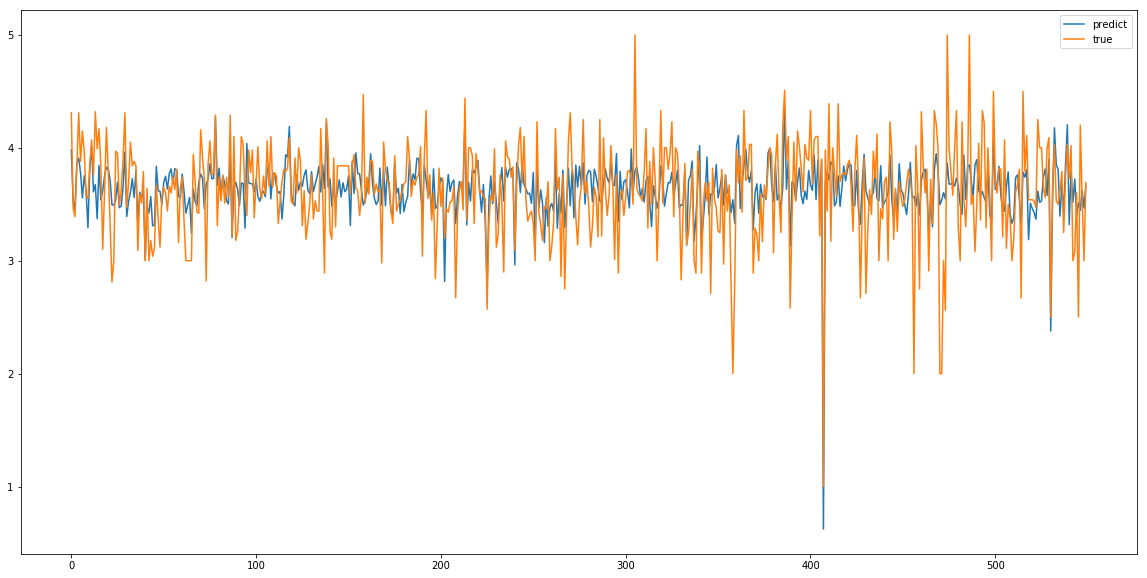

In [482]:
compare_rating.plot(figsize=(20,10))

## Find how to improve and give some advice

In [485]:
def predict(text: str):
    feature = Feature(text).get_feature()
    series = pd.Series(feature, name="test")
    x = series.values / x_train.max(axis=0)   
    x = x.reshape(-1, 23, 1) 
    result = model.predict(x)
    return rating_back(result)

def find_improve_part(text: str):
    feature = Feature(text).get_feature()
    series = pd.Series(feature, name="test")
    x = series.values / x_train.max(axis=0)   
    x = x.reshape(1, 23, 1) 
    result_origin = model.predict(x)
    max_rating = rating_back(result_origin)
    max_index = 0
    increase= 1
    for i in range(0,23):
        for rate in [0.1, 0.2, 0.3]:
            for if_increase in [1, -1]:
                try_series = series
                try_series.iloc[i] = try_series.iloc[i] * (1 + if_increase * rate)
                try_x = try_series.values / x_train.max(axis=0)
                try_x = try_x.reshape(1,23,1)
                try_result = model.predict(try_x)
                try_rating = rating_back(try_result)
                if try_rating > max_rating:
                    max_rating = try_rating
                    max_index = i
                    increase = if_increase
    return (max_index, if_increase, max_rating)

In [486]:
test_text = input("show me your text: ")
# test_text = requests.get("https://raw.githubusercontent.com/JonathanReeve/course-computational-literary-analysis/gh-pages/_texts/dubliners.md").text
predict_rating = predict(test_text)
max_index, if_increase, max_rating = find_improve_part(test_text)
print("=========================== result =================================")
print("Now, your predict rating is {:.2f}. You might not do well in {}, you may {} it, then the rating can reach {:.2f}.".format(predict_rating[0], item_dict[max_index], increase_dict[if_increase], max_rating[0]))

show me your text: 


ZeroDivisionError: division by zero

('Fiction', 1921),
('Short stories', 1604),
('Science fiction', 1286),
('Adventure stories', 789),
('Historical fiction', 654),
('Conduct of life -- Juvenile fiction', 639),
('Poetry', 634),
('Love stories', 620),
('English wit and humor -- Periodicals', 555),
('Detective and mystery stories', 546)